In [1]:
import pandas as pd

In [13]:
# Load the preprocessed ESG and Holdings data
DATA_PATH = "../datasets/"
fund2024 =pd.read_parquet(DATA_PATH +'fund_esg_2024.parquet')

In [14]:
fund2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Industry          8645 non-null   object 
 1   Region            8645 non-null   object 
 2   Country           8645 non-null   object 
 3   Name              8645 non-null   object 
 4   Market_Value_USD  8645 non-null   int64  
 5   Voting            8645 non-null   float64
 6   Ownership         8645 non-null   float64
 7   Portfolio_Weight  8645 non-null   float64
 8   Environmental     8645 non-null   int32  
 9   Social            8645 non-null   int32  
 10  Governance        8645 non-null   int32  
 11  Climate_change    8645 non-null   int32  
 12  ESG_any           8645 non-null   int32  
dtypes: float64(3), int32(5), int64(1), object(4)
memory usage: 709.3+ KB


In [15]:
fund2024.sample(2)

,Industry,Region,Country,Name,Market_Value_USD,Voting,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
1298,Consumer Discretionary,Europe,Germany,jost werke se,24264354,3.46,3.46,0.001887,0,0,0,0,0
4906,Industrials,North America,United States,beacon roofing supply inc,94573418,1.50,1.50,0.007355,0,0,0,0,0


In [11]:
pip install pandas numpy requests beautifulsoup4 lxml

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# At top of notebook
DATA_PATH = "../datasets/"
TEMP_PATH = "./temp/"
VOTING_DATA_PATH = "../datasets/voting_data/"

# Load data
df_p80 = pd.read_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv')

# Checkpoints will save to temp/
checkpoint_file = TEMP_PATH + 'checkpoint_progress.csv'
disagreements_file = TEMP_PATH + 'checkpoint_disagreements.csv'
stats_file = TEMP_PATH + 'checkpoint_stats.csv'

In [17]:
import requests
from bs4 import BeautifulSoup
import time
from datetime import datetime


# STEP 1: CREATE SAMPLE (P80 + ALL ESG_any=1)

# Calculate P80
p80_threshold = fund2024['Market_Value_USD'].quantile(0.80)

print(f"P80 Market Value threshold: ${p80_threshold:,.0f}")

# Create sample: P80 OR ESG_any=1 (union of both groups)
df_p80 = fund2024[
    (fund2024['Market_Value_USD'] >= p80_threshold) | 
    (fund2024['ESG_any'] == 1)
].copy()

print(f"\nFINAL SAMPLE:")
print(f"Total companies: {len(df_p80)}")
print(f"\nBreakdown:")
print(f"  - P80 only (no ESG_any): {((fund2024['Market_Value_USD'] >= p80_threshold) & (fund2024['ESG_any'] == 0)).sum()}")
print(f"  - ESG_any only (outside P80): {((fund2024['Market_Value_USD'] < p80_threshold) & (fund2024['ESG_any'] == 1)).sum()}")
print(f"  - Both conditions (P80 AND ESG_any): {((fund2024['Market_Value_USD'] >= p80_threshold) & (fund2024['ESG_any'] == 1)).sum()}")

# Verification: all ESG_any=1 must be included
total_esg_any = (fund2024['ESG_any'] == 1).sum()
esg_any_in_sample = (df_p80['ESG_any'] == 1).sum()
print(f"\nESG_any verification:")
print(f"  - Total ESG_any=1 in fund2024: {total_esg_any}")
print(f"  - ESG_any=1 in sample: {esg_any_in_sample}")
print(f"  - ✓ All included: {total_esg_any == esg_any_in_sample}")


P80 Market Value threshold: $81,794,677

FINAL SAMPLE:
Total companies: 1925

Breakdown:
  - P80 only (no ESG_any): 1024
  - ESG_any only (outside P80): 196
  - Both conditions (P80 AND ESG_any): 705

ESG_any verification:
  - Total ESG_any=1 in fund2024: 901
  - ESG_any=1 in sample: 901
  - ✓ All included: True


In [29]:
# Save for reference
df_p80.to_csv('p80_companies.csv', index=False)

# API-Based Extraction of NBIM Voting Records

In [57]:
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv('NBIM_API_KEY')
BASE_URL = os.getenv('NBIM_BASE_URL')

In [58]:
import requests
import json

# =============================================================================
# API CONFIGURATION
# =============================================================================

API_KEY = "bgvpKNCRTt9QyhHQMdXc86uhmSCKYDoL6BsyFQKC"
BASE_URL = "https://vd.a.nbim.no"

headers = {
    'x-api-key': API_KEY
}

# =============================================================================
# EXPLORATION: TEST ENDPOINTS
# =============================================================================

# Test 1: Search by company name
print("="*60)
print("TEST 1: Query by company name (Microsoft)")
print("="*60)

company_name = "microsoft corporation"
response = requests.get(
    f"{BASE_URL}/v1/query/company/{company_name}",
    headers=headers
)

print(f"Status code: {response.status_code}")

if response.status_code == 200:
    data = response.json()
    print(f"\nResponse structure:")
    print(json.dumps(data, indent=2)[:1000])  # First 1000 chars
    
    # Save full response
    with open('api_response_company.json', 'w') as f:
        json.dump(data, f, indent=2)
    print("\n✓ Full response saved to 'api_response_company.json'")
else:
    print(f"Error: {response.text}")


TEST 1: Query by company name (Microsoft)
Status code: 200

Response structure:
{
  "companies": [
    {
      "Ticker": "MSFT",
      "country": "United States",
      "id": 142533,
      "isin": "US5949181045",
      "meetings": [
        {
          "meetingDate": "2025-12-05 00:00:00",
          "meetingId": 2017007,
          "meetingType": "Annual"
        },
        {
          "meetingDate": "2024-12-10 00:00:00",
          "meetingId": 1906254,
          "meetingType": "Annual"
        },
        {
          "meetingDate": "2023-12-07 00:00:00",
          "meetingId": 1798481,
          "meetingType": "Annual"
        },
        {
          "meetingDate": "2022-12-13 00:00:00",
          "meetingId": 1694381,
          "meetingType": "Annual"
        },
        {
          "meetingDate": "2021-11-30 00:00:00",
          "meetingId": 1584741,
          "meetingType": "Annual"
        },
        {
          "meetingDate": "2020-12-02 00:00:00",
          "meetingId": 1479998,
  

In [26]:
# Get the first meeting ID from Microsoft's meetings
meeting_id = 2017007  # Most recent Microsoft meeting (2025-12-05)

print(f"TEST 2: Query meeting details (ID: {meeting_id})")
print("="*60)

# Make API request to get meeting details
response = requests.get(
    f"{BASE_URL}/v1/query/meeting/{meeting_id}",
    headers=headers
)

print(f"Status code: {response.status_code}")

if response.status_code == 200:
    data = response.json()
    
    # Print structure to console
    print(f"\nResponse structure:")
    print(json.dumps(data, indent=2))
    
else:
    print(f"Error: {response.text}")

TEST 2: Query meeting details (ID: 2017007)
Status code: 200

Response structure:
{
  "meeting": {
    "companyId": 142533,
    "companyName": "Microsoft Corporation",
    "companyTicker": "MSFT",
    "isin": "US5949181045",
    "meetingDate": "2025-12-05 00:00:00",
    "meetingId": 2017007,
    "meetingType": "Annual",
    "meetingVotes": [
      {
        "itemOnAgendaId": 17732594,
        "managementRec": "For",
        "meetingId": 2017007,
        "proponent": "Management",
        "proposalNumber": "1a",
        "proposalSequence": "1",
        "proposalText": "Elect Director Reid G. Hoffman",
        "voteInstruction": "For",
        "voterRationale": null
      },
      {
        "itemOnAgendaId": 17732595,
        "managementRec": "For",
        "meetingId": 2017007,
        "proponent": "Management",
        "proposalNumber": "1b",
        "proposalSequence": "2",
        "proposalText": "Elect Director Hugh F. Johnston",
        "voteInstruction": "For",
        "voterRatio

In [51]:
# LOAD P80 COMPANIES FOR PROCESSING
DATA_PATH = "../datasets/"
df_p80 =pd.read_csv(DATA_PATH +'p80_companies.csv')
df_p80.sample(3)

,Industry,Region,Country,Name,Market_Value_USD,Voting,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
509,Consumer Staples,North America,United States,sprouts farmers market inc,143113350,1.13,1.13,0.011130,1,1,1,0,1
1742,Technology,Asia,Taiwan,phison electronics corp,82621884,2.47,2.47,0.006426,0,0,0,0,0
1536,Real Estate,North America,United States,lineage inc,680636054,5.09,5.09,0.052933,1,1,1,0,1


In [49]:
# Sort by Market Value descending
df_p80 = df_p80.sort_values('Market_Value_USD', ascending=False)

In [48]:
df_p80.head(8)

,Industry,Region,Country,Name,Market_Value_USD,Voting,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
1598,Technology,North America,United States,apple inc,46210392003,1.22,1.22,3.593782,0,1,1,0,1
1709,Technology,North America,United States,microsoft corp,43758827987,1.40,1.40,3.403124,0,1,1,0,1
1731,Technology,North America,United States,nvidia corp,42973911250,1.31,1.31,3.342081,1,0,1,1,1
1593,Technology,North America,United States,alphabet inc,29271691564,0.88,1.26,2.276459,0,1,1,0,1
121,Consumer Discretionary,North America,United States,amazon.com inc,26979313029,1.17,1.17,2.098181,1,1,1,1,1
1706,Technology,North America,United States,meta platforms inc,19750530468,0.60,1.34,1.535999,1,1,1,1,1
1616,Technology,North America,United States,broadcom inc,16712325272,1.54,1.54,1.299717,0,0,1,0,1
1776,Technology,Asia,Taiwan,taiwan semiconductor manufacturing co ltd,15368120434,1.80,1.80,1.195179,0,0,0,0,0


In [37]:
import time
from datetime import datetime
import os

In [53]:
#just for a test
df_p80 = df_p80.head(50) 

In [40]:
print(f"Total companies to process: {len(df_p80)}")

# CHECKPOINT: Check if we have partial progress
checkpoint_file = 'checkpoint_progress.csv'
disagreements_file = 'checkpoint_disagreements.csv'
stats_file = 'checkpoint_stats.csv'

if os.path.exists(checkpoint_file):
    processed_companies = pd.read_csv(checkpoint_file)['company_name'].tolist()
    all_disagreements = pd.read_csv(disagreements_file).to_dict('records')
    company_stats = pd.read_csv(stats_file).to_dict('records')
    print(f"\n✓ RESUMING from checkpoint: {len(processed_companies)} companies already done")
else:
    processed_companies = []
    all_disagreements = []
    company_stats = []

# Track progress
start_time = datetime.now()
processed = len(processed_companies)
errors = []
checkpoint_interval = 100  # Save every 100 companies

for idx, row in df_p80.iterrows():
    company_name = row['Name']
    
    # Skip if already processed
    if company_name in processed_companies:
        continue
    
    processed += 1
    
    # Progress update every 50 companies
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_p80) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_p80)} ({processed/len(df_p80)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        # Step 1: Get company info and meetings
        response = requests.get(
            f"{BASE_URL}/v1/query/company/{company_name}",
            headers=headers,
            timeout=10
        )
        
        if response.status_code != 200:
            errors.append({'company': company_name, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        # Check if companies array exists
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        # Filter meetings from 2020 onwards
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        # Stats for this company
        total_disagreements = 0
        
        # Step 2: Process each meeting
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            # Get meeting details
            time.sleep(0.1)  # Rate limiting
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            # Identify disagreements
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                # DISAGREEMENT: when different
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    # Extract rationale info
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    # Store disagreement
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        # Store company-level stats
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        # CHECKPOINT: Save progress every 100 companies
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'error': str(e)})
        processed_companies.append(company_name)
        continue

# Final save
df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")

Total companies to process: 50
Progress: 50/50 (100.0%) - Est. 0.0 min remaining

EXTRACTION COMPLETE
Total companies processed: 50
Total errors: 17
Total disagreements found: 315

Companies with disagreements: 25
Companies with zero disagreements: 8


In [47]:
# View sample of disagreements
print("SAMPLE DISAGREEMENTS:")
print(df_disagreements.head(10))

print("\n" + "="*60)

# View which companies had errors
print("ERRORS:")
print(df_errors)

print("\n" + "="*60)

# View statistics per company
print("COMPANY STATS:")
print(df_stats.head(10))

SAMPLE DISAGREEMENTS:
  company_name ticker        country         meeting_date  meeting_id  \
0    apple inc   AAPL  United States  2024-02-28 00:00:00     1815577   
1    apple inc   AAPL  United States  2024-02-28 00:00:00     1815577   
2    apple inc   AAPL  United States  2023-03-10 00:00:00     1709502   
3    apple inc   AAPL  United States  2023-03-10 00:00:00     1709502   
4    apple inc   AAPL  United States  2022-03-04 00:00:00     1601071   
5    apple inc   AAPL  United States  2022-03-04 00:00:00     1601071   
6    apple inc   AAPL  United States  2022-03-04 00:00:00     1601071   
7    apple inc   AAPL  United States  2022-03-04 00:00:00     1601071   
8    apple inc   AAPL  United States  2022-03-04 00:00:00     1601071   
9    apple inc   AAPL  United States  2020-02-26 00:00:00     1388634   

  meeting_type proposal_number  \
0       Annual               6   
1       Annual               7   
2       Annual               3   
3       Annual               8   
4   

In [54]:
print(f"Total companies to process: {len(df_p80)}")

# CHECKPOINT: Check if we have partial progress
checkpoint_file = 'checkpoint_progress.csv'
disagreements_file = 'checkpoint_disagreements.csv'
stats_file = 'checkpoint_stats.csv'

if os.path.exists(checkpoint_file):
    processed_companies = pd.read_csv(checkpoint_file)['company_name'].tolist()
    all_disagreements = pd.read_csv(disagreements_file).to_dict('records')
    company_stats = pd.read_csv(stats_file).to_dict('records')
    print(f"\n✓ RESUMING from checkpoint: {len(processed_companies)} companies already done")
else:
    processed_companies = []
    all_disagreements = []
    company_stats = []

# Track progress
start_time = datetime.now()
processed = len(processed_companies)
errors = []
checkpoint_interval = 100

for idx, row in df_p80.iterrows():
    company_name = row['Name']
    ticker = row.get('Ticker', '')
    
    # Skip if already processed
    if company_name in processed_companies:
        continue
    
    processed += 1
    
    # Progress update every 50 companies
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_p80) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_p80)} ({processed/len(df_p80)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        # Step 1: Try by company name
        response = requests.get(
            f"{BASE_URL}/v1/query/company/{company_name}",
            headers=headers,
            timeout=10
        )
        
        # Check if first attempt failed
        if response.status_code != 200 or 'companies' not in response.json() or len(response.json()['companies']) == 0:
            # FALLBACK: Try by ticker
            if ticker:
                print(f"  → Retrying '{company_name}' with ticker '{ticker}'")
                time.sleep(0.1)
                response = requests.get(
                    f"{BASE_URL}/v1/query/ticker/{ticker}",
                    headers=headers,
                    timeout=10
                )
        
        # If still failed, log error and continue
        if response.status_code != 200:
            errors.append({'company': company_name, 'ticker': ticker, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        # Check if companies array exists
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'ticker': ticker, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        # Filter meetings from 2020 onwards
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        # Stats for this company
        total_disagreements = 0
        
        # Step 2: Process each meeting
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            # Get meeting details
            time.sleep(0.1)
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            # Identify disagreements
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                # DISAGREEMENT: when different
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    # Extract rationale info
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    # Store disagreement
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        # Store company-level stats
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        # CHECKPOINT: Save progress every 100 companies
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'ticker': ticker, 'error': str(e)})
        processed_companies.append(company_name)
        continue

# Final save
df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")

Total companies to process: 50
Progress: 50/50 (100.0%) - Est. 0.0 min remaining

EXTRACTION COMPLETE
Total companies processed: 50
Total errors: 7
Total disagreements found: 172

Companies with disagreements: 32
Companies with zero disagreements: 11


In [59]:
# Check which companies had errors
print("REMAINING ERRORS:")
print(df_errors[['company', 'ticker', 'error']])

print("\n" + "="*60)

# Check companies with most disagreements
print("TOP 10 COMPANIES BY DISAGREEMENTS:")
print(df_stats.nlargest(10, 'total_disagreements')[['company_name', 'total_disagreements']])

REMAINING ERRORS:
                          company ticker             error
0          agnico eagle mines ltd         No data returned
1  air products and chemicals inc         No data returned
2                 alamos gold inc         No data returned
3                   bhp group ltd         No data returned
4      cf industries holdings inc         No data returned
5    ganfeng lithium group co ltd         No data returned
6          grupo mexico sab de cv         No data returned

TOP 10 COMPANIES BY DISAGREEMENTS:
             company_name  total_disagreements
40          icl group ltd                   32
24             ecolab inc                   14
25       empresas cmpc sa                   14
22                dow inc                   10
23    eastman chemical co                   10
19   cleveland-cliffs inc                    9
36            givaudan sa                    8
3          albemarle corp                    7
26  ems-chemie holding ag                    7
35  

In [60]:
df_disagreements.head(3)

,company_name,ticker,country,meeting_date,meeting_id,meeting_type,proposal_number,proposal_text,proponent,management_rec,nbim_vote,position_paper,rationale_text
0,acerinox sa,ACX,Spain,2020-10-21 00:00:00,1471725,Annual,9,"Authorize Issuance of Convertible Bonds, Deben...",Management,For,Against,Position paper: Shareholder rights in equity i...,Existing shareholders should have the right to...
1,air liquide sa,AI,France,2021-05-04 00:00:00,1504230,Annual/Special,8,Elect Bertrand Dumazy as Director,Management,For,Against,Position paper: Time commitment of board members,Board members should devote sufficient time to...
2,albemarle corp,ALB,United States,2025-05-06 00:00:00,1946039,Annual,1c,"Elect Director J. Kent Masters, Jr.",Management,For,Against,Position paper: Separation of chairperson and CEO,The board should exercise objective judgement ...


In [70]:
df_disagreements[df_disagreements['company_name'].str.contains('gerdau')]

,company_name,ticker,country,meeting_date,meeting_id,meeting_type,proposal_number,proposal_text,proponent,management_rec,nbim_vote,position_paper,rationale_text
112,gerdau sa,GGBR4,Brazil,2025-04-10 00:00:00,1939048,Annual,1,"As a Preferred Shareholder, Would You like to ...",Management,None,Abstain,,
113,gerdau sa,GGBR4,Brazil,2025-04-10 00:00:00,1939048,Annual,2,Elect Denisio Augusto Liberato Delfino as Fisc...,Shareholder,None,For,,
114,gerdau sa,GGBR4,Brazil,2025-04-10 00:00:00,1939048,Annual,3,In Case Neither Class of Shares Reaches the Mi...,Management,None,For,,
115,gerdau sa,GGBR4,Brazil,2024-04-16 00:00:00,1835336,Annual,1,"As a Preferred Shareholder, Would You like to ...",Management,None,For,,
116,gerdau sa,GGBR4,Brazil,2024-04-16 00:00:00,1835336,Annual,2,Elect Claudio Antonio Goncalves as Director Ap...,Shareholder,None,For,,
117,gerdau sa,GGBR4,Brazil,2024-04-16 00:00:00,1835336,Annual,3,In Case Neither Class of Shares Reaches the Mi...,Management,None,For,,
118,gerdau sa,GGBR4,Brazil,2024-04-16 00:00:00,1835336,Annual,4,Elect Denisio Augusto Liberato Delfino as Fisc...,Shareholder,None,For,,


In [71]:
import re

In [74]:
df_p80[df_p80['Name'].str.contains('alamos')]

,Industry,Region,Country,Name,Market_Value_USD,Voting,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
5,Basic Materials,North America,Canada,alamos gold inc,100771261,1.3,1.3,0.007837,0,0,0,0,0


In [ ]:
# Same dataframe will be used
df_p80.shape

(50, 13)

In [79]:
#Erasing previous checkpoints for trying a new approach to correct mistakes

# Delete old checkpoints
files_to_delete = ['checkpoint_progress.csv', 'checkpoint_disagreements.csv', 'checkpoint_stats.csv']

for file in files_to_delete:
    if os.path.exists(file):
        os.remove(file)
        print(f"✓ Deleted {file}")

print("\nCheckpoints cleared")


Checkpoints cleared


In [80]:
def clean_company_name(name):
    if pd.isna(name):
        return ""
    # Remove punctuation and parentheses
    name = re.sub(r'[.,()&/]', '', name)
    # Replace multiple spaces with single space
    name = ' '.join(name.split())
    return name.strip()

print(f"Total companies to process: {len(df_p80)}")

# CHECKPOINT: Check if we have partial progress
checkpoint_file = 'checkpoint_progress.csv'
disagreements_file = 'checkpoint_disagreements.csv'
stats_file = 'checkpoint_stats.csv'

if os.path.exists(checkpoint_file):
    processed_companies = pd.read_csv(checkpoint_file)['company_name'].tolist()
    all_disagreements = pd.read_csv(disagreements_file).to_dict('records')
    company_stats = pd.read_csv(stats_file).to_dict('records')
    print(f"\n✓ RESUMING from checkpoint: {len(processed_companies)} companies already done")
else:
    processed_companies = []
    all_disagreements = []
    company_stats = []

# Track progress
start_time = datetime.now()
processed = len(processed_companies)
errors = []
checkpoint_interval = 100

for idx, row in df_p80.iterrows():
    company_name = row['Name']
    ticker = row.get('Ticker', '')
    
    # Skip if already processed
    if company_name in processed_companies:
        continue
    
    processed += 1
    
    # Progress update every 50 companies
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_p80) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_p80)} ({processed/len(df_p80)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        # STRATEGY: Try ticker first (if available), then name
        response = None
        
        # Try 1: Search by ticker (more reliable)
        if ticker and ticker.strip():
            response = requests.get(
                f"{BASE_URL}/v1/query/ticker/{ticker}",
                headers=headers,
                timeout=10
            )
            
            if response.status_code == 200 and 'companies' in response.json() and len(response.json()['companies']) > 0:
                # Ticker worked
                pass
            else:
                # Ticker failed, try name
                response = None
        
        # Try 2: Search by company name (if ticker failed or not available)
        if response is None:
            clean_name = clean_company_name(company_name)
            response = requests.get(
                f"{BASE_URL}/v1/query/company/{clean_name}",
                headers=headers,
                timeout=10
            )
        
        # If both failed, log error and continue
        if response.status_code != 200:
            errors.append({'company': company_name, 'ticker': ticker, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        # Check if companies array exists
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'ticker': ticker, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        # Filter meetings from 2020 onwards
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        # Stats for this company
        total_disagreements = 0
        
        # Step 2: Process each meeting
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            # Get meeting details
            time.sleep(0.1)
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            # Identify disagreements
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                # SKIP if management_rec is None or empty
                if mgmt_rec is None or mgmt_rec == '' or pd.isna(mgmt_rec):
                    continue
                
                # SKIP if nbim_vote is None or empty
                if nbim_vote is None or nbim_vote == '' or pd.isna(nbim_vote):
                    continue
                
                # DISAGREEMENT: when different
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    # Extract rationale info
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    # Store disagreement
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        # Store company-level stats
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        # CHECKPOINT: Save progress every 100 companies
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'ticker': ticker, 'error': str(e)})
        processed_companies.append(company_name)
        continue

# Final save
df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")

Total companies to process: 50
Progress: 50/50 (100.0%) - Est. 0.0 min remaining

EXTRACTION COMPLETE
Total companies processed: 50
Total errors: 7
Total disagreements found: 172

Companies with disagreements: 32
Companies with zero disagreements: 11


In [81]:
# Check which companies had errors
print("REMAINING ERRORS:")
print(df_errors[['company', 'ticker', 'error']])

print("\n" + "="*60)

# Check companies with most disagreements
print("TOP 10 COMPANIES BY DISAGREEMENTS:")
print(df_stats.nlargest(10, 'total_disagreements')[['company_name', 'total_disagreements']])

REMAINING ERRORS:
                          company ticker             error
0          agnico eagle mines ltd         No data returned
1  air products and chemicals inc         No data returned
2                 alamos gold inc         No data returned
3                   bhp group ltd         No data returned
4      cf industries holdings inc         No data returned
5    ganfeng lithium group co ltd         No data returned
6          grupo mexico sab de cv         No data returned

TOP 10 COMPANIES BY DISAGREEMENTS:
             company_name  total_disagreements
40          icl group ltd                   32
24             ecolab inc                   14
25       empresas cmpc sa                   14
22                dow inc                   10
23    eastman chemical co                   10
19   cleveland-cliffs inc                    9
36            givaudan sa                    8
3          albemarle corp                    7
26  ems-chemie holding ag                    7
35  

In [86]:
# Check ICL disagreements - verify None filtering worked
icl_disagreements = df_disagreements[df_disagreements['company_name'].str.contains('icl', case=False)]

print(f"Total ICL disagreements: {len(icl_disagreements)}")
print("\nSample of ICL disagreements:")
print(icl_disagreements[['proposal_number', 'management_rec', 'nbim_vote']].head(10))

print("\n" + "="*60)
print("Checking for None values:")
print(f"Proposals with None in management_rec: {icl_disagreements['management_rec'].isna().sum()}")
print(f"Proposals with None as string: {(icl_disagreements['management_rec'] == 'None').sum()}")

Total ICL disagreements: 32

Sample of ICL disagreements:
    proposal_number management_rec nbim_vote
137               A           None   Against
138              B1           None   Against
139              B2           None   Against
140              B3           None   Against
141               A           None   Against
142              B1           None   Against
143              B2           None   Against
144              B3           None   Against
145               A           None   Against
146              B1           None   Against

Checking for None values:
Proposals with None in management_rec: 0
Proposals with None as string: 32


In [87]:
for file in ['checkpoint_progress.csv', 'checkpoint_disagreements.csv', 'checkpoint_stats.csv']:
    if os.path.exists(file):
        os.remove(file)

In [89]:
def clean_company_name(name):
    if pd.isna(name):
        return ""
    # Remove punctuation and parentheses
    name = re.sub(r'[.,()&/]', '', name)
    # Replace multiple spaces with single space
    name = ' '.join(name.split())
    return name.strip()

print(f"Total companies to process: {len(df_p80)}")

# CHECKPOINT: Check if we have partial progress
checkpoint_file = 'checkpoint_progress.csv'
disagreements_file = 'checkpoint_disagreements.csv'
stats_file = 'checkpoint_stats.csv'

if os.path.exists(checkpoint_file):
    processed_companies = pd.read_csv(checkpoint_file)['company_name'].tolist()
    all_disagreements = pd.read_csv(disagreements_file).to_dict('records')
    company_stats = pd.read_csv(stats_file).to_dict('records')
    print(f"\n✓ RESUMING from checkpoint: {len(processed_companies)} companies already done")
else:
    processed_companies = []
    all_disagreements = []
    company_stats = []

# Track progress
start_time = datetime.now()
processed = len(processed_companies)
errors = []
checkpoint_interval = 100

for idx, row in df_p80.iterrows():
    company_name = row['Name']
    ticker = row.get('Ticker', '')
    
    # Skip if already processed
    if company_name in processed_companies:
        continue
    
    processed += 1
    
    # Progress update every 50 companies
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_p80) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_p80)} ({processed/len(df_p80)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        # STRATEGY: Try ticker first (if available), then name
        response = None
        
        # Try 1: Search by ticker (more reliable)
        if ticker and ticker.strip():
            response = requests.get(
                f"{BASE_URL}/v1/query/ticker/{ticker}",
                headers=headers,
                timeout=10
            )
            
            if response.status_code == 200 and 'companies' in response.json() and len(response.json()['companies']) > 0:
                # Ticker worked
                pass
            else:
                # Ticker failed, try name
                response = None
        
        # Try 2: Search by company name (if ticker failed or not available)
        if response is None:
            clean_name = clean_company_name(company_name)
            response = requests.get(
                f"{BASE_URL}/v1/query/company/{clean_name}",
                headers=headers,
                timeout=10
            )
        
        # If both failed, log error and continue
        if response.status_code != 200:
            errors.append({'company': company_name, 'ticker': ticker, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        # Check if companies array exists
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'ticker': ticker, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        # Filter meetings from 2020 onwards
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        # Stats for this company
        total_disagreements = 0
        
        # Step 2: Process each meeting
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            # Get meeting details
            time.sleep(0.1)
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            # Identify disagreements
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                # SKIP if management_rec is None, empty, or string "None"
                if mgmt_rec is None or mgmt_rec == '' or pd.isna(mgmt_rec) or str(mgmt_rec) == 'None':
                    continue
                
                # SKIP if nbim_vote is None, empty, or string "None"
                if nbim_vote is None or nbim_vote == '' or pd.isna(nbim_vote) or str(nbim_vote) == 'None':
                    continue
                
                # DISAGREEMENT: when different
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    # Extract rationale info
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    # Store disagreement
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        # Store company-level stats
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        # CHECKPOINT: Save progress every 100 companies
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'ticker': ticker, 'error': str(e)})
        processed_companies.append(company_name)
        continue

# Final save
df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")

Total companies to process: 50
Progress: 50/50 (100.0%) - Est. 0.0 min remaining

EXTRACTION COMPLETE
Total companies processed: 50
Total errors: 7
Total disagreements found: 129

Companies with disagreements: 28
Companies with zero disagreements: 15


In [90]:
# Check which companies had errors
print("REMAINING ERRORS:")
print(df_errors[['company', 'ticker', 'error']])

print("\n" + "="*60)

# Check companies with most disagreements
print("TOP 10 COMPANIES BY DISAGREEMENTS:")
print(df_stats.nlargest(10, 'total_disagreements')[['company_name', 'total_disagreements']])

REMAINING ERRORS:
                          company ticker             error
0          agnico eagle mines ltd         No data returned
1  air products and chemicals inc         No data returned
2                 alamos gold inc         No data returned
3                   bhp group ltd         No data returned
4      cf industries holdings inc         No data returned
5    ganfeng lithium group co ltd         No data returned
6          grupo mexico sab de cv         No data returned

TOP 10 COMPANIES BY DISAGREEMENTS:
             company_name  total_disagreements
24             ecolab inc                   14
25       empresas cmpc sa                   14
22                dow inc                   10
23    eastman chemical co                   10
19   cleveland-cliffs inc                    9
36            givaudan sa                    8
3          albemarle corp                    7
26  ems-chemie holding ag                    7
38              holmen ab                    7
18  

In [91]:
#Restablishing the dataset to its original size and content
# LOAD P80 COMPANIES FOR PROCESSING
DATA_PATH = "../datasets/"
df_p80 =pd.read_csv(DATA_PATH +'p80_companies.csv')
df_p80.shape


(1925, 13)

In [92]:
#Erasing checkpoints for being able to analyze from scratch
for file in ['checkpoint_progress.csv', 'checkpoint_disagreements.csv', 'checkpoint_stats.csv']:
    if os.path.exists(file):
        os.remove(file)
        print(f"✓ Deleted {file}")

In [93]:
def clean_company_name(name):
    if pd.isna(name):
        return ""
    name = re.sub(r'[.,()&/]', '', name)
    name = ' '.join(name.split())
    return name.strip()

print(f"Total companies to process: {len(df_p80)}")

checkpoint_file = 'checkpoint_progress.csv'
disagreements_file = 'checkpoint_disagreements.csv'
stats_file = 'checkpoint_stats.csv'

if os.path.exists(checkpoint_file):
    processed_companies = pd.read_csv(checkpoint_file)['company_name'].tolist()
    all_disagreements = pd.read_csv(disagreements_file).to_dict('records')
    company_stats = pd.read_csv(stats_file).to_dict('records')
    print(f"\n✓ RESUMING from checkpoint: {len(processed_companies)} companies already done")
else:
    processed_companies = []
    all_disagreements = []
    company_stats = []

start_time = datetime.now()
processed = len(processed_companies)
errors = []
checkpoint_interval = 100

for idx, row in df_p80.iterrows():
    company_name = row['Name']
    ticker = row.get('Ticker', '')
    
    if company_name in processed_companies:
        continue
    
    processed += 1
    
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_p80) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_p80)} ({processed/len(df_p80)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        response = None
        
        if ticker and ticker.strip():
            response = requests.get(
                f"{BASE_URL}/v1/query/ticker/{ticker}",
                headers=headers,
                timeout=10
            )
            
            if response.status_code == 200 and 'companies' in response.json() and len(response.json()['companies']) > 0:
                pass
            else:
                response = None
        
        if response is None:
            clean_name = clean_company_name(company_name)
            response = requests.get(
                f"{BASE_URL}/v1/query/company/{clean_name}",
                headers=headers,
                timeout=10
            )
        
        if response.status_code != 200:
            errors.append({'company': company_name, 'ticker': ticker, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'ticker': ticker, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        total_disagreements = 0
        
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            time.sleep(0.1)
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                if mgmt_rec is None or mgmt_rec == '' or pd.isna(mgmt_rec) or str(mgmt_rec) == 'None':
                    continue
                
                if nbim_vote is None or nbim_vote == '' or pd.isna(nbim_vote) or str(nbim_vote) == 'None':
                    continue
                
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'ticker': ticker, 'error': str(e)})
        processed_companies.append(company_name)
        continue

df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")

Total companies to process: 1925
Progress: 50/1925 (2.6%) - Est. 150.6 min remaining
Progress: 100/1925 (5.2%) - Est. 117.1 min remaining
Progress: 150/1925 (7.8%) - Est. 103.7 min remaining
Progress: 200/1925 (10.4%) - Est. 91.7 min remaining

✓ Checkpoint saved at 200 companies
Progress: 250/1925 (13.0%) - Est. 88.9 min remaining
Progress: 300/1925 (15.6%) - Est. 86.8 min remaining

✓ Checkpoint saved at 300 companies
Progress: 350/1925 (18.2%) - Est. 84.4 min remaining
Progress: 400/1925 (20.8%) - Est. 81.5 min remaining

✓ Checkpoint saved at 400 companies
Progress: 450/1925 (23.4%) - Est. 76.5 min remaining
Progress: 500/1925 (26.0%) - Est. 72.2 min remaining

✓ Checkpoint saved at 500 companies
Progress: 550/1925 (28.6%) - Est. 68.5 min remaining
Progress: 600/1925 (31.2%) - Est. 68.6 min remaining

✓ Checkpoint saved at 600 companies
Progress: 650/1925 (33.8%) - Est. 67.4 min remaining
Progress: 700/1925 (36.4%) - Est. 65.1 min remaining
Progress: 750/1925 (39.0%) - Est. 59.3 mi

In [94]:
# Check which companies had errors
print("REMAINING ERRORS:")
print(df_errors[['company', 'ticker', 'error']])

print("\n" + "="*60)

# Check companies with most disagreements
print("TOP 10 COMPANIES BY DISAGREEMENTS:")
print(df_stats.nlargest(10, 'total_disagreements')[['company_name', 'total_disagreements']])

REMAINING ERRORS:
                             company ticker             error
0             agnico eagle mines ltd         No data returned
1     air products and chemicals inc         No data returned
2                    alamos gold inc         No data returned
3                      bhp group ltd         No data returned
4         cf industries holdings inc         No data returned
...                              ...    ...               ...
1549      united utilities group plc               Status 429
1550         veolia environnement sa               Status 429
1551                     vistra corp               Status 429
1552           waste connections inc               Status 429
1553            waste management inc               Status 429

[1554 rows x 3 columns]

TOP 10 COMPANIES BY DISAGREEMENTS:
                 company_name  total_disagreements
218             volkswagen ag                   85
358    berkshire hathaway inc                   56
217                viven

In [95]:
# Error breakdown
print("ERROR BREAKDOWN:")
print(df_errors['error'].value_counts())

print("\n" + "="*60)
print(f"✓ Successfully processed: {len(df_stats)} empresas")
print(f"  - With disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"  - Zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")
print(f"\n✗ Failed: {len(df_errors)} empresas")
print(f"\nTotal disagreements found: {len(df_disagreements)}")

ERROR BREAKDOWN:
error
Status 429          1243
No data returned     311
Name: count, dtype: int64

✓ Successfully processed: 371 empresas
  - With disagreements: 243
  - Zero disagreements: 128

✗ Failed: 1554 empresas

Total disagreements found: 1805


In [96]:
# Error breakdown by type
print("ERROR BREAKDOWN:")
print(df_errors['error'].value_counts())

print("\n" + "="*60)

# Check at what point 429 errors started
df_errors['error_type'] = df_errors['error'].apply(lambda x: '429' if '429' in str(x) else 'Other')
print("\nError type distribution:")
print(df_errors['error_type'].value_counts())

ERROR BREAKDOWN:
error
Status 429          1243
No data returned     311
Name: count, dtype: int64


Error type distribution:
error_type
429      1243
Other     311
Name: count, dtype: int64


In [ ]:
def clean_company_name(name):
    if pd.isna(name):
        return ""
    name = re.sub(r'[.,()&/]', '', name)
    name = ' '.join(name.split())
    return name.strip()

print(f"Total companies to process: {len(df_p80)}")

checkpoint_file = 'checkpoint_progress.csv'
disagreements_file = 'checkpoint_disagreements.csv'
stats_file = 'checkpoint_stats.csv'

if os.path.exists(checkpoint_file):
    processed_companies = pd.read_csv(checkpoint_file)['company_name'].tolist()
    all_disagreements = pd.read_csv(disagreements_file).to_dict('records')
    company_stats = pd.read_csv(stats_file).to_dict('records')
    print(f"\n✓ RESUMING from checkpoint: {len(processed_companies)} companies already done")
else:
    processed_companies = []
    all_disagreements = []
    company_stats = []

start_time = datetime.now()
processed = len(processed_companies)
errors = []
checkpoint_interval = 100

for idx, row in df_p80.iterrows():
    company_name = row['Name']
    ticker = row.get('Ticker', '')
    
    if company_name in processed_companies:
        continue
    
    processed += 1
    
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_p80) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_p80)} ({processed/len(df_p80)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        response = None
        
        if ticker and ticker.strip():
            response = requests.get(
                f"{BASE_URL}/v1/query/ticker/{ticker}",
                headers=headers,
                timeout=10
            )
            
            if response.status_code == 200 and 'companies' in response.json() and len(response.json()['companies']) > 0:
                pass
            else:
                response = None
        
        if response is None:
            clean_name = clean_company_name(company_name)
            response = requests.get(
                f"{BASE_URL}/v1/query/company/{clean_name}",
                headers=headers,
                timeout=10
            )
        
        if response.status_code != 200:
            errors.append({'company': company_name, 'ticker': ticker, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'ticker': ticker, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        total_disagreements = 0
        
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            time.sleep(1.0)  # INCREASED from 0.1 to 1.0 seconds
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                if mgmt_rec is None or mgmt_rec == '' or pd.isna(mgmt_rec) or str(mgmt_rec) == 'None':
                    continue
                
                if nbim_vote is None or nbim_vote == '' or pd.isna(nbim_vote) or str(nbim_vote) == 'None':
                    continue
                
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'ticker': ticker, 'error': str(e)})
        processed_companies.append(company_name)
        continue

df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")

In [ ]:
# Verify checkpoint files exist
print("Checkpoint files exist:")
print(f"checkpoint_progress.csv: {os.path.exists('checkpoint_progress.csv')}")
print(f"checkpoint_disagreements.csv: {os.path.exists('checkpoint_disagreements.csv')}")
print(f"checkpoint_stats.csv: {os.path.exists('checkpoint_stats.csv')}")

# Verify how many companies already processed
if os.path.exists('checkpoint_progress.csv'):
    processed = pd.read_csv('checkpoint_progress.csv')
    print(f"\nCompanies already processed: {len(processed)}")

Checkpoint files exist:
checkpoint_progress.csv: True
checkpoint_disagreements.csv: True
checkpoint_stats.csv: True

Companies already processed: 600


Continue with the execution after revising the errors, checking the number of analyzed companies and slowing the time between API requests

In [98]:
def clean_company_name(name):
    if pd.isna(name):
        return ""
    # Remove punctuation and parentheses
    name = re.sub(r'[.,()&/]', '', name)
    # Replace multiple spaces with single space
    name = ' '.join(name.split())
    return name.strip()

print(f"Total companies to process: {len(df_p80)}")

checkpoint_file = 'checkpoint_progress.csv'
disagreements_file = 'checkpoint_disagreements.csv'
stats_file = 'checkpoint_stats.csv'

if os.path.exists(checkpoint_file):
    processed_companies = pd.read_csv(checkpoint_file)['company_name'].tolist()
    all_disagreements = pd.read_csv(disagreements_file).to_dict('records')
    company_stats = pd.read_csv(stats_file).to_dict('records')
    print(f"\n✓ RESUMING from checkpoint: {len(processed_companies)} companies already done")
else:
    processed_companies = []
    all_disagreements = []
    company_stats = []

start_time = datetime.now()
processed = len(processed_companies)
errors = []
checkpoint_interval = 100

for idx, row in df_p80.iterrows():
    company_name = row['Name']
    ticker = row.get('Ticker', '')
    
    # Skip if already processed
    if company_name in processed_companies:
        continue
    
    processed += 1
    
    # Progress update every 50 companies
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_p80) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_p80)} ({processed/len(df_p80)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        response = None
        
        # Try 1: Search by ticker (more reliable)
        if ticker and ticker.strip():
            response = requests.get(
                f"{BASE_URL}/v1/query/ticker/{ticker}",
                headers=headers,
                timeout=10
            )
            
            if response.status_code == 200 and 'companies' in response.json() and len(response.json()['companies']) > 0:
                pass
            else:
                response = None
        
        # Try 2: Search by company name (if ticker failed or not available)
        if response is None:
            clean_name = clean_company_name(company_name)
            response = requests.get(
                f"{BASE_URL}/v1/query/company/{clean_name}",
                headers=headers,
                timeout=10
            )
        
        # If both failed, log error and continue
        if response.status_code != 200:
            errors.append({'company': company_name, 'ticker': ticker, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        # Check if companies array exists
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'ticker': ticker, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        # Filter meetings from 2020 onwards
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        # Stats for this company
        total_disagreements = 0
        
        # Step 2: Process each meeting
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            # Rate limiting: 1 second delay between requests
            time.sleep(1.0)
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            # Identify disagreements
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                # SKIP if management_rec is None, empty, or string "None"
                if mgmt_rec is None or mgmt_rec == '' or pd.isna(mgmt_rec) or str(mgmt_rec) == 'None':
                    continue
                
                # SKIP if nbim_vote is None, empty, or string "None"
                if nbim_vote is None or nbim_vote == '' or pd.isna(nbim_vote) or str(nbim_vote) == 'None':
                    continue
                
                # DISAGREEMENT: when different
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    # Extract rationale info
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    # Store disagreement
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        # Store company-level stats
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        # CHECKPOINT: Save progress every 100 companies
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'ticker': ticker, 'error': str(e)})
        processed_companies.append(company_name)
        continue

# Final save
df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")

Total companies to process: 1925

✓ RESUMING from checkpoint: 600 companies already done
Progress: 650/1925 (33.8%) - Est. 0.8 min remaining
Progress: 700/1925 (36.4%) - Est. 1.5 min remaining
Progress: 750/1925 (39.0%) - Est. 1.9 min remaining
Progress: 800/1925 (41.6%) - Est. 2.2 min remaining
Progress: 850/1925 (44.2%) - Est. 2.4 min remaining
Progress: 900/1925 (46.8%) - Est. 2.8 min remaining
Progress: 950/1925 (49.4%) - Est. 2.9 min remaining
Progress: 1000/1925 (51.9%) - Est. 3.0 min remaining
Progress: 1050/1925 (54.5%) - Est. 3.0 min remaining
Progress: 1100/1925 (57.1%) - Est. 3.0 min remaining
Progress: 1150/1925 (59.7%) - Est. 3.0 min remaining
Progress: 1200/1925 (62.3%) - Est. 2.9 min remaining
Progress: 1250/1925 (64.9%) - Est. 2.8 min remaining
Progress: 1300/1925 (67.5%) - Est. 2.7 min remaining
Progress: 1350/1925 (70.1%) - Est. 2.5 min remaining
Progress: 1400/1925 (72.7%) - Est. 2.3 min remaining
Progress: 1450/1925 (75.3%) - Est. 2.1 min remaining
Progress: 1500/19

In [99]:
# Check which companies had errors
print("REMAINING ERRORS:")
print(df_errors[['company', 'ticker', 'error']])

print("\n" + "="*60)

# Check companies with most disagreements
print("TOP 10 COMPANIES BY DISAGREEMENTS:")
print(df_stats.nlargest(10, 'total_disagreements')[['company_name', 'total_disagreements']])

REMAINING ERRORS:
                               company ticker       error
0                           allianz se         Status 429
1                    allstate corp/the         Status 429
2      american financial group inc/oh         Status 429
3     american international group inc         Status 429
4             ameriprise financial inc         Status 429
...                                ...    ...         ...
1320        united utilities group plc         Status 429
1321           veolia environnement sa         Status 429
1322                       vistra corp         Status 429
1323             waste connections inc         Status 429
1324              waste management inc         Status 429

[1325 rows x 3 columns]

TOP 10 COMPANIES BY DISAGREEMENTS:
                 company_name  total_disagreements
218             volkswagen ag                   85
217                vivendi se                   46
159           mcdonald's corp                   41
169                op

In [100]:
# Check how many companies were actually processed in this run
print(f"Companies in checkpoint: {len(processed_companies)}")
print(f"Companies in df_stats: {len(df_stats)}")

# Check error breakdown
print("\nERROR BREAKDOWN:")
print(df_errors['error'].value_counts())

# Check if we processed any new companies
if os.path.exists('checkpoint_progress.csv'):
    checkpoint_before = 600  # We had 600 before
    checkpoint_now = len(pd.read_csv('checkpoint_progress.csv'))
    print(f"\nCompanies processed in this run: {checkpoint_now - checkpoint_before}")

Companies in checkpoint: 1925
Companies in df_stats: 329

ERROR BREAKDOWN:
error
Status 429    1325
Name: count, dtype: int64

Companies processed in this run: 0


In [102]:
# Check actual successful companies
print(f"Companies with actual data: {len(df_stats)}")
print(f"Total disagreements: {len(df_disagreements)}")

# Check companies with disagreements
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")

# See if we have enough data to work with
print(f"\nData coverage: {len(df_stats)/len(df_p80)*100:.1f}% of total sample")

Companies with actual data: 329
Total disagreements: 1614

Companies with disagreements: 215
Companies with zero disagreements: 114

Data coverage: 17.1% of total sample


In [103]:
# Check if we have the largest companies
print("COVERAGE ANALYSIS:")
print("="*60)

# Calculate market value coverage
total_market_value = df_p80['Market_Value_USD'].sum()
processed_names = df_stats['company_name'].tolist()
processed_market_value = df_p80[df_p80['Name'].isin(processed_names)]['Market_Value_USD'].sum()

print(f"Market value coverage: {processed_market_value/total_market_value*100:.1f}%")

# Check if we have top companies
df_p80['processed'] = df_p80['Name'].isin(processed_names)
print(f"\nTop 500 companies coverage: {df_p80.head(500)['processed'].sum()}/500")
print(f"Top 1000 companies coverage: {df_p80.head(1000)['processed'].sum()}/1000")

# Check ESG_any coverage
if 'ESG_any' in df_p80.columns:
    esg_companies = df_p80[df_p80['ESG_any'] == 1]['Name'].tolist()
    esg_processed = len([c for c in esg_companies if c in processed_names])
    print(f"\nESG_any companies coverage: {esg_processed}/{len(esg_companies)}")

# Check industry distribution
print("\nINDUSTRY COVERAGE (processed companies):")
processed_df = df_p80[df_p80['Name'].isin(processed_names)]
print(processed_df['Industry'].value_counts().head(10))

# Check disaggregments stats
print(f"\nDISAGREEMENTS:")
print(f"Total: {len(df_disagreements)}")
print(f"Average per company: {len(df_disagreements)/len(df_stats):.1f}")

COVERAGE ANALYSIS:
Market value coverage: 12.8%

Top 500 companies coverage: 273/500
Top 1000 companies coverage: 329/1000

ESG_any companies coverage: 208/901

INDUSTRY COVERAGE (processed companies):
Industry
Consumer Discretionary    146
Basic Materials            82
Consumer Staples           56
Energy                     35
Financials                 10
Name: count, dtype: int64

DISAGREEMENTS:
Total: 1614
Average per company: 4.9


In [105]:
#Save current data with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Save dataframes
df_disagreements.to_csv(f'disagreements_partial_{timestamp}.csv', index=False)
df_stats.to_csv(f'company_stats_partial_{timestamp}.csv', index=False)
df_errors.to_csv(f'errors_partial_{timestamp}.csv', index=False)

print(f"✓ Saved partial data with timestamp: {timestamp}")
print(f"  - {len(df_disagreements)} disagreements")
print(f"  - {len(df_stats)} companies")

✓ Saved partial data with timestamp: 20251209_1313
  - 1614 disagreements
  - 329 companies


In [106]:
# Merge with original df_p80 to get additional info
df_analysis = df_stats.merge(
    df_p80[['Name', 'Industry', 'Market_Value_USD', 'ESG_any']], 
    left_on='company_name', 
    right_on='Name', 
    how='left'
)

print("PRELIMINARY ANALYSIS (329 companies)")
print("="*60)

# Disagreement distribution
print("\n1. DISAGREEMENT DISTRIBUTION:")
print(f"Companies with disagreements: {(df_analysis['total_disagreements'] > 0).sum()} ({(df_analysis['total_disagreements'] > 0).sum()/len(df_analysis)*100:.1f}%)")
print(f"Companies with zero: {(df_analysis['total_disagreements'] == 0).sum()} ({(df_analysis['total_disagreements'] == 0).sum()/len(df_analysis)*100:.1f}%)")
print(f"\nTotal disagreements: {df_analysis['total_disagreements'].sum()}")
print(f"Average per company: {df_analysis['total_disagreements'].mean():.1f}")
print(f"Median: {df_analysis['total_disagreements'].median():.0f}")

# Top companies by disagreements
print("\n2. TOP 10 COMPANIES BY DISAGREEMENTS:")
print(df_analysis.nlargest(10, 'total_disagreements')[['company_name', 'Industry', 'total_disagreements']])

# Industry breakdown
print("\n3. DISAGREEMENTS BY INDUSTRY:")
industry_stats = df_analysis.groupby('Industry').agg({
    'total_disagreements': ['sum', 'mean', 'count']
}).round(2)
industry_stats.columns = ['Total', 'Avg_per_company', 'N_companies']
print(industry_stats.sort_values('Total', ascending=False))

# ESG_any comparison
print("\n4. ESG_ANY COMPARISON:")
if 'ESG_any' in df_analysis.columns:
    esg_comparison = df_analysis.groupby('ESG_any').agg({
        'total_disagreements': ['mean', 'sum', 'count']
    }).round(2)
    esg_comparison.columns = ['Avg_disagreements', 'Total', 'N_companies']
    print(esg_comparison)

PRELIMINARY ANALYSIS (329 companies)

1. DISAGREEMENT DISTRIBUTION:
Companies with disagreements: 215 (65.3%)
Companies with zero: 114 (34.7%)

Total disagreements: 1614
Average per company: 4.9
Median: 2

2. TOP 10 COMPANIES BY DISAGREEMENTS:
                 company_name                Industry  total_disagreements
218             volkswagen ag  Consumer Discretionary                   85
217                vivendi se  Consumer Discretionary                   46
159           mcdonald's corp  Consumer Discretionary                   41
169                opmobility  Consumer Discretionary                   41
302    petroleo brasileiro sa                  Energy                   40
188                    seb sa  Consumer Discretionary                   39
130  hermes international sca  Consumer Discretionary                   36
294          exxon mobil corp                  Energy                   36
103         christian dior se  Consumer Discretionary                   28
149   

In [107]:
# Check if we have tech companies
print("TECH SECTOR VERIFICATION:")
print("="*60)

# Check all unique industries
print("\nAll industries present:")
print(df_analysis['Industry'].value_counts())

# Search for tech-related companies by name
tech_keywords = ['microsoft', 'apple', 'nvidia', 'alphabet', 'google', 'meta', 'amazon', 'tesla']
df_analysis['is_tech_name'] = df_analysis['company_name'].str.lower().apply(
    lambda x: any(keyword in str(x) for keyword in tech_keywords)
)

print("\n\nTech companies found by name:")
tech_companies = df_analysis[df_analysis['is_tech_name']]
if len(tech_companies) > 0:
    print(tech_companies[['company_name', 'Industry', 'total_disagreements']])
else:
    print("❌ NO TECH COMPANIES FOUND IN 329 PROCESSED")

# Check original df_p80 to see tech distribution
print("\n" + "="*60)
print("TECH IN ORIGINAL SAMPLE:")
if 'Industry' in df_p80.columns:
    print(df_p80['Industry'].value_counts().head(15))

TECH SECTOR VERIFICATION:

All industries present:
Industry
Consumer Discretionary    146
Basic Materials            82
Consumer Staples           56
Energy                     35
Financials                 10
Name: count, dtype: int64


Tech companies found by name:
                        company_name         Industry  total_disagreements
74  triple flag precious metals corp  Basic Materials                    1
81      wheaton precious metals corp  Basic Materials                    2

TECH IN ORIGINAL SAMPLE:
Industry
Industrials               368
Financials                353
Consumer Discretionary    296
Technology                218
Health Care               167
Consumer Staples          119
Basic Materials           113
Real Estate               113
Utilities                  67
Energy                     58
Telecommunications         53
Name: count, dtype: int64


In [108]:
# Check where tech companies are in the ranking
print("TECH COMPANIES POSITION IN RANKING:")
print("="*60)

df_p80_ranked = df_p80.reset_index(drop=True)
df_p80_ranked['rank'] = df_p80_ranked.index + 1

tech_companies = df_p80_ranked[df_p80_ranked['Industry'] == 'Technology']

print(f"\nTech companies in sample: {len(tech_companies)}")
print(f"\nTech company positions (first 20):")
print(tech_companies.head(20)[['rank', 'Name', 'Market_Value_USD', 'Industry']])

print(f"\nLowest tech rank: {tech_companies['rank'].min()}")
print(f"Highest tech rank: {tech_companies['rank'].max()}")
print(f"Median tech rank: {tech_companies['rank'].median():.0f}")

# Companies we processed
print(f"\n\nCompanies processed: positions 1-329")
print(f"Tech starts at position: {tech_companies['rank'].min()}")
print(f"\n❌ We stopped BEFORE reaching tech companies!")

TECH COMPANIES POSITION IN RANKING:

Tech companies in sample: 218

Tech company positions (first 20):
      rank                           Name  Market_Value_USD    Industry
1587  1588                      adobe inc        2512307262  Technology
1588  1589     advanced micro devices inc        2837356134  Technology
1589  1590                 advantest corp         798576473  Technology
1590  1591        akamai technologies inc         474499181  Technology
1591  1592        alchip technologies ltd         209533519  Technology
1592  1593       allegro microsystems inc          26926405  Technology
1593  1594                   alphabet inc       29271691564  Technology
1594  1595            amadeus it group sa         813691936  Technology
1595  1596                  amphenol corp        1389817288  Technology
1596  1597             analog devices inc        1776064894  Technology
1597  1598                      ansys inc         622416691  Technology
1598  1599                      a

In [109]:
# 1. Save list of companies already processed (329)
processed_companies_list = df_stats['company_name'].tolist()
print(f"Companies already processed: {len(processed_companies_list)}")

# Save to file
import json
with open('companies_already_processed.json', 'w') as f:
    json.dump(processed_companies_list, f)
print("✓ Saved list of processed companies")

# 2. Re-order df_p80 correctly by market value
df_p80_sorted = df_p80.sort_values('Market_Value_USD', ascending=False).reset_index(drop=True)

# 3. Mark which companies are already done
df_p80_sorted['already_processed'] = df_p80_sorted['Name'].isin(processed_companies_list)

print("\nSTATUS SUMMARY:")
print(f"Total companies: {len(df_p80_sorted)}")
print(f"Already processed: {df_p80_sorted['already_processed'].sum()}")
print(f"Remaining to process: {(~df_p80_sorted['already_processed']).sum()}")

# 4. Show next companies to process (should be tech giants)
print("\nNEXT 20 COMPANIES TO PROCESS (largest remaining):")
next_to_process = df_p80_sorted[~df_p80_sorted['already_processed']].head(20)
print(next_to_process[['Name', 'Market_Value_USD', 'Industry']])

# 5. Save correctly sorted df
df_p80_sorted.to_csv('p80_companies_sorted_with_status.csv', index=False)
print("\n✓ Saved sorted df_p80 with processing status")

Companies already processed: 329
✓ Saved list of processed companies

STATUS SUMMARY:
Total companies: 1925
Already processed: 329
Remaining to process: 1596

NEXT 20 COMPANIES TO PROCESS (largest remaining):
                                         Name  Market_Value_USD  \
0                                   apple inc       46210392003   
1                              microsoft corp       43758827987   
2                                 nvidia corp       42973911250   
3                                alphabet inc       29271691564   
4                              amazon.com inc       26979313029   
5                          meta platforms inc       19750530468   
6                                broadcom inc       16712325272   
7   taiwan semiconductor manufacturing co ltd       15368120434   
8                                   tesla inc       14211259233   
9                      berkshire hathaway inc        9483089298   
10                             eli lilly & co        8

Reorganizing the project's folders

In [110]:

import shutil
from pathlib import Path

# Define paths
DATA_PATH = "../datasets/"
TEMP_PATH = "./temp/"
VOTING_DATA_PATH = "../datasets/voting_data/"

# Create directories if they don't exist
os.makedirs(TEMP_PATH, exist_ok=True)
os.makedirs(VOTING_DATA_PATH, exist_ok=True)

print("REORGANIZING FILES...")
print("="*60)

# 1. Move checkpoints to temp folder
checkpoint_files = ['checkpoint_progress.csv', 'checkpoint_disagreements.csv', 'checkpoint_stats.csv']
for file in checkpoint_files:
    if os.path.exists(file):
        shutil.move(file, TEMP_PATH + file)
        print(f"✓ Moved {file} → temp/")

# 2. Move final data files to datasets/voting_data/
data_files = [
    'disagreements_partial_20251209_1313.csv',
    'company_stats_partial_20251209_1313.csv', 
    'errors_partial_20251209_1313.csv'
]
for file in data_files:
    if os.path.exists(file):
        shutil.move(file, VOTING_DATA_PATH + file)
        print(f"✓ Moved {file} → datasets/voting_data/")

# 3. Move companies list to datasets
if os.path.exists('companies_already_processed.json'):
    shutil.move('companies_already_processed.json', DATA_PATH + 'companies_already_processed.json')
    print(f"✓ Moved companies_already_processed.json → datasets/")

# 4. Move sorted p80 to datasets
if os.path.exists('p80_companies_sorted_with_status.csv'):
    shutil.move('p80_companies_sorted_with_status.csv', DATA_PATH + 'p80_companies_sorted_with_status.csv')
    print(f"✓ Moved p80_companies_sorted_with_status.csv → datasets/")

print("\n" + "="*60)
print("REORGANIZATION COMPLETE")
print("="*60)
print("\nCurrent structure:")
print("  /notebooks/temp/ → Temporary checkpoints")
print("  /datasets/ → Master data + sorted p80")
print("  /datasets/voting_data/ → Partial results")

REORGANIZING FILES...
✓ Moved checkpoint_progress.csv → temp/
✓ Moved checkpoint_disagreements.csv → temp/
✓ Moved checkpoint_stats.csv → temp/
✓ Moved disagreements_partial_20251209_1313.csv → datasets/voting_data/
✓ Moved company_stats_partial_20251209_1313.csv → datasets/voting_data/
✓ Moved errors_partial_20251209_1313.csv → datasets/voting_data/
✓ Moved companies_already_processed.json → datasets/
✓ Moved p80_companies_sorted_with_status.csv → datasets/

REORGANIZATION COMPLETE

Current structure:
  /notebooks/temp/ → Temporary checkpoints
  /datasets/ → Master data + sorted p80
  /datasets/voting_data/ → Partial results


# Execute next

In [ ]:

# SETUP: Paths and imports
#It has all the imports as it was from scratch

import pandas as pd
import requests
import time
import json
import os
import re
from datetime import datetime
from dotenv import load_dotenv

# Load API credentials
load_dotenv()
API_KEY = os.getenv('NBIM_API_KEY')
BASE_URL = os.getenv('NBIM_BASE_URL')

headers = {'x-api-key': API_KEY}

# Define paths
DATA_PATH = "../datasets/"
TEMP_PATH = "./temp/"
VOTING_DATA_PATH = "../datasets/voting_data/"

# Create directories if needed
os.makedirs(TEMP_PATH, exist_ok=True)
os.makedirs(VOTING_DATA_PATH, exist_ok=True)

# =============================================================================
# LOAD DATA
# =============================================================================

# Load sorted df_p80 with processing status
df_p80 = pd.read_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv')

# Filter only unprocessed companies
df_to_process = df_p80[~df_p80['already_processed']].copy()

print(f"Total companies in sample: {len(df_p80)}")
print(f"Already processed: {df_p80['already_processed'].sum()}")
print(f"To process today: {len(df_to_process)}")
print(f"\nStarting with: {df_to_process.iloc[0]['Name']}")

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def clean_company_name(name):
    if pd.isna(name):
        return ""
    name = re.sub(r'[.,()&/]', '', name)
    name = ' '.join(name.split())
    return name.strip()

# =============================================================================
# CHECKPOINT SETUP
# =============================================================================

checkpoint_file = TEMP_PATH + 'checkpoint_progress.csv'
disagreements_file = TEMP_PATH + 'checkpoint_disagreements.csv'
stats_file = TEMP_PATH + 'checkpoint_stats.csv'

if os.path.exists(checkpoint_file):
    processed_companies = pd.read_csv(checkpoint_file)['company_name'].tolist()
    all_disagreements = pd.read_csv(disagreements_file).to_dict('records')
    company_stats = pd.read_csv(stats_file).to_dict('records')
    print(f"\n✓ RESUMING from checkpoint: {len(processed_companies)} companies in this session")
else:
    processed_companies = []
    all_disagreements = []
    company_stats = []

# =============================================================================
# MAIN EXTRACTION LOOP
# =============================================================================

start_time = datetime.now()
processed = len(processed_companies)
errors = []
checkpoint_interval = 100

for idx, row in df_to_process.iterrows():
    company_name = row['Name']
    ticker = row.get('Ticker', '')
    
    # Skip if already processed in this session
    if company_name in processed_companies:
        continue
    
    processed += 1
    
    # Progress update every 50 companies
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_to_process) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_to_process)} ({processed/len(df_to_process)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        response = None
        
        # Try 1: Search by ticker
        if ticker and ticker.strip():
            response = requests.get(
                f"{BASE_URL}/v1/query/ticker/{ticker}",
                headers=headers,
                timeout=10
            )
            
            if response.status_code == 200 and 'companies' in response.json() and len(response.json()['companies']) > 0:
                pass
            else:
                response = None
        
        # Try 2: Search by company name
        if response is None:
            clean_name = clean_company_name(company_name)
            response = requests.get(
                f"{BASE_URL}/v1/query/company/{clean_name}",
                headers=headers,
                timeout=10
            )
        
        # If both failed, log error and continue
        if response.status_code != 200:
            errors.append({'company': company_name, 'ticker': ticker, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        # Check if companies array exists
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'ticker': ticker, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        # Filter meetings from 2020 onwards
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        total_disagreements = 0
        
        # Process each meeting
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            # Rate limiting: 1 second delay
            time.sleep(1.0)
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            # Identify disagreements
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                # SKIP if management_rec is None, empty, or string "None"
                if mgmt_rec is None or mgmt_rec == '' or pd.isna(mgmt_rec) or str(mgmt_rec) == 'None':
                    continue
                
                # SKIP if nbim_vote is None, empty, or string "None"
                if nbim_vote is None or nbim_vote == '' or pd.isna(nbim_vote) or str(nbim_vote) == 'None':
                    continue
                
                # DISAGREEMENT: when different
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    # Extract rationale info
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    # Store disagreement
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        # Store company-level stats
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        # CHECKPOINT: Save progress every 100 companies
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'ticker': ticker, 'error': str(e)})
        processed_companies.append(company_name)
        continue

# =============================================================================
# FINAL SAVE
# =============================================================================

df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

# Save to voting_data folder with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
df_disagreements.to_csv(VOTING_DATA_PATH + f'disagreements_{timestamp}.csv', index=False)
df_stats.to_csv(VOTING_DATA_PATH + f'company_stats_{timestamp}.csv', index=False)
df_errors.to_csv(VOTING_DATA_PATH + f'errors_{timestamp}.csv', index=False)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed in this session: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")
print(f"\nData saved to: {VOTING_DATA_PATH}")




Total companies in sample: 1925
Already processed: 329
To process today: 1596

Starting with: apple inc

✓ RESUMING from checkpoint: 600 companies in this session
Progress: 650/1596 (40.7%) - Est. 8.7 min remaining
Progress: 700/1596 (43.9%) - Est. 14.5 min remaining
Progress: 750/1596 (47.0%) - Est. 18.1 min remaining
Progress: 800/1596 (50.1%) - Est. 21.4 min remaining

✓ Checkpoint saved at 800 companies
Progress: 850/1596 (53.3%) - Est. 22.7 min remaining
Progress: 900/1596 (56.4%) - Est. 23.1 min remaining

✓ Checkpoint saved at 900 companies
Progress: 950/1596 (59.5%) - Est. 23.7 min remaining
Progress: 1000/1596 (62.7%) - Est. 23.2 min remaining

✓ Checkpoint saved at 1000 companies
Progress: 1050/1596 (65.8%) - Est. 22.9 min remaining
Progress: 1100/1596 (68.9%) - Est. 21.9 min remaining
Progress: 1150/1596 (72.1%) - Est. 20.3 min remaining
Progress: 1200/1596 (75.2%) - Est. 18.4 min remaining

✓ Checkpoint saved at 1200 companies
Progress: 1250/1596 (78.3%) - Est. 16.7 min rem

In [ ]:

# =============================================================================
# UPDATE P80 STATUS AFTER EXTRACTION
# =============================================================================

# Load latest stats to see which companies were processed
stats_files = glob.glob(VOTING_DATA_PATH + 'company_stats_*.csv')
latest_stats = max(stats_files, key=os.path.getctime)
df_stats_final = pd.read_csv(latest_stats)

# Update df_p80 with newly processed companies
newly_processed = df_stats_final['company_name'].tolist()
df_p80['already_processed'] = df_p80['Name'].isin(newly_processed)

# Save updated df_p80
df_p80.to_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv', index=False)

print("\n" + "="*60)
print("UPDATED P80 STATUS FILE")
print("="*60)
print(f"Companies marked as processed: {df_p80['already_processed'].sum()}")
print(f"Companies remaining: {(~df_p80['already_processed']).sum()}")


UPDATED P80 STATUS FILE
Companies marked as processed: 906
Companies remaining: 1019


In [2]:
# Check how many companies were actually processed in this run
print(f"Companies in checkpoint: {len(processed_companies)}")
print(f"Companies in df_stats: {len(df_stats)}")

# Check error breakdown
print("\nERROR BREAKDOWN:")
print(df_errors['error'].value_counts())

# Check if we processed any new companies
if os.path.exists('checkpoint_progress.csv'):
    checkpoint_before = 600  # We had 600 before
    checkpoint_now = len(pd.read_csv('checkpoint_progress.csv'))
    print(f"\nCompanies processed in this run: {checkpoint_now - checkpoint_before}")

Companies in checkpoint: 1925
Companies in df_stats: 906

ERROR BREAKDOWN:
error
No data returned    509
Status 429          239
Name: count, dtype: int64


In [6]:
import os
import glob

# Find most recent company_stats file
stats_files = glob.glob(VOTING_DATA_PATH + 'company_stats_251210_0705.csv')
if stats_files:
    latest_stats = max(stats_files, key=os.path.getctime)
    print(f"Loading: {latest_stats}\n")
    df_stats_new = pd.read_csv(latest_stats)
else:
    print("No stats files found!")

# Check if we have tech companies now
tech_companies = ['apple inc', 'microsoft corp', 'nvidia corp', 'alphabet inc', 
                  'meta platforms inc', 'amazon.com inc', 'broadcom inc', 
                  'tesla inc', 'asml holding nv', 'sap se']

print("TECH GIANTS STATUS:")
print("="*60)
for company in tech_companies:
    if company in df_stats_new['company_name'].str.lower().values:
        matches = df_stats_new[df_stats_new['company_name'].str.lower() == company]
        if len(matches) > 0:
            disagreements = matches.iloc[0]['total_disagreements']
            print(f"✅ {company:30} → {disagreements} disagreements")
    else:
        print(f"❌ {company:30} → NOT FOUND")

# Overall stats
print("\n" + "="*60)
print(f"Total companies: {len(df_stats_new)}")
print(f"Total disagreements: {df_stats_new['total_disagreements'].sum()}")
print(f"Companies with disagreements: {(df_stats_new['total_disagreements'] > 0).sum()}")

No stats files found!
TECH GIANTS STATUS:
✅ apple inc                      → 10 disagreements
✅ microsoft corp                 → 17 disagreements
✅ nvidia corp                    → 0 disagreements
✅ alphabet inc                   → 39 disagreements
❌ meta platforms inc             → NOT FOUND
❌ amazon.com inc                 → NOT FOUND
✅ broadcom inc                   → 4 disagreements
❌ tesla inc                      → NOT FOUND
✅ asml holding nv                → 0 disagreements
✅ sap se                         → 0 disagreements

Total companies: 906
Total disagreements: 3912
Companies with disagreements: 592


In [7]:
# Merge with original df_p80 to get industry info
df_analysis = df_stats.merge(
    df_p80[['Name', 'Industry', 'Market_Value_USD', 'ESG_any']], 
    left_on='company_name', 
    right_on='Name', 
    how='left'
)

print("INDUSTRY COVERAGE:")
print("="*60)
industry_stats = df_analysis.groupby('Industry').agg({
    'company_name': 'count',
    'total_disagreements': ['sum', 'mean']
}).round(1)
industry_stats.columns = ['N_companies', 'Total_disagreements', 'Avg_per_company']
industry_stats = industry_stats.sort_values('N_companies', ascending=False)
print(industry_stats)

print("\n" + "="*60)
print("TECH SECTOR DETAIL:")
tech = df_analysis[df_analysis['Industry'] == 'Technology']
print(f"Tech companies: {len(tech)}")
print(f"Tech disagreements: {tech['total_disagreements'].sum()}")
print(f"Avg per tech company: {tech['total_disagreements'].mean():.1f}")

print("\n\nTOP 10 TECH COMPANIES BY DISAGREEMENTS:")
print(tech.nlargest(10, 'total_disagreements')[['company_name', 'total_disagreements']])

INDUSTRY COVERAGE:
                        N_companies  Total_disagreements  Avg_per_company
Industry                                                                 
Industrials                     179                  701              3.9
Consumer Discretionary          146                  870              6.0
Financials                      139                  522              3.8
Technology                       90                  447              5.0
Basic Materials                  82                  259              3.2
Health Care                      73                  357              4.9
Consumer Staples                 56                  235              4.2
Real Estate                      53                  101              1.9
Energy                           35                  229              6.5
Utilities                        28                   96              3.4
Telecommunications               25                   95              3.8

TECH SECTOR DETAIL

In [8]:
# Check market value coverage
df_p80['processed'] = df_p80['Name'].isin(df_stats['company_name'].tolist())

total_market_value = df_p80['Market_Value_USD'].sum()
processed_market_value = df_p80[df_p80['processed']]['Market_Value_USD'].sum()

print("MARKET VALUE COVERAGE:")
print("="*60)
print(f"Companies coverage: {df_p80['processed'].sum()}/{len(df_p80)} ({df_p80['processed'].sum()/len(df_p80)*100:.1f}%)")
print(f"Market value coverage: ${processed_market_value/1e9:.1f}B / ${total_market_value/1e9:.1f}B ({processed_market_value/total_market_value*100:.1f}%)")

# Check top companies coverage
print(f"\nTop 100 companies: {df_p80.head(100)['processed'].sum()}/100")
print(f"Top 500 companies: {df_p80.head(500)['processed'].sum()}/500")

# ESG_any coverage
if 'ESG_any' in df_p80.columns:
    esg_total = (df_p80['ESG_any'] == 1).sum()
    esg_processed = df_p80[df_p80['processed'] & (df_p80['ESG_any'] == 1)].shape[0]
    print(f"\nESG_any companies: {esg_processed}/{esg_total} ({esg_processed/esg_total*100:.1f}%)")

# Check the 509 "No data returned" - are they small companies?
print("\n" + "="*60)
print("ANALYZING 509 'NO DATA RETURNED' ERRORS:")
failed_companies = df_errors[df_errors['error'] == 'No data returned']['company'].tolist()
df_failed = df_p80[df_p80['Name'].isin(failed_companies)]
print(f"Average market value of failed: ${df_failed['Market_Value_USD'].mean()/1e9:.2f}B")
print(f"Average market value of processed: ${df_p80[df_p80['processed']]['Market_Value_USD'].mean()/1e9:.2f}B")

MARKET VALUE COVERAGE:
Companies coverage: 906/1925 (47.1%)
Market value coverage: $710.9B / $1181.1B (60.2%)

Top 100 companies: 66/100
Top 500 companies: 281/500

ESG_any companies: 473/901 (52.5%)

ANALYZING 509 'NO DATA RETURNED' ERRORS:
Average market value of failed: $0.61B
Average market value of processed: $0.78B


In [11]:
# Find top 30 unprocessed companies by market value
df_unprocessed = df_p80[~df_p80['processed']].copy()
top_30_missing = df_unprocessed.nlargest(30, 'Market_Value_USD')

print("TOP 30 MISSING COMPANIES BY MARKET VALUE:")
print("="*60)
for idx, row in top_30_missing.iterrows():
    print(f"{row['Name']:50} ${row['Market_Value_USD']/1e9:6.1f}B  {row['Industry']:20}")

print("\n" + "="*60)
print(f"Combined market value: ${top_30_missing['Market_Value_USD'].sum()/1e9:.1f}B")
print(f"Would increase coverage to: {(processed_market_value + top_30_missing['Market_Value_USD'].sum())/total_market_value*100:.1f}%")

# Check which ones failed with "No data returned" vs rate limit
top_30_names = top_30_missing['Name'].tolist()
top_30_errors = df_errors[df_errors['company'].isin(top_30_names)]
print(f"\nError breakdown for these 30:")
print(top_30_errors['error'].value_counts())

TOP 30 MISSING COMPANIES BY MARKET VALUE:
amazon.com inc                                     $  27.0B  Consumer Discretionary
meta platforms inc                                 $  19.8B  Technology          
taiwan semiconductor manufacturing co ltd          $  15.4B  Technology          
tesla inc                                          $  14.2B  Consumer Discretionary
eli lilly & co                                     $   8.3B  Health Care         
jpmorgan chase & co                                $   8.2B  Financials          
novo nordisk a/s                                   $   6.8B  Health Care         
tencent holdings ltd                               $   6.7B  Technology          
procter & gamble co/the                            $   5.2B  Consumer Staples    
home depot inc/the                                 $   5.0B  Consumer Discretionary
netflix inc                                        $   4.9B  Consumer Discretionary
alibaba group holding ltd                       

In [12]:
# Check what happened with ALL 30 top missing companies
top_30_names = top_30_missing['Name'].tolist()
top_30_errors = df_errors[df_errors['company'].isin(top_30_names)]

print("ERROR BREAKDOWN FOR TOP 30:")
print("="*60)
print(top_30_errors['error'].value_counts())

print(f"\nTotal top 30 in errors: {len(top_30_errors)}")
print(f"Missing from errors (might not have been attempted): {30 - len(top_30_errors)}")

ERROR BREAKDOWN FOR TOP 30:
error
No data returned    21
Name: count, dtype: int64

Total top 30 in errors: 21
Missing from errors (might not have been attempted): 9


In [13]:
# Check which 9 were not attempted
top_30_names = top_30_missing['Name'].tolist()
attempted_21 = top_30_errors['company'].tolist()
not_attempted_9 = [name for name in top_30_names if name not in attempted_21]

print("9 COMPANIES NOT ATTEMPTED:")
print("="*60)
for name in not_attempted_9:
    row = df_p80[df_p80['Name'] == name].iloc[0]
    print(f"{name:50} ${row['Market_Value_USD']/1e9:6.1f}B")

# Check if they were marked as processed or just skipped
print("\n\nAre they marked as 'already_processed'?")
for name in not_attempted_9:
    processed = df_p80[df_p80['Name'] == name]['already_processed'].iloc[0]
    print(f"{name:50} → {processed}")

9 COMPANIES NOT ATTEMPTED:
amazon.com inc                                     $  27.0B
tesla inc                                          $  14.2B
procter & gamble co/the                            $   5.2B
home depot inc/the                                 $   5.0B
netflix inc                                        $   4.9B
alibaba group holding ltd                          $   4.4B
coca-cola co/the                                   $   3.4B
pepsico inc                                        $   2.7B
walt disney co/the                                 $   2.4B


Are they marked as 'already_processed'?
amazon.com inc                                     → False
tesla inc                                          → False
procter & gamble co/the                            → False
home depot inc/the                                 → False
netflix inc                                        → False
alibaba group holding ltd                          → False
coca-cola co/the                     

In [18]:
import glob

# Find most recent files
stats_files = glob.glob(VOTING_DATA_PATH + 'company_stats_*.csv')
disagreements_files = glob.glob(VOTING_DATA_PATH + 'disagreements_*.csv')

if stats_files:
    latest_stats = max(stats_files, key=os.path.getctime)
    df_stats_today = pd.read_csv(latest_stats)
    print(f"✓ Loaded stats: {latest_stats}")
    print(f"  Companies: {len(df_stats_today)}")
    print(f"  Total disagreements: {df_stats_today['total_disagreements'].sum()}")

if disagreements_files:
    latest_disagreements = max(disagreements_files, key=os.path.getctime)
    df_disagreements_today = pd.read_csv(latest_disagreements)
    print(f"\n✓ Loaded disagreements: {latest_disagreements}")
    print(f"  Total rows: {len(df_disagreements_today)}")

# Verify they match
print(f"\n{'✅' if len(df_disagreements_today) == df_stats_today['total_disagreements'].sum() else '❌'} Data consistency check")

✓ Loaded stats: ../datasets/voting_data\company_stats_20251210_0705.csv
  Companies: 906
  Total disagreements: 3912

✓ Loaded disagreements: ../datasets/voting_data\disagreements_20251210_0705.csv
  Total rows: 3912

✅ Data consistency check


entregar: cuántas reuniones de cuántas empresas, en total total disagreements/total reuniones/ = por cada reunión, X tantos disagreements en promedio
-sectores con mayor cantidad de disagreements
-Position papers más usados
-unirlo con ESG_any a ver qué onda
-Clasificar en e, en s y en g? no sé si sea mucho pedir

In [20]:
# Stop any running code first if needed
# Then show the list

# Get top 100 unprocessed companies
df_unprocessed = df_p80[~df_p80['processed']].copy()
top_100_missing = df_unprocessed.nlargest(100, 'Market_Value_USD')

print("TOP 100 UNPROCESSED COMPANIES (search these manually in NBIM):")
print("="*70)
print(f"{'Rank':<6}{'Company Name':<50}{'Value (B)':<12}{'Industry'}")
print("="*70)

for idx, (_, row) in enumerate(top_100_missing.iterrows(), 1):
    name = row['Name']
    value = row['Market_Value_USD'] / 1e9
    industry = row['Industry']
    print(f"{idx:<6}{name:<50}${value:>6.1f}B    {industry}")

print("="*70)
print(f"\nTotal value: ${top_100_missing['Market_Value_USD'].sum()/1e9:.1f}B")

# Also save to CSV for easy reference
top_100_missing[['Name', 'Market_Value_USD', 'Industry']].to_csv('top_100_missing.csv', index=False)
print("\n✓ Saved to 'top_100_missing.csv' for reference")

TOP 100 UNPROCESSED COMPANIES (search these manually in NBIM):
Rank  Company Name                                      Value (B)   Industry
1     amazon.com inc                                    $  27.0B    Consumer Discretionary
2     meta platforms inc                                $  19.8B    Technology
3     taiwan semiconductor manufacturing co ltd         $  15.4B    Technology
4     tesla inc                                         $  14.2B    Consumer Discretionary
5     eli lilly & co                                    $   8.3B    Health Care
6     jpmorgan chase & co                               $   8.2B    Financials
7     novo nordisk a/s                                  $   6.8B    Health Care
8     tencent holdings ltd                              $   6.7B    Technology
9     procter & gamble co/the                           $   5.2B    Consumer Staples
10    home depot inc/the                                $   5.0B    Consumer Discretionary
11    netflix inc         

# Manual mapping

In [1]:
# Basic imports and API setup
import requests
import time
import os
from dotenv import load_dotenv

# Load API credentials
load_dotenv()
API_KEY = os.getenv('NBIM_API_KEY')
BASE_URL = os.getenv('NBIM_BASE_URL')

headers = {'x-api-key': API_KEY}

print("✓ API setup complete")

✓ API setup complete


In [2]:
# Test the NBIM names you found manually
test_mapping = {
    'amazon.com inc': 'Amazon.com, Inc.',
    'meta platforms inc': 'Meta Platforms, Inc.',
    'taiwan semiconductor manufacturing co ltd': 'Taiwan Semiconductor Manufacturing Co., Ltd.',
    'tesla inc': 'Tesla, Inc.',
    'eli lilly & co': 'Eli Lilly and Company',
    'jpmorgan chase & co': 'JPMorgan Chase & Co.'
}

print("TESTING MANUAL NBIM NAMES:")
print("="*70)

successful = []
failed = []

for our_name, nbim_name in test_mapping.items():
    print(f"\n{our_name}")
    print(f"  Testing: '{nbim_name}'")
    
    try:
        response = requests.get(
            f"{BASE_URL}/v1/query/company/{nbim_name}",
            headers=headers,
            timeout=10
        )
        
        if response.status_code == 200:
            data = response.json()
            if 'companies' in data and len(data['companies']) > 0:
                company_info = data['companies'][0]
                ticker = company_info.get('Ticker', 'N/A')
                meetings = len(company_info.get('meetings', []))
                print(f"  ✅ FOUND: Ticker={ticker}, Meetings={meetings}")
                successful.append((our_name, nbim_name))
            else:
                print(f"  ❌ No data returned")
                failed.append((our_name, nbim_name))
        else:
            print(f"  ❌ Status {response.status_code}")
            failed.append((our_name, nbim_name))
        
        time.sleep(0.5)
    except Exception as e:
        print(f"  ❌ Error: {e}")
        failed.append((our_name, nbim_name))

print("\n" + "="*70)
print("RESULTS:")
print(f"✅ Successful: {len(successful)}/6")
print(f"❌ Failed: {len(failed)}/6")

if successful:
    print("\n✓ These names work - you can continue finding the rest!")

TESTING MANUAL NBIM NAMES:

amazon.com inc
  Testing: 'Amazon.com, Inc.'
  ✅ FOUND: Ticker=AMZN, Meetings=13

meta platforms inc
  Testing: 'Meta Platforms, Inc.'
  ✅ FOUND: Ticker=META, Meetings=13

taiwan semiconductor manufacturing co ltd
  Testing: 'Taiwan Semiconductor Manufacturing Co., Ltd.'
  ✅ FOUND: Ticker=2330, Meetings=21

tesla inc
  Testing: 'Tesla, Inc.'
  ✅ FOUND: Ticker=TSLA, Meetings=15

eli lilly & co
  Testing: 'Eli Lilly and Company'
  ✅ FOUND: Ticker=LLY, Meetings=13

jpmorgan chase & co
  Testing: 'JPMorgan Chase & Co.'
  ✅ FOUND: Ticker=JPM, Meetings=13

RESULTS:
✅ Successful: 6/6
❌ Failed: 0/6

✓ These names work - you can continue finding the rest!


In [3]:
# Complete name mapping for top 100 companies
name_mapping = {
    'amazon.com inc': 'Amazon.com, Inc.',
    'meta platforms inc': 'Meta Platforms, Inc.',
    'taiwan semiconductor manufacturing co ltd': 'Taiwan Semiconductor Manufacturing Co., Ltd.',
    'tesla inc': 'Tesla, Inc.',
    'eli lilly & co': 'Eli Lilly and Company',
    'jpmorgan chase & co': 'JPMorgan Chase & Co.',
    'novo nordisk a/s': 'Novo Nordisk A/S',
    'tencent holdings ltd': 'Tencent Holdings Limited',
    'procter & gamble co/the': 'Procter & Gamble Health Limited',
    'home depot inc/the': 'The Home Depot, Inc.',
    'netflix inc': 'Netflix, Inc.',
    'alibaba group holding ltd': 'Alibaba Group Holding Limited',
    'johnson & johnson': 'Johnson & Johnson',
    'samsung electronics co ltd': 'Samsung Electronics Co., Ltd.',
    'digital realty trust inc': 'Digital Realty Trust, Inc.',
    'salesforce inc': 'Salesforce, Inc.',
    'nextera energy inc': 'NextEra Energy, Inc.',
    'merck & co inc': 'Merck & Co., Inc.',
    'coca-cola co/the': 'The Coca-Cola Company',
    'wells fargo & co': 'Wells Fargo & Company',
    'cisco systems inc': 'Cisco Systems, Inc.',
    'advanced micro devices inc': 'Advanced Micro Devices, Inc.',
    'pepsico inc': 'PepsiCo, Inc.',
    'servicenow inc': 'ServiceNow, Inc.',
    'intuitive surgical inc': 'Intuitive Surgical, Inc.',
    'walt disney co/the': 'The Walt Disney Company',
    'blackrock inc': 'BlackRock, Inc.',
    'sanofi sa': 'Sanofi',
    'caterpillar inc': 'Caterpillar, Inc.',
    'mitsubishi ufj financial group inc': 'Mitsubishi UFJ Financial Group, Inc.',
    'simon property group inc': 'Simon Property Group, Inc.',
    'bhp group ltd': 'BHP Group (UK) Ltd.',
    'progressive corp/the': 'The Progressive Corporation',
    'at&t inc': 'AT&T Inc.',
    'dsv a/s': 'DSV A/S',
    "lowe's cos inc": 'Lowes Companies, Inc.',
    't-mobile us inc': 'T-Mobile US, Inc.',
    'analog devices inc': 'Analog Devices, Inc.',
    'cie financiere richemont sa': 'Compagnie Financiere Richemont SA',
    'gilead sciences inc': 'Gilead Sciences, Inc.',
    'sk hynix inc': 'SK hynix, Inc.',
    'recruit holdings co ltd': 'Recruit Holdings Co., Ltd.',
    'palantir technologies inc': 'Palantir Technologies, Inc.',
    'tjx cos inc/the': 'The TJX Companies, Inc.',
    'alexandria real estate equities inc': 'Alexandria Real Estate Equities, Inc.',
    'sumitomo mitsui financial group inc': 'Sumitomo Mitsui Trust Group, Inc.',
    'goldman sachs group inc/the': 'The Goldman Sachs Group, Inc.',
    'applied materials inc': 'Applied Materials, Inc.',
    'avalonbay communities inc': 'AvalonBay Communities, Inc.',
    'uber technologies inc': 'Uber Technologies, Inc.',
    'aia group ltd': 'AIA Group Limited',
    'eaton corp plc': 'Eaton Corporation plc',
    'tokio marine holdings inc': 'Tokio Marine Holdings, Inc.',
    'holcim ag': 'Holcim AG',
    'icici bank ltd': 'ICICI Bank Limited',
    'micron technology inc': 'Micron Technology, Inc.',
    'fiserv inc': 'Fiserv, Inc.',
    'kkr & co inc': 'KKR Real Estate Finance Trust Inc.',
    'arthur j gallagher & co': 'Arthur J. Gallagher & Co.',
    'apollo global management inc': 'Apollo Global Management, Inc.',
    'arista networks inc': 'Arista Networks, Inc.',
    'shin-etsu chemical co ltd': 'Shin-Etsu Polymer Co., Ltd.',
    'sherwin-williams co/the': 'The Sherwin-Williams Company',
    'pnc financial services group inc/the': 'The PNC Financial Services Group, Inc.',
    'udr inc': 'UDR, Inc.',
    'charles schwab corp/the': 'The Charles Schwab Corporation',
    'nintendo co ltd': 'Nintendo Co., Ltd.',
    'sompo holdings inc': 'Sompo Holdings, Inc.',
    'deere & co': 'Deere & Company',
    'marsh & mclennan cos inc': 'Marsh & McLennan Companies, Inc.',
    'cadence design systems inc': 'Cadence Design Systems, Inc.',
    'mizuho financial group inc': 'Mizuho Financial Group, Inc.',
    'elevance health inc': 'Elevance Health, Inc.',
    'mediatek inc': 'MediaTek, Inc.',
    'intercontinental exchange inc': 'Intercontinental Exchange, Inc.',
    'bharti airtel ltd': 'Bharti Hexacom Ltd.',
    'anz group holdings ltd': 'ANZ Group Holdings Limited',
    'chubb ltd': 'Chubb Limited',
    'bank of new york mellon corp/the': 'The Bank of New York Mellon Corporation',
    'nike inc': 'NIKE, Inc.',
    'marvell technology inc': 'Marvell Technology, Inc.',
    'fast retailing co ltd': 'Fast Retailing Co., Ltd.',
    'mondelez international inc': 'Mondelez International, Inc.',
    'chipotle mexican grill inc': 'Chipotle Mexican Grill, Inc.',
    'crowdstrike holdings inc': 'CrowdStrike Holdings, Inc.',
    'ge vernova inc': 'GE Vernova, Inc.',
    'paypal holdings inc': 'PayPal Holdings, Inc.',
    'motorola solutions inc': 'Motorola Solutions, Inc.',
    'united parcel service inc': 'United Parcel Service, Inc.',
    'equinix inc': 'Equinix, Inc.',
    'hon hai precision industry co ltd': 'Hon Hai Precision Industry Co., Ltd.',
    'mitsui & co ltd': 'Mitsui & Co., Ltd.',
    'charter communications inc': 'Charter Communications, Inc.',
    'infosys ltd': 'Infosys Limited',
    'muenchener rueckversicherungs-gesellschaft ag in muenchen': 'Muenchener Rueckversicherungs-Gesellschaft AG',
    'anheuser-busch inbev sa/nv': 'Anheuser-Busch InBev SA/NV',
    'waste management inc': 'Waste Management, Inc.',
    'toronto-dominion bank/the': 'The Toronto-Dominion Bank',
    "moody's corp": 'Moodys Corporation',
    'palo alto networks inc': 'Palo Alto Networks, Inc.',
}

print(f"Testing {len(name_mapping)} companies...")
print("This will take ~5 minutes due to rate limiting\n")

successful = []
failed = []

for idx, (our_name, nbim_name) in enumerate(name_mapping.items(), 1):
    if idx % 20 == 0:
        print(f"  Progress: {idx}/{len(name_mapping)}")
    
    try:
        response = requests.get(
            f"{BASE_URL}/v1/query/company/{nbim_name}",
            headers=headers,
            timeout=10
        )
        
        if response.status_code == 200:
            data = response.json()
            if 'companies' in data and len(data['companies']) > 0:
                successful.append(our_name)
            else:
                failed.append(our_name)
        else:
            failed.append(our_name)
        
        time.sleep(0.3)
    except:
        failed.append(our_name)

# Load df_p80 to calculate market value
df_p80 = pd.read_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv')
successful_df = df_p80[df_p80['Name'].isin(successful)]
total_value = successful_df['Market_Value_USD'].sum()

# Check for key big tech
big_tech = ['amazon.com inc', 'meta platforms inc', 'tesla inc']
big_tech_recovered = [name for name in big_tech if name in successful]

print("\n" + "="*70)
print("FINAL RESULTS:")
print("="*70)
print(f"✅ Successful: {len(successful)}/{len(name_mapping)} ({len(successful)/len(name_mapping)*100:.1f}%)")
print(f"❌ Failed: {len(failed)}/{len(name_mapping)}")
print(f"\n💰 Total market value covered: ${total_value/1e9:.1f}B")
print(f"\n🎯 Big Tech recovered:")
for name in big_tech:
    status = "✅" if name in big_tech_recovered else "❌"
    print(f"  {status} {name}")

if failed:
    print(f"\n❌ Failed companies ({len(failed)}):")
    for name in failed[:10]:
        print(f"  - {name}")
    if len(failed) > 10:
        print(f"  ... and {len(failed)-10} more")

# Save successful mapping
successful_mapping = {k: v for k, v in name_mapping.items() if k in successful}
with open('manual_name_mapping.json', 'w') as f:
    json.dump(successful_mapping, f, indent=2)

print(f"\n✓ Saved {len(successful_mapping)} confirmed mappings to 'manual_name_mapping.json'")

Testing 100 companies...
This will take ~5 minutes due to rate limiting

  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100


NameError: name 'pd' is not defined

In [4]:
import pandas as pd
import requests
import time
import json
import os
from dotenv import load_dotenv

# Load API credentials
load_dotenv()
API_KEY = os.getenv('NBIM_API_KEY')
BASE_URL = os.getenv('NBIM_BASE_URL')
headers = {'x-api-key': API_KEY}

# Define paths
DATA_PATH = "../datasets/"

print("✓ Setup complete")

✓ Setup complete


In [5]:
# Load df_p80 to calculate market value
df_p80 = pd.read_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv')
successful_df = df_p80[df_p80['Name'].isin(successful)]
total_value = successful_df['Market_Value_USD'].sum()

# Check for key big tech
big_tech = ['amazon.com inc', 'meta platforms inc', 'tesla inc']
big_tech_recovered = [name for name in big_tech if name in successful]

print("\n" + "="*70)
print("FINAL RESULTS:")
print("="*70)
print(f"✅ Successful: {len(successful)}/{len(name_mapping)} ({len(successful)/len(name_mapping)*100:.1f}%)")
print(f"❌ Failed: {len(failed)}/{len(name_mapping)}")
print(f"\n💰 Total market value covered: ${total_value/1e9:.1f}B")
print(f"\n🎯 Big Tech recovered:")
for name in big_tech:
    status = "✅" if name in big_tech_recovered else "❌"
    print(f"  {status} {name}")

if failed:
    print(f"\n❌ Failed companies ({len(failed)}):")
    for name in failed[:10]:
        print(f"  - {name}")
    if len(failed) > 10:
        print(f"  ... and {len(failed)-10} more")

# Save successful mapping
successful_mapping = {k: v for k, v in name_mapping.items() if k in successful}
with open('manual_name_mapping.json', 'w') as f:
    json.dump(successful_mapping, f, indent=2)

print(f"\n✓ Saved {len(successful_mapping)} confirmed mappings to 'manual_name_mapping.json'")


FINAL RESULTS:
✅ Successful: 96/100 (96.0%)
❌ Failed: 4/100

💰 Total market value covered: $263.1B

🎯 Big Tech recovered:
  ✅ amazon.com inc
  ✅ meta platforms inc
  ✅ tesla inc

❌ Failed companies (4):
  - novo nordisk a/s
  - dsv a/s
  - holcim ag
  - anheuser-busch inbev sa/nv

✓ Saved 96 confirmed mappings to 'manual_name_mapping.json'


In [6]:
# Load current data
df_p80 = pd.read_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv')

# Companies already processed
already_processed = df_p80[df_p80['already_processed']].copy()

# Companies from mapping
mapped_companies = pd.read_json('manual_name_mapping.json', typ='series')
mapped_names = list(mapped_companies.index)
newly_mapped = df_p80[df_p80['Name'].isin(mapped_names)].copy()

# Combined coverage
total_covered = pd.concat([already_processed, newly_mapped]).drop_duplicates(subset=['Name'])

print("COVERAGE ANALYSIS:")
print("="*70)

# Overall stats
print(f"\n📊 CURRENT STATUS:")
print(f"Already processed: {len(already_processed)} companies")
print(f"Newly mapped: {len(newly_mapped)} companies")
print(f"Total coverage: {len(total_covered)}/{len(df_p80)} ({len(total_covered)/len(df_p80)*100:.1f}%)")

# Market value coverage
total_market_value = df_p80['Market_Value_USD'].sum()
covered_market_value = total_covered['Market_Value_USD'].sum()
print(f"\n💰 MARKET VALUE:")
print(f"Total: ${total_market_value/1e9:.1f}B")
print(f"Covered: ${covered_market_value/1e9:.1f}B ({covered_market_value/total_market_value*100:.1f}%)")

# ESG_any coverage
if 'ESG_any' in df_p80.columns:
    esg_total = (df_p80['ESG_any'] == 1).sum()
    esg_covered = total_covered[total_covered['ESG_any'] == 1].shape[0]
    print(f"\n🎯 ESG_ANY COMPANIES:")
    print(f"Total: {esg_total}")
    print(f"Covered: {esg_covered} ({esg_covered/esg_total*100:.1f}%)")

# Check key big tech companies
big_tech_check = {
    'amazon.com inc': 'Amazon',
    'meta platforms inc': 'Meta',
    'tesla inc': 'Tesla',
    'taiwan semiconductor manufacturing co ltd': 'TSMC',
    'salesforce inc': 'Salesforce',
    'advanced micro devices inc': 'AMD',
    'netflix inc': 'Netflix'
}

print(f"\n🚀 BIG TECH STATUS:")
for name, display in big_tech_check.items():
    if name in total_covered['Name'].values:
        print(f"  ✅ {display}")
    else:
        print(f"  ❌ {display}")

# Top 100 coverage
top_100 = df_p80.head(100)
top_100_covered = top_100[top_100['Name'].isin(total_covered['Name'])].shape[0]
print(f"\n🏆 TOP 100 COMPANIES:")
print(f"Covered: {top_100_covered}/100 ({top_100_covered}%)")

print("\n" + "="*70)
print("NEXT STEP: Process the 96 newly mapped companies")

COVERAGE ANALYSIS:

📊 CURRENT STATUS:
Already processed: 906 companies
Newly mapped: 96 companies
Total coverage: 1002/1925 (52.1%)

💰 MARKET VALUE:
Total: $1181.1B
Covered: $973.9B (82.5%)

🎯 ESG_ANY COMPANIES:
Total: 901
Covered: 538 (59.7%)

🚀 BIG TECH STATUS:
  ✅ Amazon
  ✅ Meta
  ✅ Tesla
  ✅ TSMC
  ✅ Salesforce
  ✅ AMD
  ✅ Netflix

🏆 TOP 100 COMPANIES:
Covered: 99/100 (99%)

NEXT STEP: Process the 96 newly mapped companies


# NEXT: run this

In [7]:
# =============================================================================
# SETUP: Paths and imports
# =============================================================================
import pandas as pd
import requests
import time
import json
import os
import re
from datetime import datetime
from dotenv import load_dotenv
import glob

# Load API credentials
load_dotenv()
API_KEY = os.getenv('NBIM_API_KEY')
BASE_URL = os.getenv('NBIM_BASE_URL')

headers = {'x-api-key': API_KEY}

# Define paths
DATA_PATH = "../datasets/"
TEMP_PATH = "./temp/"
VOTING_DATA_PATH = "../datasets/voting_data/"

# Create directories if needed
os.makedirs(TEMP_PATH, exist_ok=True)
os.makedirs(VOTING_DATA_PATH, exist_ok=True)

# =============================================================================
# LOAD DATA AND MANUAL MAPPING
# =============================================================================

# Load sorted df_p80 with processing status
df_p80 = pd.read_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv')

# Load manual name mapping
with open('manual_name_mapping.json', 'r') as f:
    manual_mapping = json.load(f)

# Identify companies to process
df_unprocessed = df_p80[~df_p80['already_processed']].copy()

# Separate mapped vs unmapped companies
df_mapped = df_unprocessed[df_unprocessed['Name'].isin(manual_mapping.keys())].copy()
df_unmapped = df_unprocessed[~df_unprocessed['Name'].isin(manual_mapping.keys())].copy()

# Sort mapped by market value descending (priority)
df_mapped = df_mapped.sort_values('Market_Value_USD', ascending=False)

# Combine: mapped first, then unmapped
df_to_process = pd.concat([df_mapped, df_unmapped]).reset_index(drop=True)

print(f"Total companies in sample: {len(df_p80)}")
print(f"Already processed: {df_p80['already_processed'].sum()}")
print(f"To process today: {len(df_to_process)}")
print(f"  - With manual mapping (priority): {len(df_mapped)}")
print(f"  - Without mapping: {len(df_unmapped)}")
print(f"\nStarting with: {df_to_process.iloc[0]['Name']} (${df_to_process.iloc[0]['Market_Value_USD']/1e9:.1f}B)")

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def clean_company_name(name):
    if pd.isna(name):
        return ""
    name = re.sub(r'[.,()&/]', '', name)
    name = ' '.join(name.split())
    return name.strip()

# =============================================================================
# DELETE OLD CHECKPOINTS
# =============================================================================

checkpoint_file = TEMP_PATH + 'checkpoint_progress.csv'
disagreements_file = TEMP_PATH + 'checkpoint_disagreements.csv'
stats_file = TEMP_PATH + 'checkpoint_stats.csv'

for file in [checkpoint_file, disagreements_file, stats_file]:
    if os.path.exists(file):
        os.remove(file)
        print(f"✓ Deleted old checkpoint: {file}")

# Initialize fresh
processed_companies = []
all_disagreements = []
company_stats = []

# =============================================================================
# MAIN EXTRACTION LOOP
# =============================================================================

start_time = datetime.now()
processed = 0
errors = []
checkpoint_interval = 100

for idx, row in df_to_process.iterrows():
    company_name = row['Name']
    ticker = row.get('Ticker', '')
    
    processed += 1
    
    # Progress update every 50 companies
    if processed % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        rate = processed / (elapsed + 1)
        remaining = (len(df_to_process) - processed) / rate / 60
        print(f"Progress: {processed}/{len(df_to_process)} ({processed/len(df_to_process)*100:.1f}%) - Est. {remaining:.1f} min remaining")
    
    try:
        response = None
        
        # PRIORITY: Try manual mapping first
        if company_name in manual_mapping:
            nbim_name = manual_mapping[company_name]
            response = requests.get(
                f"{BASE_URL}/v1/query/company/{nbim_name}",
                headers=headers,
                timeout=10
            )
            
            if response.status_code == 200 and 'companies' in response.json() and len(response.json()['companies']) > 0:
                pass  # Success with manual mapping
            else:
                response = None  # Manual mapping failed, try alternatives
        
        # Try ticker if manual mapping not available or failed
        if response is None and ticker and ticker.strip():
            response = requests.get(
                f"{BASE_URL}/v1/query/ticker/{ticker}",
                headers=headers,
                timeout=10
            )
            
            if response.status_code == 200 and 'companies' in response.json() and len(response.json()['companies']) > 0:
                pass
            else:
                response = None
        
        # Try cleaned company name as last resort
        if response is None:
            clean_name = clean_company_name(company_name)
            response = requests.get(
                f"{BASE_URL}/v1/query/company/{clean_name}",
                headers=headers,
                timeout=10
            )
        
        # If all methods failed, log error and continue
        if response.status_code != 200:
            errors.append({'company': company_name, 'ticker': ticker, 'error': f'Status {response.status_code}'})
            processed_companies.append(company_name)
            continue
        
        company_data = response.json()
        
        # Check if companies array exists
        if 'companies' not in company_data or len(company_data['companies']) == 0:
            errors.append({'company': company_name, 'ticker': ticker, 'error': 'No data returned'})
            processed_companies.append(company_name)
            continue
        
        company_info = company_data['companies'][0]
        meetings = company_info.get('meetings', [])
        
        # Filter meetings from 2020 onwards
        meetings_2020_plus = [
            m for m in meetings 
            if datetime.strptime(m['meetingDate'], '%Y-%m-%d %H:%M:%S').year >= 2020
        ]
        
        total_disagreements = 0
        
        # Process each meeting
        for meeting in meetings_2020_plus:
            meeting_id = meeting['meetingId']
            meeting_date = meeting['meetingDate']
            
            # Rate limiting: 1 second delay
            time.sleep(1.0)
            
            meeting_response = requests.get(
                f"{BASE_URL}/v1/query/meeting/{meeting_id}",
                headers=headers,
                timeout=10
            )
            
            if meeting_response.status_code != 200:
                continue
            
            meeting_data = meeting_response.json()
            votes = meeting_data.get('meeting', {}).get('meetingVotes', [])
            
            # Identify disagreements
            for vote in votes:
                mgmt_rec = vote.get('managementRec', '')
                nbim_vote = vote.get('voteInstruction', '')
                
                # SKIP if management_rec is None, empty, or string "None"
                if mgmt_rec is None or mgmt_rec == '' or pd.isna(mgmt_rec) or str(mgmt_rec) == 'None':
                    continue
                
                # SKIP if nbim_vote is None, empty, or string "None"
                if nbim_vote is None or nbim_vote == '' or pd.isna(nbim_vote) or str(nbim_vote) == 'None':
                    continue
                
                # DISAGREEMENT: when different
                if mgmt_rec != nbim_vote:
                    total_disagreements += 1
                    
                    # Extract rationale info
                    rationale_info = vote.get('voterRationale', None)
                    position_paper = ''
                    rationale_text = ''
                    
                    if rationale_info and len(rationale_info) > 0:
                        position_paper = rationale_info[0].get('positionPaper', {}).get('name', '')
                        rationale_text = rationale_info[0].get('publicRationaleOutgoing', '')
                    
                    # Store disagreement
                    all_disagreements.append({
                        'company_name': company_name,
                        'ticker': company_info.get('Ticker', ''),
                        'country': company_info.get('country', ''),
                        'meeting_date': meeting_date,
                        'meeting_id': meeting_id,
                        'meeting_type': meeting.get('meetingType', ''),
                        'proposal_number': vote.get('proposalNumber', ''),
                        'proposal_text': vote.get('proposalText', ''),
                        'proponent': vote.get('proponent', ''),
                        'management_rec': mgmt_rec,
                        'nbim_vote': nbim_vote,
                        'position_paper': position_paper,
                        'rationale_text': rationale_text
                    })
        
        # Store company-level stats
        company_stats.append({
            'company_name': company_name,
            'ticker': company_info.get('Ticker', ''),
            'total_meetings_2020_plus': len(meetings_2020_plus),
            'total_disagreements': total_disagreements
        })
        
        processed_companies.append(company_name)
        
        # CHECKPOINT: Save progress every 100 companies
        if len(processed_companies) % checkpoint_interval == 0:
            pd.DataFrame({'company_name': processed_companies}).to_csv(checkpoint_file, index=False)
            pd.DataFrame(all_disagreements).to_csv(disagreements_file, index=False)
            pd.DataFrame(company_stats).to_csv(stats_file, index=False)
            print(f"\n✓ Checkpoint saved at {len(processed_companies)} companies")
        
    except Exception as e:
        errors.append({'company': company_name, 'ticker': ticker, 'error': str(e)})
        processed_companies.append(company_name)
        continue

# =============================================================================
# FINAL SAVE
# =============================================================================

df_disagreements = pd.DataFrame(all_disagreements)
df_stats = pd.DataFrame(company_stats)
df_errors = pd.DataFrame(errors)

# Save to voting_data folder with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
df_disagreements.to_csv(VOTING_DATA_PATH + f'disagreements_{timestamp}.csv', index=False)
df_stats.to_csv(VOTING_DATA_PATH + f'company_stats_{timestamp}.csv', index=False)
df_errors.to_csv(VOTING_DATA_PATH + f'errors_{timestamp}.csv', index=False)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)
print(f"Total companies processed in this session: {processed}")
print(f"Total errors: {len(errors)}")
print(f"Total disagreements found: {len(df_disagreements)}")
print(f"\nCompanies with disagreements: {(df_stats['total_disagreements'] > 0).sum()}")
print(f"Companies with zero disagreements: {(df_stats['total_disagreements'] == 0).sum()}")
print(f"\nData saved to: {VOTING_DATA_PATH}")

# =============================================================================
# UPDATE P80 STATUS AFTER EXTRACTION
# =============================================================================

# Load latest stats to see which companies were processed
stats_files = glob.glob(VOTING_DATA_PATH + 'company_stats_*.csv')
latest_stats = max(stats_files, key=os.path.getctime)
df_stats_final = pd.read_csv(latest_stats)

# Update df_p80 with newly processed companies
newly_processed = df_stats_final['company_name'].tolist()
df_p80['already_processed'] = df_p80['Name'].isin(newly_processed)

# Save updated df_p80
df_p80.to_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv', index=False)

print("\n" + "="*60)
print("UPDATED P80 STATUS FILE")
print("="*60)
print(f"Companies marked as processed: {df_p80['already_processed'].sum()}")
print(f"Companies remaining: {(~df_p80['already_processed']).sum()}")

Total companies in sample: 1925
Already processed: 906
To process today: 1019
  - With manual mapping (priority): 96
  - Without mapping: 923

Starting with: amazon.com inc ($27.0B)
✓ Deleted old checkpoint: ./temp/checkpoint_progress.csv
✓ Deleted old checkpoint: ./temp/checkpoint_disagreements.csv
✓ Deleted old checkpoint: ./temp/checkpoint_stats.csv
Progress: 50/1019 (4.9%) - Est. 167.6 min remaining
Progress: 100/1019 (9.8%) - Est. 142.6 min remaining
Progress: 150/1019 (14.7%) - Est. 91.9 min remaining
Progress: 200/1019 (19.6%) - Est. 66.4 min remaining
Progress: 250/1019 (24.5%) - Est. 50.9 min remaining
Progress: 300/1019 (29.4%) - Est. 40.6 min remaining
Progress: 350/1019 (34.3%) - Est. 33.0 min remaining
Progress: 400/1019 (39.3%) - Est. 27.3 min remaining
Progress: 450/1019 (44.2%) - Est. 22.7 min remaining
Progress: 500/1019 (49.1%) - Est. 19.0 min remaining
Progress: 550/1019 (54.0%) - Est. 15.9 min remaining
Progress: 600/1019 (58.9%) - Est. 13.3 min remaining
Progress: 

In [11]:
# Load all stats files to get complete list of processed companies
stats_files = glob.glob(VOTING_DATA_PATH + 'company_stats_*.csv')

all_processed_companies = []

for file in stats_files:
    df_temp = pd.read_csv(file)
    all_processed_companies.extend(df_temp['company_name'].tolist())

# Remove duplicates
all_processed_companies = list(set(all_processed_companies))

print(f"Total unique companies across all files: {len(all_processed_companies)}")

# Load and update df_p80
df_p80 = pd.read_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv')
df_p80['already_processed'] = df_p80['Name'].isin(all_processed_companies)

# Save corrected version
df_p80.to_csv(DATA_PATH + 'p80_companies_sorted_with_status.csv', index=False)

print("\n" + "="*60)
print("CORRECTED P80 STATUS FILE")
print("="*60)
print(f"Companies marked as processed: {df_p80['already_processed'].sum()}")
print(f"Companies remaining: {(~df_p80['already_processed']).sum()}")

Total unique companies across all files: 1134

CORRECTED P80 STATUS FILE
Companies marked as processed: 1134
Companies remaining: 791


In [12]:
# Load all disagreements and stats
stats_files = glob.glob(VOTING_DATA_PATH + 'company_stats_*.csv')
all_stats = pd.concat([pd.read_csv(f) for f in stats_files])
all_stats = all_stats.drop_duplicates(subset=['company_name'])

disagreements_files = glob.glob(VOTING_DATA_PATH + 'disagreements_*.csv')
all_disagreements = pd.concat([pd.read_csv(f) for f in disagreements_files])

# Merge with df_p80 for analysis
df_analysis = all_stats.merge(
    df_p80[['Name', 'Industry', 'Market_Value_USD', 'ESG_any']], 
    left_on='company_name', 
    right_on='Name', 
    how='left'
)

print("FINAL COVERAGE ANALYSIS:")
print("="*70)

# Market value
total_mv = df_p80['Market_Value_USD'].sum()
covered_mv = df_analysis['Market_Value_USD'].sum()
print(f"\n💰 MARKET VALUE:")
print(f"Covered: ${covered_mv/1e9:.1f}B / ${total_mv/1e9:.1f}B ({covered_mv/total_mv*100:.1f}%)")

# ESG_any
esg_total = (df_p80['ESG_any'] == 1).sum()
esg_covered = df_analysis[df_analysis['ESG_any'] == 1].shape[0]
print(f"\n🎯 ESG_ANY:")
print(f"Covered: {esg_covered}/{esg_total} ({esg_covered/esg_total*100:.1f}%)")

# Disagreements
print(f"\n📋 DISAGREEMENTS:")
print(f"Total: {len(all_disagreements)}")
print(f"Companies with disagreements: {(df_analysis['total_disagreements'] > 0).sum()}")
print(f"Average per company: {df_analysis['total_disagreements'].mean():.1f}")

# Tech coverage
tech = df_analysis[df_analysis['Industry'] == 'Technology']
print(f"\n🚀 TECH SECTOR:")
print(f"Companies: {len(tech)}")
print(f"Disagreements: {tech['total_disagreements'].sum()}")
print(f"Avg per company: {tech['total_disagreements'].mean():.1f}")

# Key big tech
big_tech_check = ['amazon.com inc', 'meta platforms inc', 'tesla inc', 
                  'netflix inc', 'salesforce inc', 'advanced micro devices inc']
big_tech_present = [name for name in big_tech_check if name in df_analysis['company_name'].values]

print(f"\n✅ BIG TECH RECOVERED: {len(big_tech_present)}/{len(big_tech_check)}")
for name in big_tech_present:
    print(f"  ✅ {name}")

print("\n" + "="*70)
print("RECOMMENDATION: Proceed with analysis or continue processing?")

FINAL COVERAGE ANALYSIS:

💰 MARKET VALUE:
Covered: $982.5B / $1181.1B (83.2%)

🎯 ESG_ANY:
Covered: 622/901 (69.0%)

📋 DISAGREEMENTS:
Total: 6692
Companies with disagreements: 746
Average per company: 4.5

🚀 TECH SECTOR:
Companies: 125
Disagreements: 628
Avg per company: 5.0

✅ BIG TECH RECOVERED: 6/6
  ✅ amazon.com inc
  ✅ meta platforms inc
  ✅ tesla inc
  ✅ netflix inc
  ✅ salesforce inc
  ✅ advanced micro devices inc

RECOMMENDATION: Proceed with analysis or continue processing?


## Sample Coverage Assessment

### Final Sample Characteristics
- **Companies processed:** 1,134 out of 1,925 (58.9%)
- **Market value coverage:** $982.5B out of $1,181.1B (83.2%)
- **ESG_any companies:** 622 out of 901 (69.0%)
- **Total disagreements:** 6,692
- **Technology companies:** 125 with 628 disagreements

### Rationale for Proceeding with Current Sample

**1. High Market Value Concentration**
The 83.2% market value coverage indicates the sample captures companies where NBIM has the most capital at risk. The missing 791 companies represent only 16.8% of portfolio value, suggesting they are smaller holdings with lower materiality for active ownership analysis.

**2. Strategic Tech Coverage**
All major technology companies are included (Amazon, Meta, Tesla, Netflix, Salesforce, AMD), enabling robust sector comparison. With 125 tech companies and 628 disagreements, the sample provides sufficient statistical power for hypothesis testing regarding tech governance patterns.

**3. ESG Engagement Representation**
Covering 69% of companies with documented ESG concerns (ESG_any=1) ensures the sample captures firms where NBIM has most intensive engagement. These are precisely the companies most relevant for validating ML screening models.

**4. Disagreement Density**
With 6,692 disagreements across 746 companies (average 4.5 per company, 5.0 for tech), the dataset provides adequate granularity for temporal persistence analysis and E-S-G classification.

**5. Diminishing Returns**
The remaining 791 companies would add only ~17% market value and an estimated 400-500 additional disagreements. Given rate limiting constraints and processing time, the marginal analytical value does not justify additional data collection effort.

### Limitation Acknowledgment
The sample exhibits systematic bias toward larger companies due to market-value-weighted selection. Results should be interpreted as representative of NBIM's largest holdings rather than the full portfolio. Smaller companies may exhibit different governance patterns not captured in this analysis.

## ESG Classification Methodology

### Classification Logic

The ESG classification follows a two-tier hierarchy:

**Primary Classification: Position Papers (High Confidence)**

NBIM provides explicit position papers for most disagreements, which directly indicate the governance dimension:

- **Governance (G):**
  - "Position paper: CEO remuneration"
  - "Position paper: Separation of chairperson and CEO"
  - "Position paper: Board independence"
  - "Position paper: Time commitment of board members"
  - "Position paper: Shareholder rights in equity issuances"
  - "Position paper: Related-party transaction"
  - "Position paper: Multiple share classes"

- **Social (S):**
  - "Position paper: Board diversity"

- **Mixed/Ambiguous:**
  - "Position paper: Corporate sustainability reporting" → Requires proposal text analysis

**Secondary Classification: Keyword Analysis (When No Position Paper)**

For proposals without explicit position papers or with ambiguous sustainability reporting, classification uses keyword matching in proposal text:

- **Environmental (E):** climate, carbon, emission, environmental, energy, renewable, fossil, greenhouse, GHG, biodiversity, water, waste, pollution, deforestation

- **Social (S):** human rights, labor, workplace, employee, diversity, inclusion, discrimination, harassment, safety, health, community, indigenous, child labor, forced labor, supply chain, living wage, gender, racial, ethnic, LGBTQ, disability

- **Governance (G):** board, director, executive, compensation, remuneration, audit, shareholder, voting, disclosure, transparency, lobbying, political, corruption, bribery, ethics, compliance

**Classification Algorithm:**

1. If position paper exists and is unambiguous → Use position paper classification
2. If "Corporate sustainability reporting" → Count keywords in proposal text, assign to category with highest match
3. If no position paper → Apply keyword analysis to proposal text
4. If tied scores or no clear match → Classify as "ESG_ambiguous"
5. Default fallback → Governance (G)

### Rationale

This methodology prioritizes NBIM's own categorization (position papers) while providing systematic classification for edge cases. The approach is conservative, recognizing that most shareholder meeting disagreements center on governance issues rather than E or S concerns.

In [13]:
# Load all disagreements
disagreements_files = glob.glob(VOTING_DATA_PATH + 'disagreements_*.csv')
df_all_disagreements = pd.concat([pd.read_csv(f) for f in disagreements_files])
df_all_disagreements = df_all_disagreements.drop_duplicates()

print(f"Total disagreements to classify: {len(df_all_disagreements)}")

# =============================================================================
# ESG CLASSIFICATION RULES BASED ON POSITION PAPERS
# =============================================================================

# Primary classification by position paper
position_paper_classification = {
    'Position paper: CEO remuneration': 'G',
    'Position paper: Separation of chairperson and CEO': 'G',
    'Position paper: Board independence': 'G',
    'Position paper: Time commitment of board members': 'G',
    'Position paper: Shareholder rights in equity issuances': 'G',
    'Position paper: Related-party transaction': 'G',
    'Position paper: Board diversity': 'S',
    'Position paper: Multiple share classes': 'G',
    'Position paper: Corporate sustainability reporting': 'ESG_mixed',  # Needs proposal text analysis
}

# Apply primary classification
df_all_disagreements['esg_category_paper'] = df_all_disagreements['position_paper'].map(position_paper_classification)

# =============================================================================
# SECONDARY CLASSIFICATION FOR "CORPORATE SUSTAINABILITY REPORTING"
# =============================================================================

# Keywords for E-S-G classification in proposal text
environmental_keywords = ['climate', 'carbon', 'emission', 'environmental', 'energy', 'renewable', 
                          'fossil', 'greenhouse', 'ghg', 'sustainability transition', 'biodiversity',
                          'water', 'waste', 'pollution', 'deforestation']

social_keywords = ['human rights', 'labor', 'workplace', 'employee', 'diversity', 'inclusion',
                  'discrimination', 'harassment', 'safety', 'health', 'community', 'indigenous',
                  'child labor', 'forced labor', 'supply chain', 'living wage', 'gender',
                  'racial', 'ethnic', 'lgbtq', 'disability']

governance_keywords = ['board', 'director', 'executive', 'compensation', 'remuneration', 'audit',
                       'shareholder', 'voting', 'disclosure', 'transparency', 'lobbying',
                       'political', 'corruption', 'bribery', 'ethics', 'compliance']

def classify_sustainability_proposal(text):
    """Classify sustainability reporting proposals based on keywords in proposal text"""
    if pd.isna(text):
        return 'G'  # Default to governance if no text
    
    text_lower = text.lower()
    
    # Count keyword matches
    env_score = sum(1 for kw in environmental_keywords if kw in text_lower)
    soc_score = sum(1 for kw in social_keywords if kw in text_lower)
    gov_score = sum(1 for kw in governance_keywords if kw in text_lower)
    
    # Determine category based on highest score
    scores = {'E': env_score, 'S': soc_score, 'G': gov_score}
    max_category = max(scores, key=scores.get)
    
    # If tie or no clear winner, use combined category
    if list(scores.values()).count(max(scores.values())) > 1:
        return 'ESG_ambiguous'
    
    return max_category

# Apply secondary classification for sustainability reporting
sustainability_mask = df_all_disagreements['position_paper'] == 'Position paper: Corporate sustainability reporting'
df_all_disagreements.loc[sustainability_mask, 'esg_category_detailed'] = \
    df_all_disagreements.loc[sustainability_mask, 'proposal_text'].apply(classify_sustainability_proposal)

# =============================================================================
# CLASSIFICATION FOR PROPOSALS WITHOUT POSITION PAPER
# =============================================================================

# For proposals without position paper, analyze proposal text
no_paper_mask = df_all_disagreements['position_paper'].isna() | (df_all_disagreements['position_paper'] == '')
df_all_disagreements.loc[no_paper_mask, 'esg_category_detailed'] = \
    df_all_disagreements.loc[no_paper_mask, 'proposal_text'].apply(classify_sustainability_proposal)

# =============================================================================
# FINAL CLASSIFICATION
# =============================================================================

# Create final ESG category column
def determine_final_category(row):
    # If already classified by position paper (not mixed), use that
    if pd.notna(row['esg_category_paper']) and row['esg_category_paper'] != 'ESG_mixed':
        return row['esg_category_paper']
    # Otherwise use detailed classification
    elif pd.notna(row['esg_category_detailed']):
        return row['esg_category_detailed']
    # Default to Governance
    else:
        return 'G'

df_all_disagreements['esg_category'] = df_all_disagreements.apply(determine_final_category, axis=1)

# =============================================================================
# RESULTS
# =============================================================================

print("\n" + "="*70)
print("ESG CLASSIFICATION RESULTS:")
print("="*70)

# Overall distribution
print("\nOverall ESG Distribution:")
print(df_all_disagreements['esg_category'].value_counts())
print(f"\nPercentages:")
print(df_all_disagreements['esg_category'].value_counts(normalize=True) * 100)

# By position paper
print("\n" + "="*70)
print("Classification by Position Paper:")
print(df_all_disagreements.groupby(['position_paper', 'esg_category']).size().unstack(fill_value=0))

# Ambiguous cases
ambiguous = df_all_disagreements[df_all_disagreements['esg_category'] == 'ESG_ambiguous']
print(f"\n" + "="*70)
print(f"Ambiguous cases: {len(ambiguous)} ({len(ambiguous)/len(df_all_disagreements)*100:.1f}%)")
print("\nSample ambiguous proposals:")
print(ambiguous[['proposal_text', 'position_paper']].head(10))

# Save classified data
df_all_disagreements.to_csv(VOTING_DATA_PATH + 'disagreements_classified.csv', index=False)
print(f"\n✓ Saved classified disagreements to: {VOTING_DATA_PATH}disagreements_classified.csv")

Total disagreements to classify: 5077

ESG CLASSIFICATION RESULTS:

Overall ESG Distribution:
esg_category
G                4131
ESG_ambiguous     721
S                 164
E                  61
Name: count, dtype: int64

Percentages:
esg_category
G                81.366949
ESG_ambiguous    14.201300
S                 3.230254
E                 1.201497
Name: proportion, dtype: float64

Classification by Position Paper:
esg_category                                         E  ESG_ambiguous    G  \
position_paper                                                               
Position paper: Board diversity                      0              0    0   
Position paper: Board independence                   0              0  536   
Position paper: CEO remuneration                     0              0  799   
Position paper: Corporate sustainability reporting  60            115  207   
Position paper: Multiple share classes               0              0   68   
Position paper: Proxy access a

In [17]:
# Add at the very beginning of the notebook or before running analysis
import pandas as pd

# Remove all truncation limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✓ Display limits removed - output will show complete")

✓ Display limits removed - output will show complete


In [18]:
# Load classified disagreements
df_classified = pd.read_csv(VOTING_DATA_PATH + 'disagreements_classified.csv')

# Load stats with industry info
stats_files = glob.glob(VOTING_DATA_PATH + 'company_stats_*.csv')
df_all_stats = pd.concat([pd.read_csv(f) for f in stats_files])
df_all_stats = df_all_stats.drop_duplicates(subset=['company_name'])

# Merge with df_p80 for industry
df_analysis = df_all_stats.merge(
    df_p80[['Name', 'Industry', 'Market_Value_USD']], 
    left_on='company_name', 
    right_on='Name', 
    how='left'
)

print("="*70)
print("DISAGREEMENT ANALYSIS BY INDUSTRY")
print("="*70)

# =============================================================================
# 1. INDUSTRIES WITH MOST DISAGREEMENTS (AVERAGE)
# =============================================================================

industry_stats = df_analysis.groupby('Industry').agg({
    'total_disagreements': ['sum', 'mean', 'count'],
    'company_name': 'count'
}).round(2)

industry_stats.columns = ['Total_Disagreements', 'Avg_per_Company', 'N_Companies', 'Count']
industry_stats = industry_stats[['N_Companies', 'Total_Disagreements', 'Avg_per_Company']]
industry_stats = industry_stats.sort_values('Avg_per_Company', ascending=False)

print("\nINDUSTRIES RANKED BY AVERAGE DISAGREEMENTS:")
print(industry_stats)

# =============================================================================
# 2. MOST REPEATED POSITION PAPERS (OVERALL)
# =============================================================================

print("\n" + "="*70)
print("MOST REPEATED POSITION PAPERS (OVERALL)")
print("="*70)

position_paper_counts = df_classified['position_paper'].value_counts()
position_paper_pct = (position_paper_counts / len(df_classified) * 100).round(1)

pp_summary = pd.DataFrame({
    'Count': position_paper_counts,
    'Percentage': position_paper_pct
})

print(pp_summary)

# =============================================================================
# 3. MOST REPEATED POSITION PAPERS BY INDUSTRY
# =============================================================================

print("\n" + "="*70)
print("TOP 3 POSITION PAPERS BY INDUSTRY")
print("="*70)

# Merge disagreements with industry info
df_classified_with_industry = df_classified.merge(
    df_p80[['Name', 'Industry']], 
    left_on='company_name', 
    right_on='Name', 
    how='left'
)

# Get top 3 position papers per industry
for industry in industry_stats.head(10).index:
    industry_disagreements = df_classified_with_industry[
        df_classified_with_industry['Industry'] == industry
    ]
    
    if len(industry_disagreements) > 0:
        top_papers = industry_disagreements['position_paper'].value_counts().head(3)
        print(f"\n{industry} ({len(industry_disagreements)} disagreements):")
        for paper, count in top_papers.items():
            pct = count / len(industry_disagreements) * 100
            print(f"  {count:>4} ({pct:>5.1f}%) - {paper}")

# =============================================================================
# 4. BIG TECH ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("BIG TECH COMPANIES ANALYSIS")
print("="*70)

big_tech_names = [
    'amazon.com inc', 'meta platforms inc', 'tesla inc',
    'netflix inc', 'salesforce inc', 'advanced micro devices inc',
    'alphabet inc', 'microsoft corp', 'nvidia corp', 'apple inc'
]

# Filter big tech from analysis
big_tech_stats = df_analysis[df_analysis['company_name'].isin(big_tech_names)].copy()

if len(big_tech_stats) > 0:
    print(f"\nBig Tech Companies Found: {len(big_tech_stats)}")
    print(f"\nIndividual Company Stats:")
    print(big_tech_stats[['company_name', 'total_disagreements']].sort_values('total_disagreements', ascending=False))
    
    print(f"\n\nBIG TECH SUMMARY:")
    print(f"Total disagreements: {big_tech_stats['total_disagreements'].sum()}")
    print(f"Average per company: {big_tech_stats['total_disagreements'].mean():.1f}")
    print(f"Median: {big_tech_stats['total_disagreements'].median():.0f}")
    print(f"Max: {big_tech_stats['total_disagreements'].max()}")
    print(f"Min: {big_tech_stats['total_disagreements'].min()}")
    
    # Compare to overall tech average
    tech_avg = df_analysis[df_analysis['Industry'] == 'Technology']['total_disagreements'].mean()
    print(f"\nComparison:")
    print(f"Big Tech avg: {big_tech_stats['total_disagreements'].mean():.1f}")
    print(f"All Tech avg: {tech_avg:.1f}")
    print(f"Ratio: {big_tech_stats['total_disagreements'].mean() / tech_avg:.2f}x")
    
    # Position papers for big tech
    big_tech_disagreements = df_classified_with_industry[
        df_classified_with_industry['company_name'].isin(big_tech_names)
    ]
    
    print(f"\n\nTOP POSITION PAPERS FOR BIG TECH:")
    top_big_tech_papers = big_tech_disagreements['position_paper'].value_counts().head(5)
    for paper, count in top_big_tech_papers.items():
        pct = count / len(big_tech_disagreements) * 100
        print(f"  {count:>4} ({pct:>5.1f}%) - {paper}")

# =============================================================================
# 5. ESG CATEGORY DISTRIBUTION BY INDUSTRY
# =============================================================================

print("\n" + "="*70)
print("ESG CATEGORY DISTRIBUTION BY TOP INDUSTRIES")
print("="*70)

for industry in industry_stats.head(5).index:
    industry_esg = df_classified_with_industry[
        df_classified_with_industry['Industry'] == industry
    ]['esg_category'].value_counts()
    
    print(f"\n{industry}:")
    for category, count in industry_esg.items():
        pct = count / industry_esg.sum() * 100
        print(f"  {category}: {count} ({pct:.1f}%)")

DISAGREEMENT ANALYSIS BY INDUSTRY

INDUSTRIES RANKED BY AVERAGE DISAGREEMENTS:
                        N_Companies  Total_Disagreements  Avg_per_Company
Industry                                                                 
Consumer Discretionary          160                 1074             6.71
Energy                           35                  229             6.54
Health Care                      95                  490             5.16
Telecommunications               35                  176             5.03
Technology                      125                  628             5.02
Consumer Staples                 60                  286             4.77
Industrials                     236                  936             3.97
Financials                      198                  746             3.77
Utilities                        37                  116             3.14
Basic Materials                  84                  260             3.10
Real Estate                      

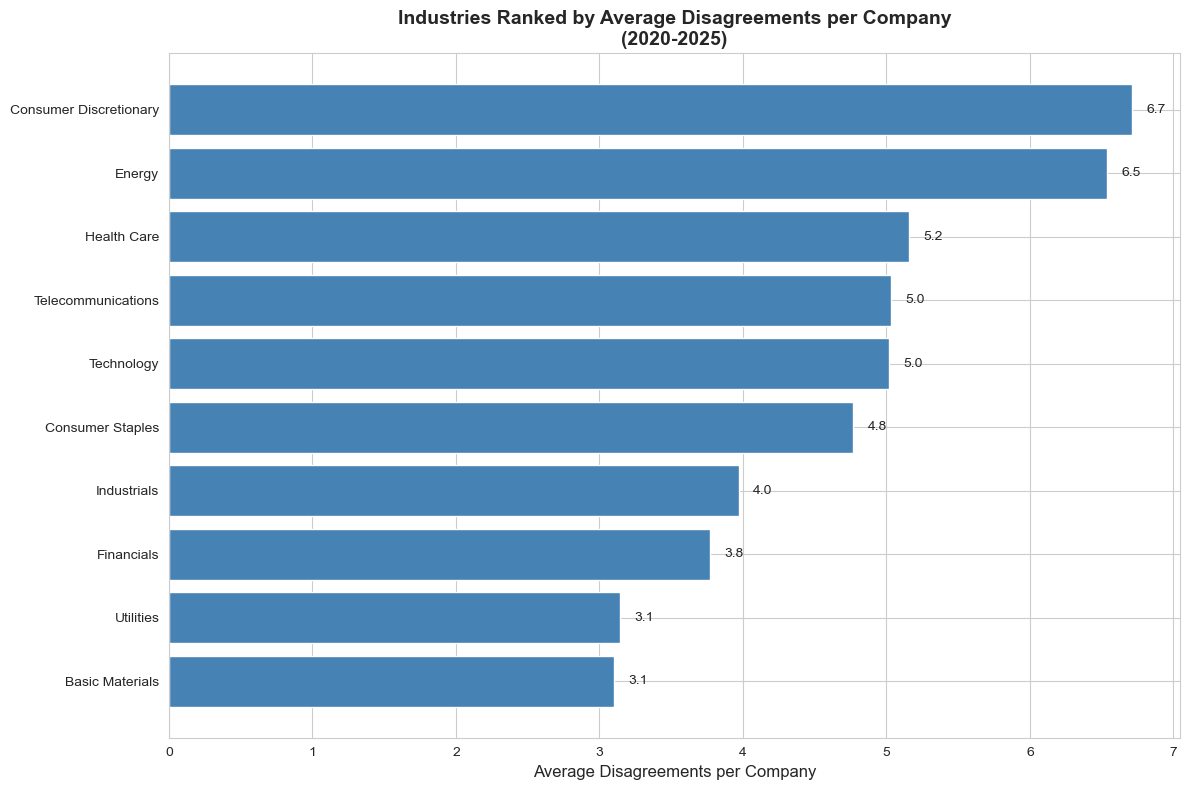

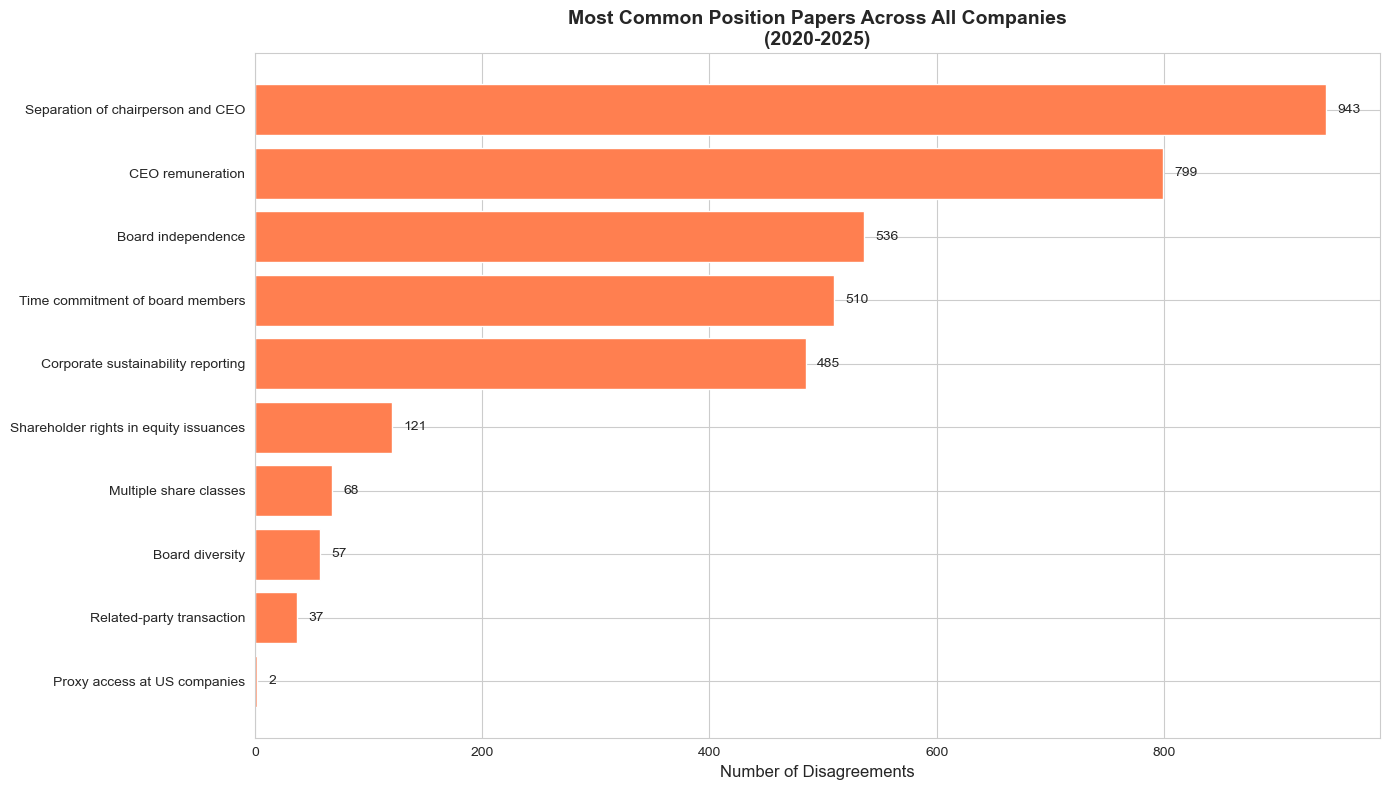

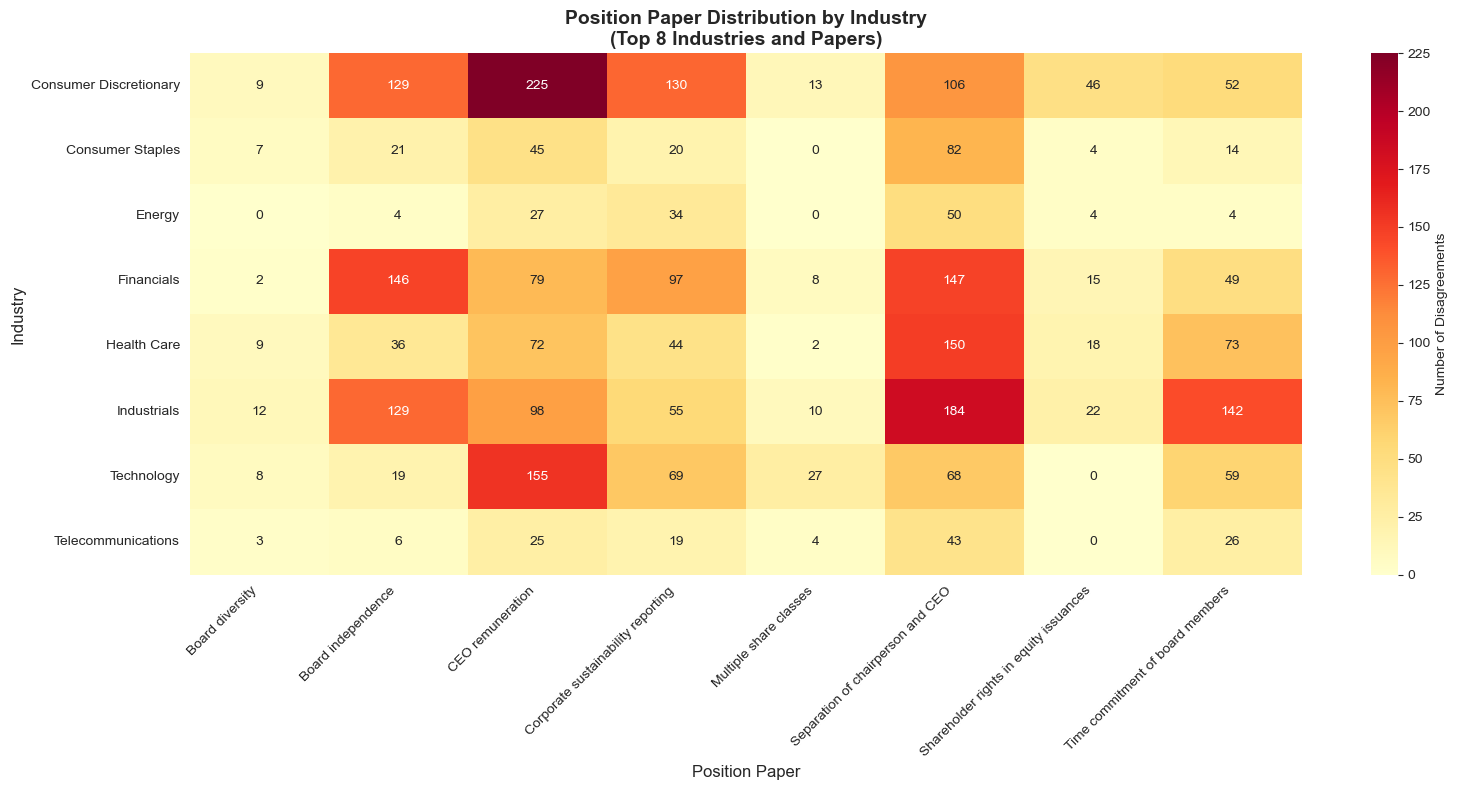

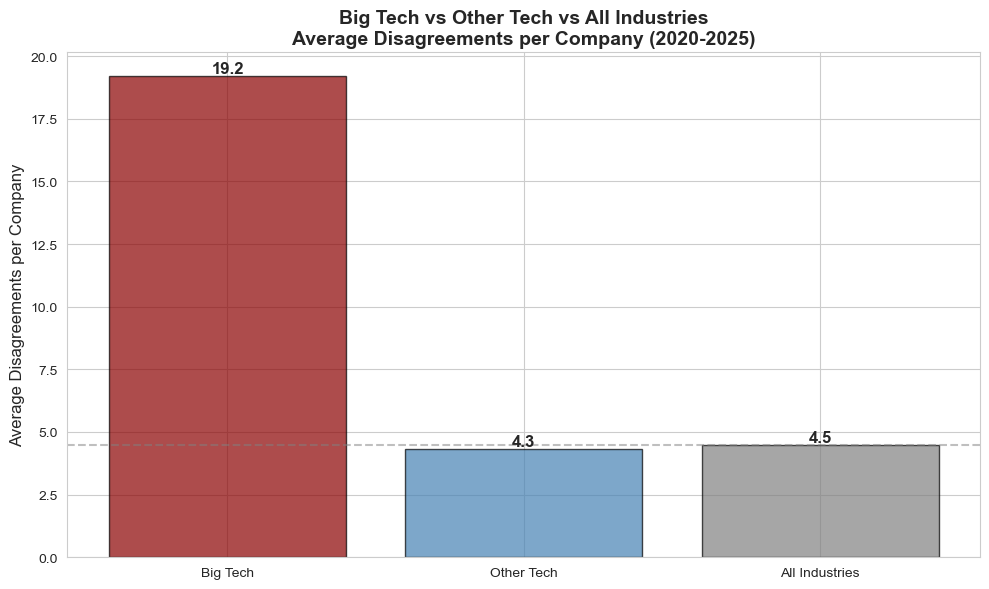

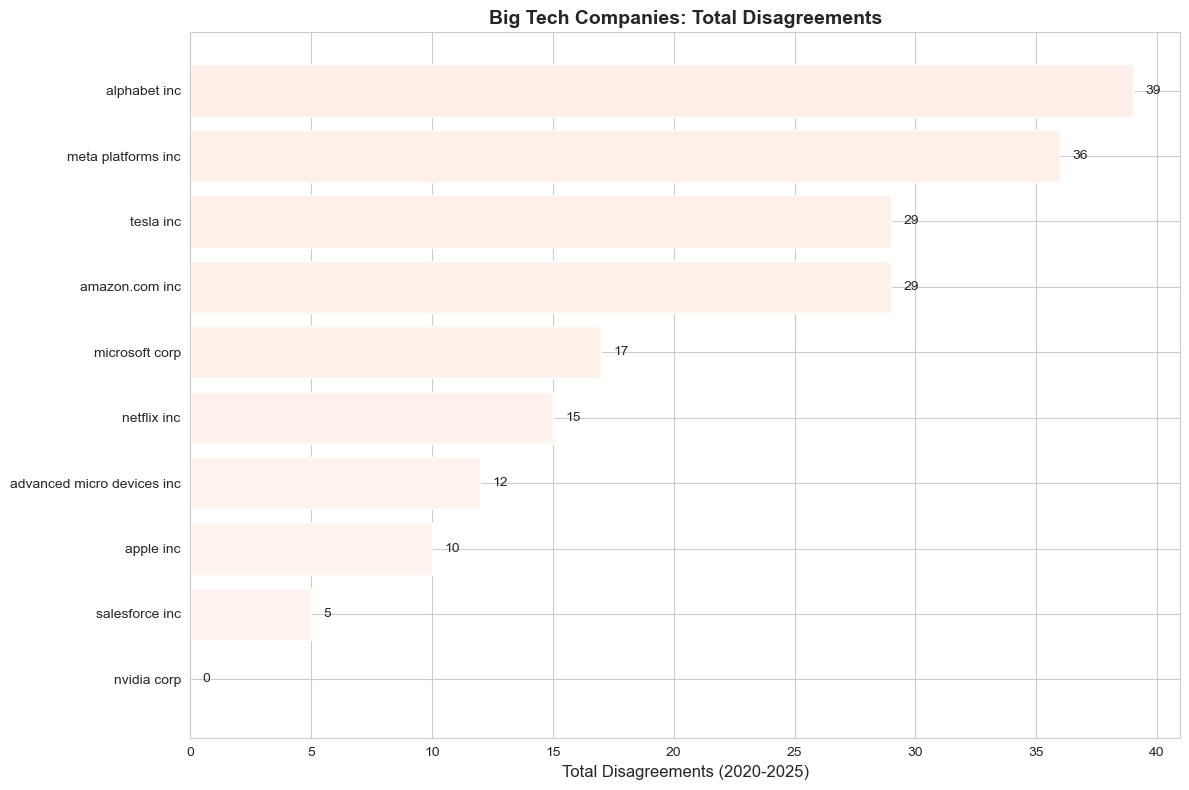

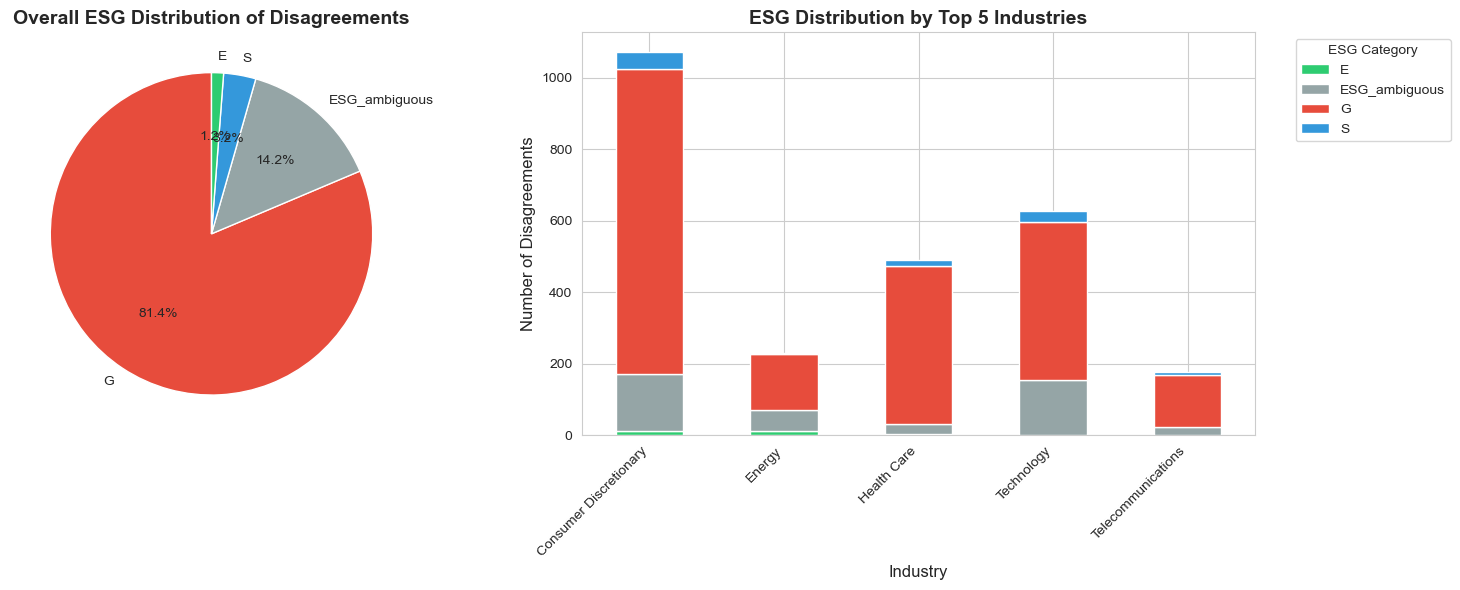


✓ All graphs generated successfully


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# =============================================================================
# GRAPH 1: Industries with Most Disagreements (Average)
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Get top 10 industries
top_industries = industry_stats.head(10)

ax.barh(top_industries.index, top_industries['Avg_per_Company'], color='steelblue')
ax.set_xlabel('Average Disagreements per Company', fontsize=12)
ax.set_title('Industries Ranked by Average Disagreements per Company\n(2020-2025)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, v in enumerate(top_industries['Avg_per_Company']):
    ax.text(v + 0.1, i, f'{v:.1f}', va='center')

plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 2: Most Repeated Position Papers
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Top 10 position papers
top_papers = df_classified['position_paper'].value_counts().head(10)

ax.barh(range(len(top_papers)), top_papers.values, color='coral')
ax.set_yticks(range(len(top_papers)))
ax.set_yticklabels([paper.replace('Position paper: ', '') for paper in top_papers.index], 
                    fontsize=10)
ax.set_xlabel('Number of Disagreements', fontsize=12)
ax.set_title('Most Common Position Papers Across All Companies\n(2020-2025)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, v in enumerate(top_papers.values):
    ax.text(v + 10, i, f'{v}', va='center')

plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 3: Top Position Papers by Industry (Heatmap)
# =============================================================================

# Create pivot table: Industry x Position Paper
industry_paper_pivot = df_classified_with_industry.groupby(
    ['Industry', 'position_paper']
).size().reset_index(name='count')

# Get top 8 industries and top 8 papers
top_8_industries = industry_stats.head(8).index.tolist()
top_8_papers = df_classified['position_paper'].value_counts().head(8).index.tolist()

# Filter and pivot
pivot_filtered = industry_paper_pivot[
    (industry_paper_pivot['Industry'].isin(top_8_industries)) &
    (industry_paper_pivot['position_paper'].isin(top_8_papers))
]

pivot_table = pivot_filtered.pivot(
    index='Industry', 
    columns='position_paper', 
    values='count'
).fillna(0)

# Shorten column names
pivot_table.columns = [col.replace('Position paper: ', '') for col in pivot_table.columns]

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Disagreements'}, ax=ax)
ax.set_title('Position Paper Distribution by Industry\n(Top 8 Industries and Papers)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Position Paper', fontsize=12)
ax.set_ylabel('Industry', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 4: Big Tech vs Other Tech vs All Industries
# =============================================================================

# Calculate averages
big_tech_avg = big_tech_stats['total_disagreements'].mean()
other_tech = df_analysis[
    (df_analysis['Industry'] == 'Technology') & 
    (~df_analysis['company_name'].isin(big_tech_names))
]
other_tech_avg = other_tech['total_disagreements'].mean()
all_industries_avg = df_analysis['total_disagreements'].mean()

fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Big Tech', 'Other Tech', 'All Industries']
averages = [big_tech_avg, other_tech_avg, all_industries_avg]
colors = ['darkred', 'steelblue', 'gray']

bars = ax.bar(categories, averages, color=colors, alpha=0.7, edgecolor='black')

ax.set_ylabel('Average Disagreements per Company', fontsize=12)
ax.set_title('Big Tech vs Other Tech vs All Industries\nAverage Disagreements per Company (2020-2025)', 
             fontsize=14, fontweight='bold')
ax.axhline(y=all_industries_avg, color='gray', linestyle='--', alpha=0.5, 
           label=f'Overall Average: {all_industries_avg:.1f}')

# Add value labels
for bar, avg in zip(bars, averages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{avg:.1f}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 5: Individual Big Tech Companies
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

big_tech_sorted = big_tech_stats.sort_values('total_disagreements', ascending=True)

colors_gradient = plt.cm.Reds(range(len(big_tech_sorted)))
ax.barh(big_tech_sorted['company_name'], 
        big_tech_sorted['total_disagreements'], 
        color=colors_gradient)

ax.set_xlabel('Total Disagreements (2020-2025)', fontsize=12)
ax.set_title('Big Tech Companies: Total Disagreements', 
             fontsize=14, fontweight='bold')

# Add value labels
for i, v in enumerate(big_tech_sorted['total_disagreements']):
    ax.text(v + 0.5, i, f'{int(v)}', va='center')

plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 6: ESG Category Distribution
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Overall ESG distribution
esg_counts = df_classified['esg_category'].value_counts()
colors_esg = {'E': '#2ecc71', 'S': '#3498db', 'G': '#e74c3c', 'ESG_ambiguous': '#95a5a6'}
colors_list = [colors_esg.get(cat, 'gray') for cat in esg_counts.index]

ax1.pie(esg_counts.values, labels=esg_counts.index, autopct='%1.1f%%',
        colors=colors_list, startangle=90)
ax1.set_title('Overall ESG Distribution of Disagreements', 
              fontsize=14, fontweight='bold')

# ESG by top 5 industries
top_5_industries = industry_stats.head(5).index
esg_by_industry = df_classified_with_industry[
    df_classified_with_industry['Industry'].isin(top_5_industries)
].groupby(['Industry', 'esg_category']).size().unstack(fill_value=0)

esg_by_industry.plot(kind='bar', stacked=True, ax=ax2, 
                      color=[colors_esg.get(col, 'gray') for col in esg_by_industry.columns])
ax2.set_title('ESG Distribution by Top 5 Industries', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Industry', fontsize=12)
ax2.set_ylabel('Number of Disagreements', fontsize=12)
ax2.legend(title='ESG Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n✓ All graphs generated successfully")

## Exploration of the disagreements

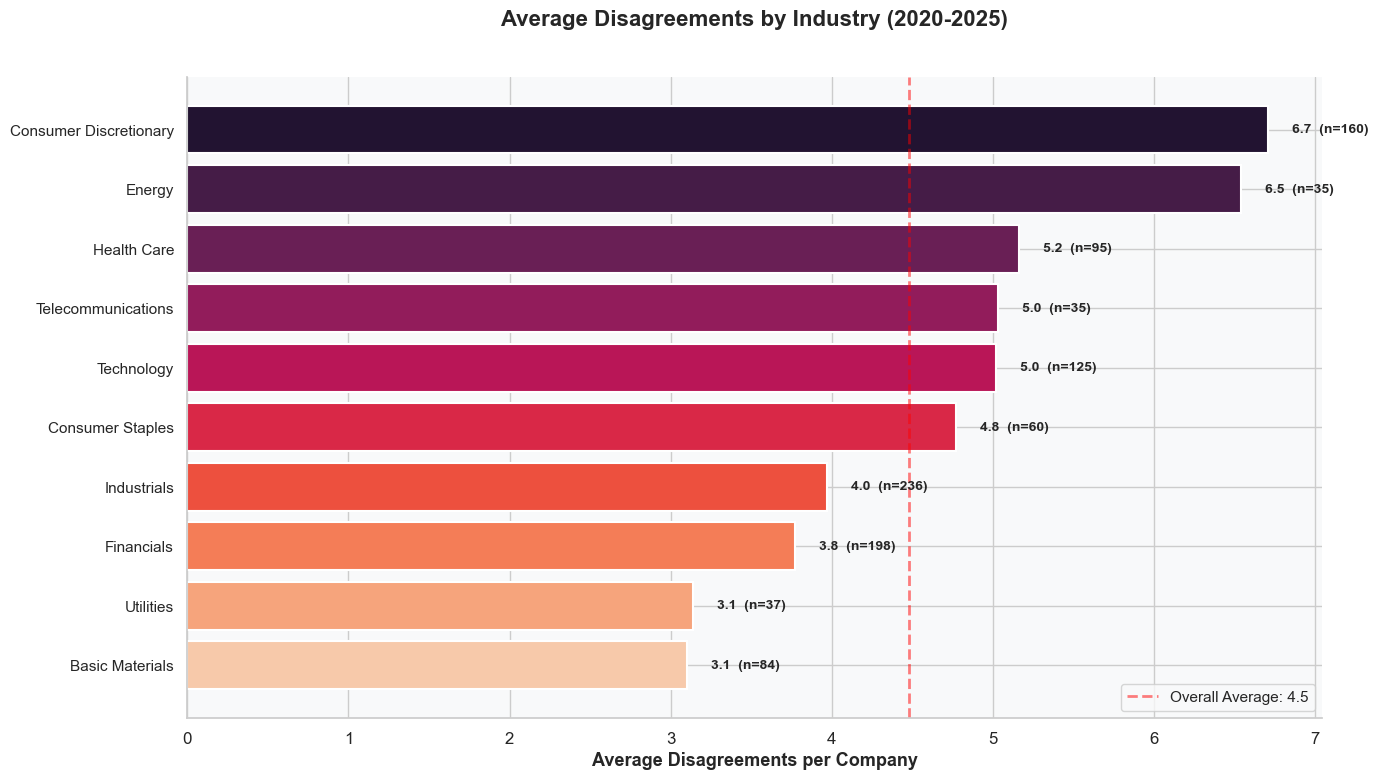

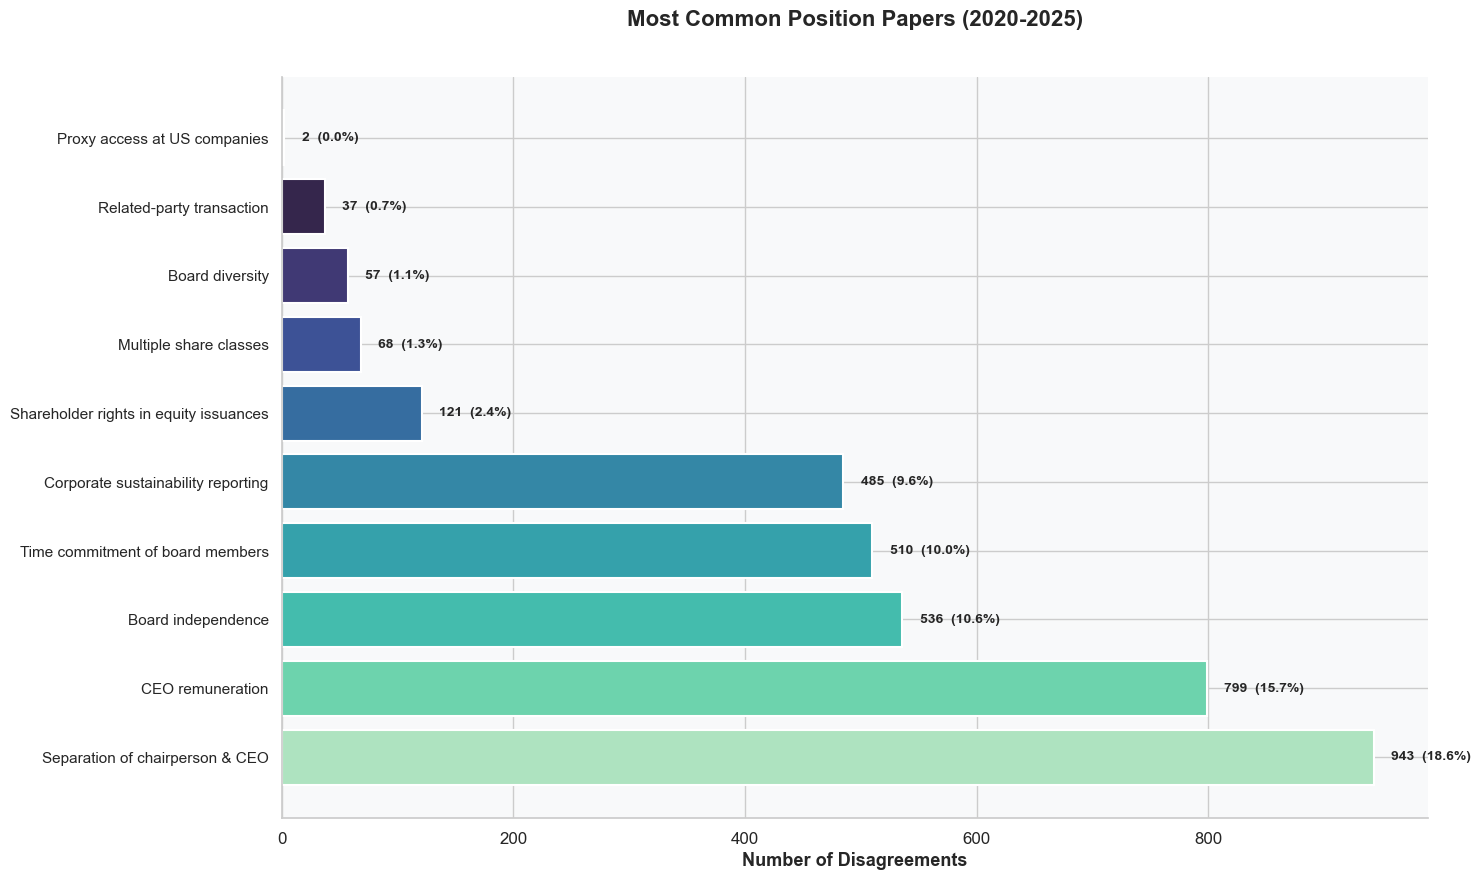

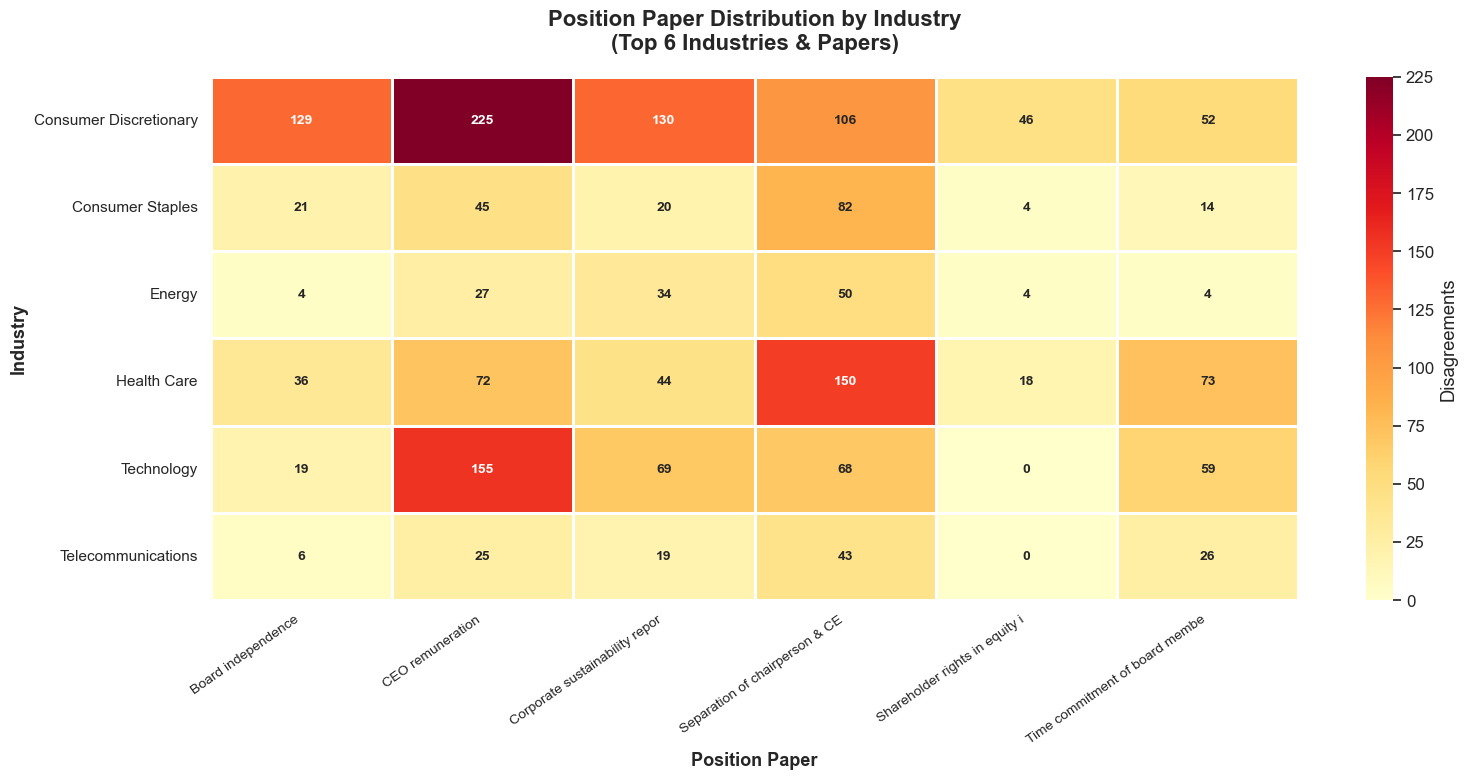

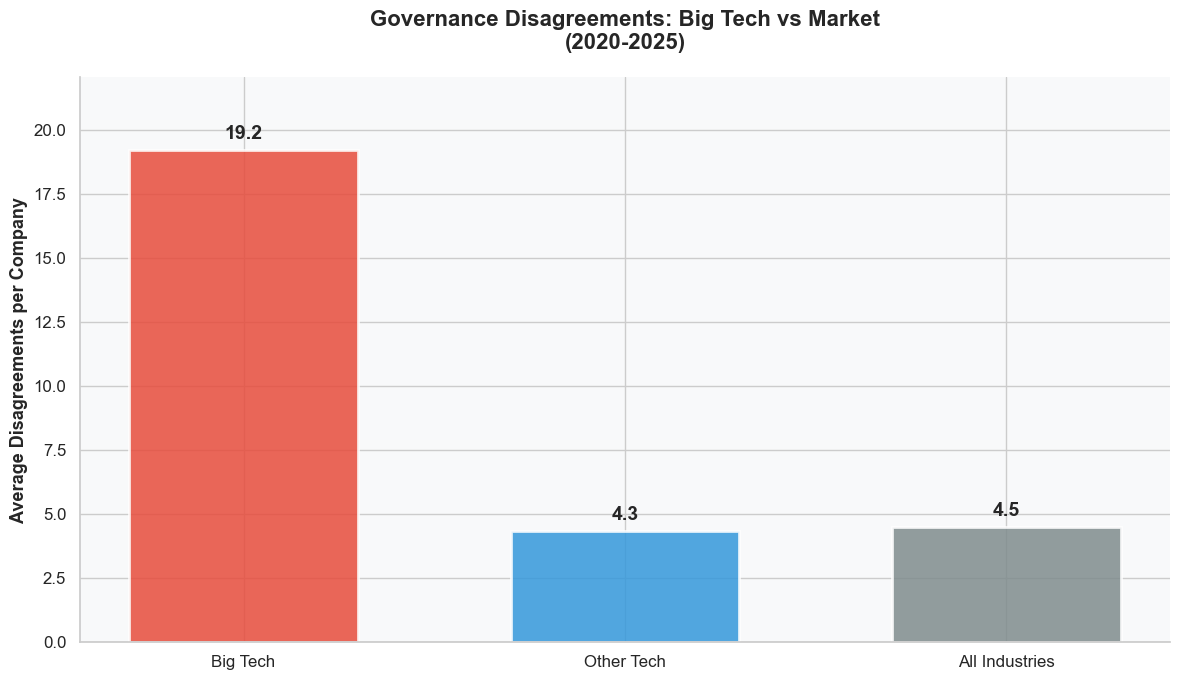

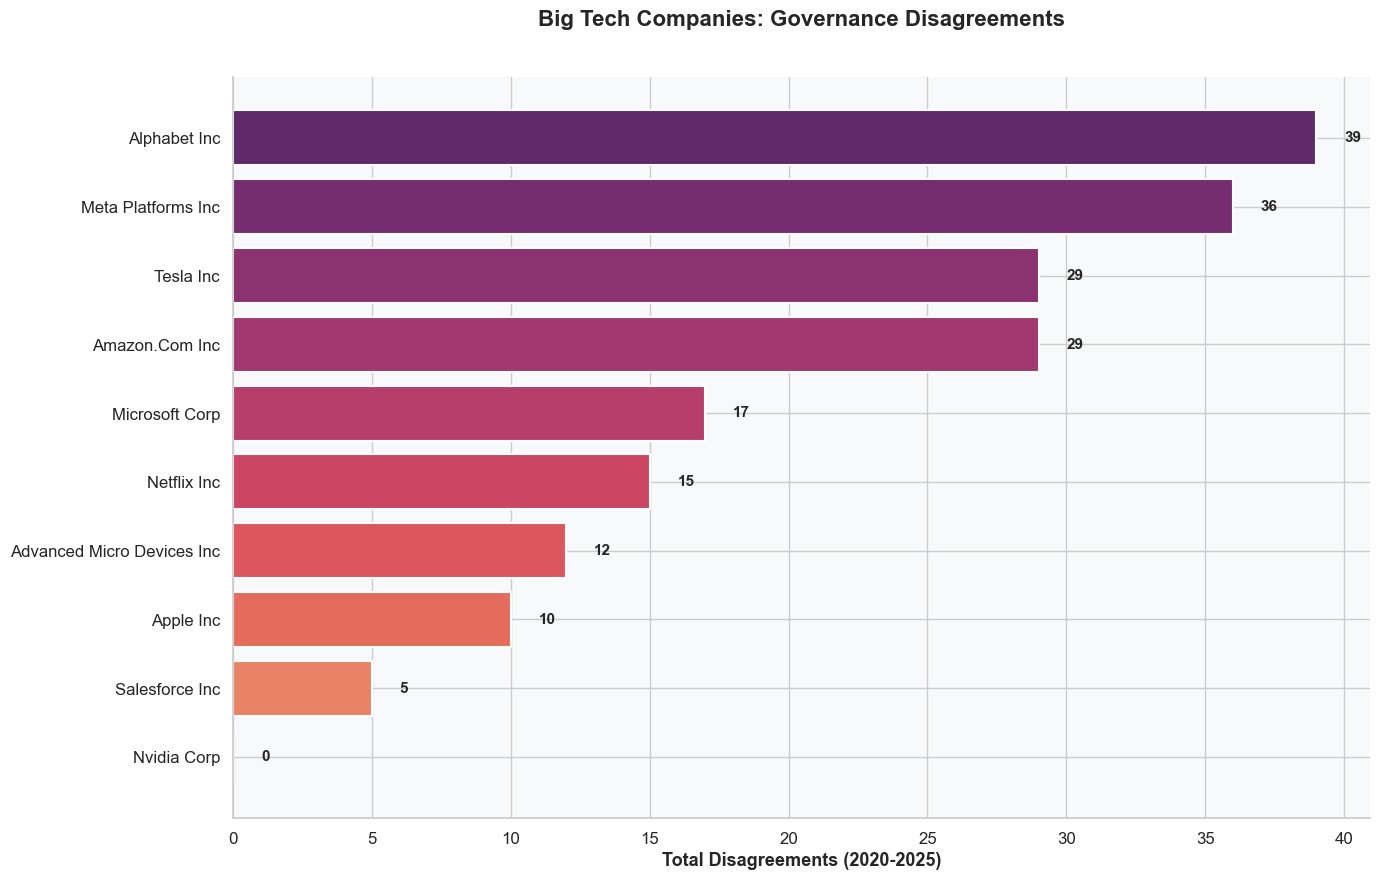

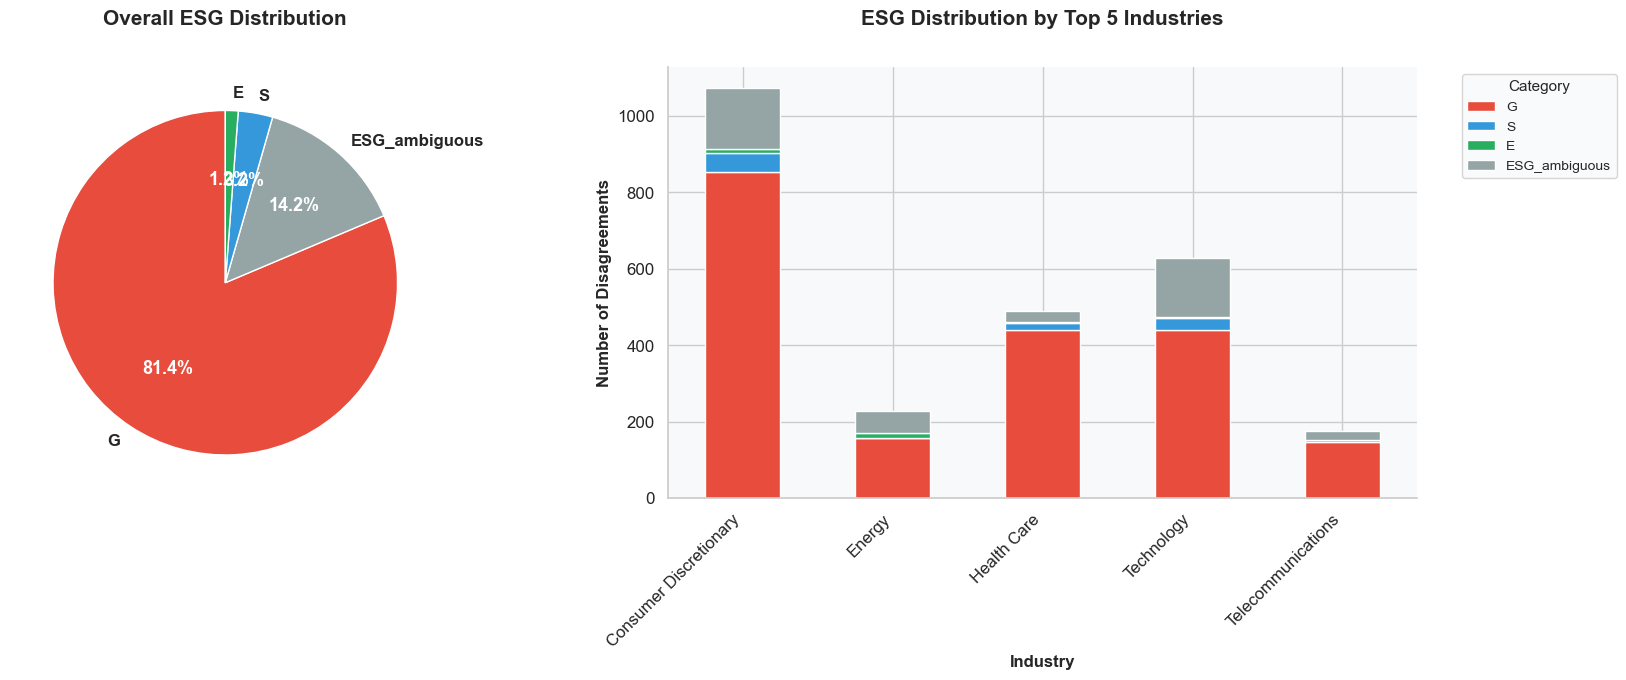

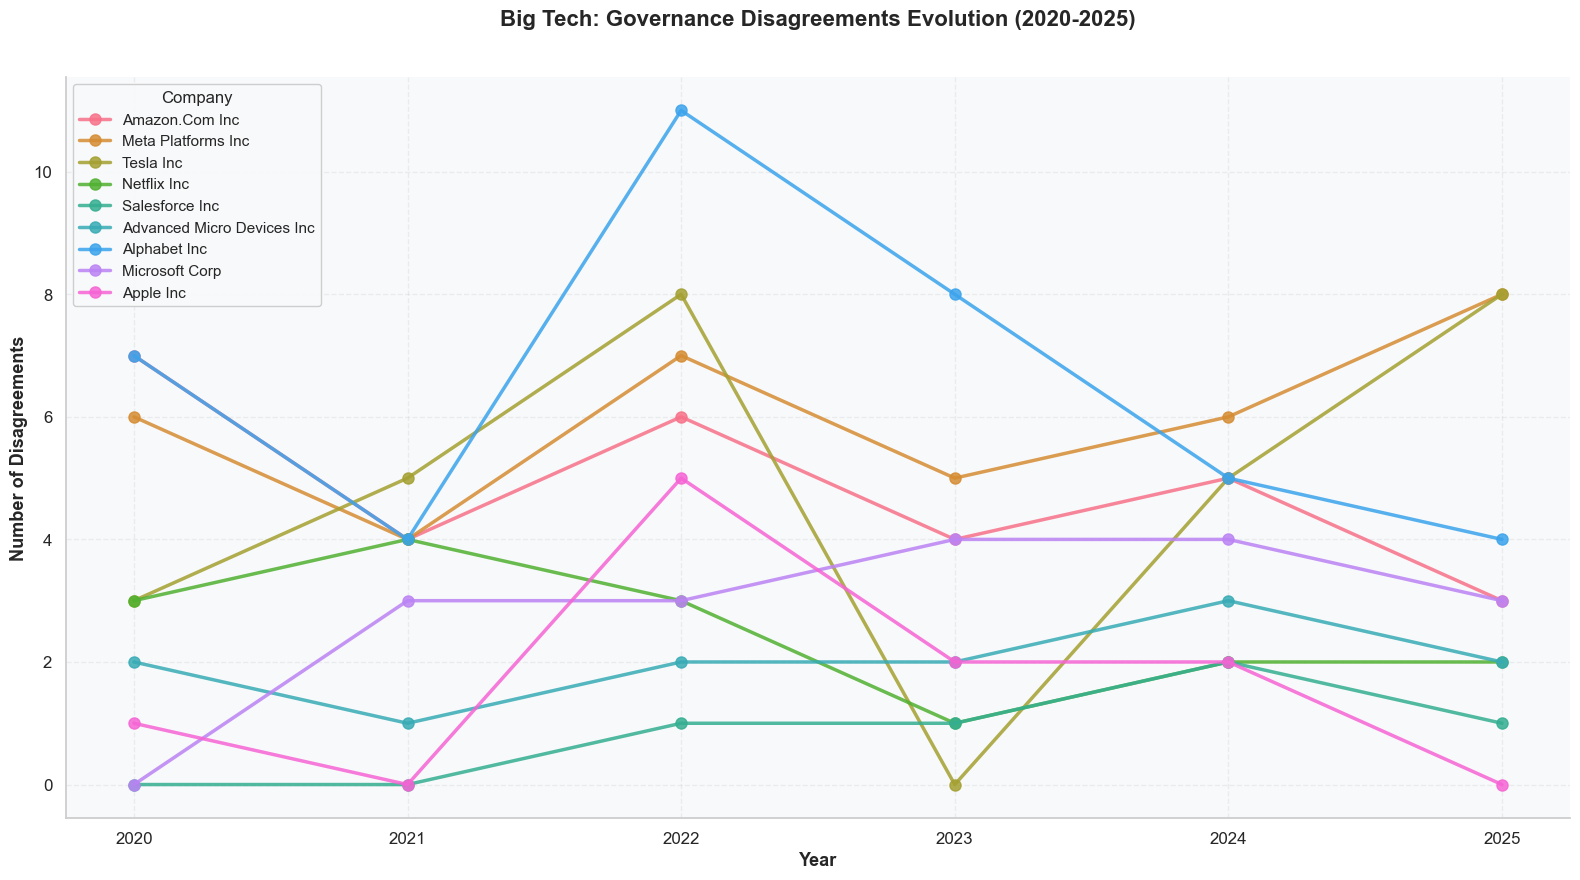


BIG TECH DISAGREEMENTS BY YEAR
      Total  Average_per_Company
year                            
2020     29                  2.9
2021     25                  2.5
2022     46                  4.6
2023     27                  2.7
2024     34                  3.4
2025     31                  3.1

✓ All enhanced graphs generated successfully


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set professional style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['font.family'] = 'sans-serif'

# Color palettes
colors_main = sns.color_palette("husl", 10)
colors_tech = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

# =============================================================================
# GRAPH 1: Industries by Average Disagreements (Enhanced)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

top_industries = industry_stats.head(10).sort_values('Avg_per_Company')
colors_gradient = sns.color_palette("rocket_r", len(top_industries))

bars = ax.barh(range(len(top_industries)), top_industries['Avg_per_Company'], 
               color=colors_gradient, edgecolor='white', linewidth=1.5)

ax.set_yticks(range(len(top_industries)))
ax.set_yticklabels(top_industries.index, fontsize=11)
ax.set_xlabel('Average Disagreements per Company', fontsize=13, fontweight='bold')
ax.set_title('Average Disagreements by Industry (2020-2025)\n', 
             fontsize=16, fontweight='bold', pad=20)

# Add value labels with company count
for i, (idx, row) in enumerate(top_industries.iterrows()):
    ax.text(row['Avg_per_Company'] + 0.15, i, 
            f"{row['Avg_per_Company']:.1f}  (n={int(row['N_Companies'])})",
            va='center', fontsize=10, fontweight='bold')

# Add vertical line for overall average
overall_avg = df_analysis['total_disagreements'].mean()
ax.axvline(overall_avg, color='red', linestyle='--', linewidth=2, alpha=0.5,
           label=f'Overall Average: {overall_avg:.1f}')
ax.legend(loc='lower right', fontsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 2: Top Position Papers (Enhanced)
# =============================================================================

fig, ax = plt.subplots(figsize=(15, 9))

top_papers = df_classified['position_paper'].value_counts().head(10)
# Clean names
paper_names = [p.replace('Position paper: ', '').replace('and', '&') for p in top_papers.index]

colors_papers = sns.color_palette("mako_r", len(top_papers))
bars = ax.barh(range(len(top_papers)), top_papers.values, 
               color=colors_papers, edgecolor='white', linewidth=1.5)

ax.set_yticks(range(len(top_papers)))
ax.set_yticklabels(paper_names, fontsize=11)
ax.set_xlabel('Number of Disagreements', fontsize=13, fontweight='bold')
ax.set_title('Most Common Position Papers (2020-2025)\n', 
             fontsize=16, fontweight='bold', pad=20)

# Add value labels with percentage
for i, (count, pct) in enumerate(zip(top_papers.values, 
                                      (top_papers.values/len(df_classified)*100))):
    ax.text(count + 15, i, f'{count}  ({pct:.1f}%)',
            va='center', fontsize=10, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 3: Position Papers by Industry (Enhanced Heatmap)
# =============================================================================

# Prepare data
top_6_industries = industry_stats.head(6).index.tolist()
top_6_papers = df_classified['position_paper'].value_counts().head(6).index.tolist()

pivot_filtered = df_classified_with_industry[
    (df_classified_with_industry['Industry'].isin(top_6_industries)) &
    (df_classified_with_industry['position_paper'].isin(top_6_papers))
].groupby(['Industry', 'position_paper']).size().reset_index(name='count')

pivot_table = pivot_filtered.pivot(
    index='Industry', 
    columns='position_paper', 
    values='count'
).fillna(0)

# Shorten names
pivot_table.columns = [col.replace('Position paper: ', '').replace(' and ', ' & ')[:30] 
                       for col in pivot_table.columns]

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Disagreements'}, ax=ax, linewidths=1,
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})

ax.set_title('Position Paper Distribution by Industry\n(Top 6 Industries & Papers)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Position Paper', fontsize=13, fontweight='bold')
ax.set_ylabel('Industry', fontsize=13, fontweight='bold')
plt.xticks(rotation=35, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 4: Big Tech Comparison (Enhanced)
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

categories = ['Big Tech', 'Other Tech', 'All Industries']
averages = [big_tech_avg, other_tech_avg, all_industries_avg]
colors_compare = ['#e74c3c', '#3498db', '#7f8c8d']

bars = ax.bar(categories, averages, color=colors_compare, alpha=0.85, 
              edgecolor='white', linewidth=2, width=0.6)

ax.set_ylabel('Average Disagreements per Company', fontsize=13, fontweight='bold')
ax.set_title('Governance Disagreements: Big Tech vs Market\n(2020-2025)', 
             fontsize=16, fontweight='bold', pad=20)

# Add value labels
for bar, avg in zip(bars, averages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{avg:.1f}',
            ha='center', va='bottom', fontweight='bold', fontsize=14)

ax.set_ylim(0, max(averages) * 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 5: Individual Big Tech Companies (Enhanced)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 9))

big_tech_sorted = big_tech_stats.sort_values('total_disagreements', ascending=True)
colors_tech_gradient = sns.color_palette("flare", len(big_tech_sorted))

bars = ax.barh(range(len(big_tech_sorted)), 
               big_tech_sorted['total_disagreements'], 
               color=colors_tech_gradient, edgecolor='white', linewidth=1.5)

ax.set_yticks(range(len(big_tech_sorted)))
ax.set_yticklabels([name.title() for name in big_tech_sorted['company_name']], 
                    fontsize=12)
ax.set_xlabel('Total Disagreements (2020-2025)', fontsize=13, fontweight='bold')
ax.set_title('Big Tech Companies: Governance Disagreements\n', 
             fontsize=16, fontweight='bold', pad=20)

# Add value labels
for i, v in enumerate(big_tech_sorted['total_disagreements']):
    ax.text(v + 1, i, f'{int(v)}', va='center', fontsize=11, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 6: ESG Distribution (Enhanced)
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Pie chart
esg_counts = df_classified['esg_category'].value_counts()
colors_esg = {'E': '#27ae60', 'S': '#3498db', 'G': '#e74c3c', 'ESG_ambiguous': '#95a5a6'}
colors_list = [colors_esg.get(cat, 'gray') for cat in esg_counts.index]

wedges, texts, autotexts = ax1.pie(esg_counts.values, labels=esg_counts.index, 
                                     autopct='%1.1f%%', colors=colors_list, 
                                     startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')

ax1.set_title('Overall ESG Distribution\n', fontsize=15, fontweight='bold', pad=15)

# Stacked bar
top_5_ind = industry_stats.head(5).index
esg_by_ind = df_classified_with_industry[
    df_classified_with_industry['Industry'].isin(top_5_ind)
].groupby(['Industry', 'esg_category']).size().unstack(fill_value=0)

esg_by_ind = esg_by_ind.reindex(columns=['G', 'S', 'E', 'ESG_ambiguous'], fill_value=0)
esg_by_ind.plot(kind='bar', stacked=True, ax=ax2, 
                color=[colors_esg.get(col, 'gray') for col in esg_by_ind.columns],
                edgecolor='white', linewidth=1)

ax2.set_title('ESG Distribution by Top 5 Industries\n', fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('Industry', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Disagreements', fontsize=12, fontweight='bold')
ax2.legend(title='Category', title_fontsize=11, fontsize=10, 
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 7: BIG TECH TEMPORAL EVOLUTION (NEW)
# =============================================================================

# Extract year from meeting_date
df_classified['year'] = pd.to_datetime(df_classified['meeting_date']).dt.year

# Filter big tech disagreements
big_tech_temporal = df_classified[
    df_classified['company_name'].isin(big_tech_names)
].copy()

# Count by company and year
temporal_pivot = big_tech_temporal.groupby(
    ['company_name', 'year']
).size().reset_index(name='disagreements')

# Create complete year range for each company
years = range(2020, 2026)
complete_data = []
for company in big_tech_names:
    for year in years:
        existing = temporal_pivot[
            (temporal_pivot['company_name'] == company) & 
            (temporal_pivot['year'] == year)
        ]
        if len(existing) > 0:
            complete_data.append({
                'company_name': company,
                'year': year,
                'disagreements': existing['disagreements'].values[0]
            })
        else:
            complete_data.append({
                'company_name': company,
                'year': year,
                'disagreements': 0
            })

df_temporal = pd.DataFrame(complete_data)

fig, ax = plt.subplots(figsize=(16, 9))

# Plot line for each company
companies_in_data = df_temporal[df_temporal['disagreements'] > 0]['company_name'].unique()
colors_lines = sns.color_palette("husl", len(companies_in_data))

for i, company in enumerate(companies_in_data):
    company_data = df_temporal[df_temporal['company_name'] == company]
    ax.plot(company_data['year'], company_data['disagreements'], 
            marker='o', linewidth=2.5, markersize=8, label=company.title(),
            color=colors_lines[i], alpha=0.85)

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Disagreements', fontsize=13, fontweight='bold')
ax.set_title('Big Tech: Governance Disagreements Evolution (2020-2025)\n', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(title='Company', title_fontsize=12, fontsize=11, 
          loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(years)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics by year
print("\n" + "="*70)
print("BIG TECH DISAGREEMENTS BY YEAR")
print("="*70)
year_summary = df_temporal.groupby('year')['disagreements'].agg(['sum', 'mean']).round(2)
year_summary.columns = ['Total', 'Average_per_Company']
print(year_summary)

print("\n✓ All enhanced graphs generated successfully")

## More analysis

In [26]:
# =============================================================================
# ANALYSIS 1: KEY NARRATIVE STATISTICS
# =============================================================================

print("="*70)
print("KEY NARRATIVE STATISTICS")
print("="*70)

# 1.1 Tech multiplier vs overall
tech_avg = df_analysis[df_analysis['Industry'] == 'Technology']['total_disagreements'].mean()
overall_avg = df_analysis['total_disagreements'].mean()
tech_multiplier = tech_avg / overall_avg

print(f"\n1. TECH SECTOR MULTIPLIER:")
print(f"   Tech average: {tech_avg:.1f} disagreements/company")
print(f"   Overall average: {overall_avg:.1f} disagreements/company")
print(f"   → Tech has {tech_multiplier:.2f}x more disagreements than market average")

# 1.2 What drives tech disagreements - top position papers
tech_disagreements = df_classified_with_industry[
    df_classified_with_industry['Industry'] == 'Technology'
]

tech_papers = tech_disagreements['position_paper'].value_counts()
tech_papers_pct = (tech_papers / len(tech_disagreements) * 100).round(1)

print(f"\n2. TECH DISAGREEMENTS BREAKDOWN:")
print(f"   Total tech disagreements: {len(tech_disagreements)}")
for i, (paper, count) in enumerate(tech_papers.head(5).items(), 1):
    pct = tech_papers_pct[paper]
    clean_name = paper.replace('Position paper: ', '') if pd.notna(paper) else 'No position paper'
    print(f"   {i}. {clean_name}: {count} ({pct:.1f}%)")

# Find CEO/Chair separation specifically
ceo_chair_sep = tech_disagreements[
    tech_disagreements['position_paper'] == 'Position paper: Separation of chairperson and CEO'
]
ceo_chair_pct = len(ceo_chair_sep) / len(tech_disagreements) * 100

print(f"\n   → CEO/Chair separation accounts for {ceo_chair_pct:.1f}% of tech disagreements")

# 1.3 Temporal persistence - "Cure rate"
# Companies that had disagreement in year X but not in year X+1 in same topic

df_classified['year'] = pd.to_datetime(df_classified['meeting_date']).dt.year

# Get unique company-year-topic combinations
company_year_topic = df_classified.groupby(
    ['company_name', 'year', 'position_paper']
).size().reset_index(name='count')

# For each company-topic pair, track years with disagreements
cure_analysis = []

for company in company_year_topic['company_name'].unique():
    company_data = company_year_topic[company_year_topic['company_name'] == company]
    
    for topic in company_data['position_paper'].unique():
        if pd.isna(topic):
            continue
            
        topic_years = sorted(company_data[company_data['position_paper'] == topic]['year'].tolist())
        
        if len(topic_years) >= 2:
            # Check for gaps (cure periods)
            for i in range(len(topic_years) - 1):
                year_current = topic_years[i]
                year_next = topic_years[i + 1]
                
                # If more than 1 year gap, consider it persistence
                if year_next - year_current > 1:
                    cure_analysis.append({
                        'company': company,
                        'topic': topic,
                        'first_year': year_current,
                        'status': 'cured'
                    })
                else:
                    cure_analysis.append({
                        'company': company,
                        'topic': topic,
                        'first_year': year_current,
                        'status': 'persistent'
                    })

df_cure = pd.DataFrame(cure_analysis)

if len(df_cure) > 0:
    cure_rate = (df_cure['status'] == 'cured').sum() / len(df_cure) * 100
    persistence_rate = (df_cure['status'] == 'persistent').sum() / len(df_cure) * 100
    
    print(f"\n3. TEMPORAL PERSISTENCE:")
    print(f"   Total company-topic pairs analyzed: {len(df_cure)}")
    print(f"   Cured (no repeat within 2 years): {(df_cure['status'] == 'cured').sum()} ({cure_rate:.1f}%)")
    print(f"   Persistent (repeated next year): {(df_cure['status'] == 'persistent').sum()} ({persistence_rate:.1f}%)")
else:
    print(f"\n3. TEMPORAL PERSISTENCE: Insufficient data for analysis")

print("\n" + "="*70)

KEY NARRATIVE STATISTICS

1. TECH SECTOR MULTIPLIER:
   Tech average: 5.0 disagreements/company
   Overall average: 4.5 disagreements/company
   → Tech has 1.12x more disagreements than market average

2. TECH DISAGREEMENTS BREAKDOWN:
   Total tech disagreements: 628
   1. CEO remuneration: 155 (24.7%)
   2. Corporate sustainability reporting: 69 (11.0%)
   3. Separation of chairperson and CEO: 68 (10.8%)
   4. Time commitment of board members: 59 (9.4%)
   5. Multiple share classes: 27 (4.3%)

   → CEO/Chair separation accounts for 10.8% of tech disagreements

3. TEMPORAL PERSISTENCE:
   Total company-topic pairs analyzed: 1490
   Cured (no repeat within 2 years): 201 (13.5%)
   Persistent (repeated next year): 1289 (86.5%)



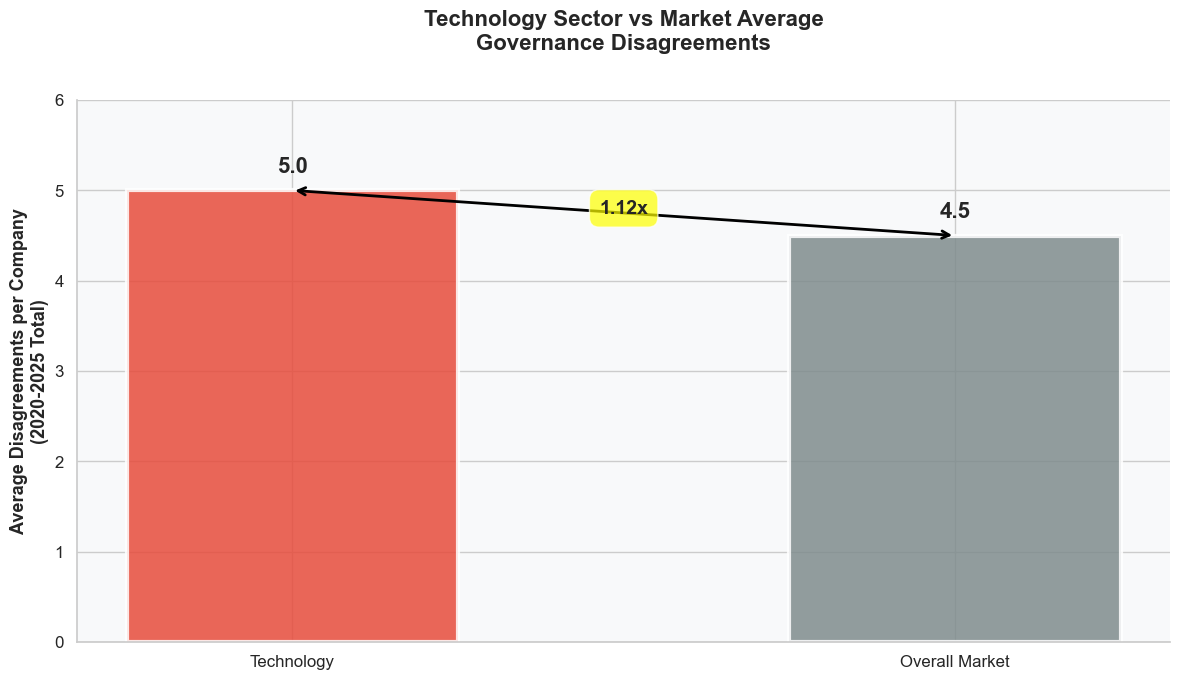

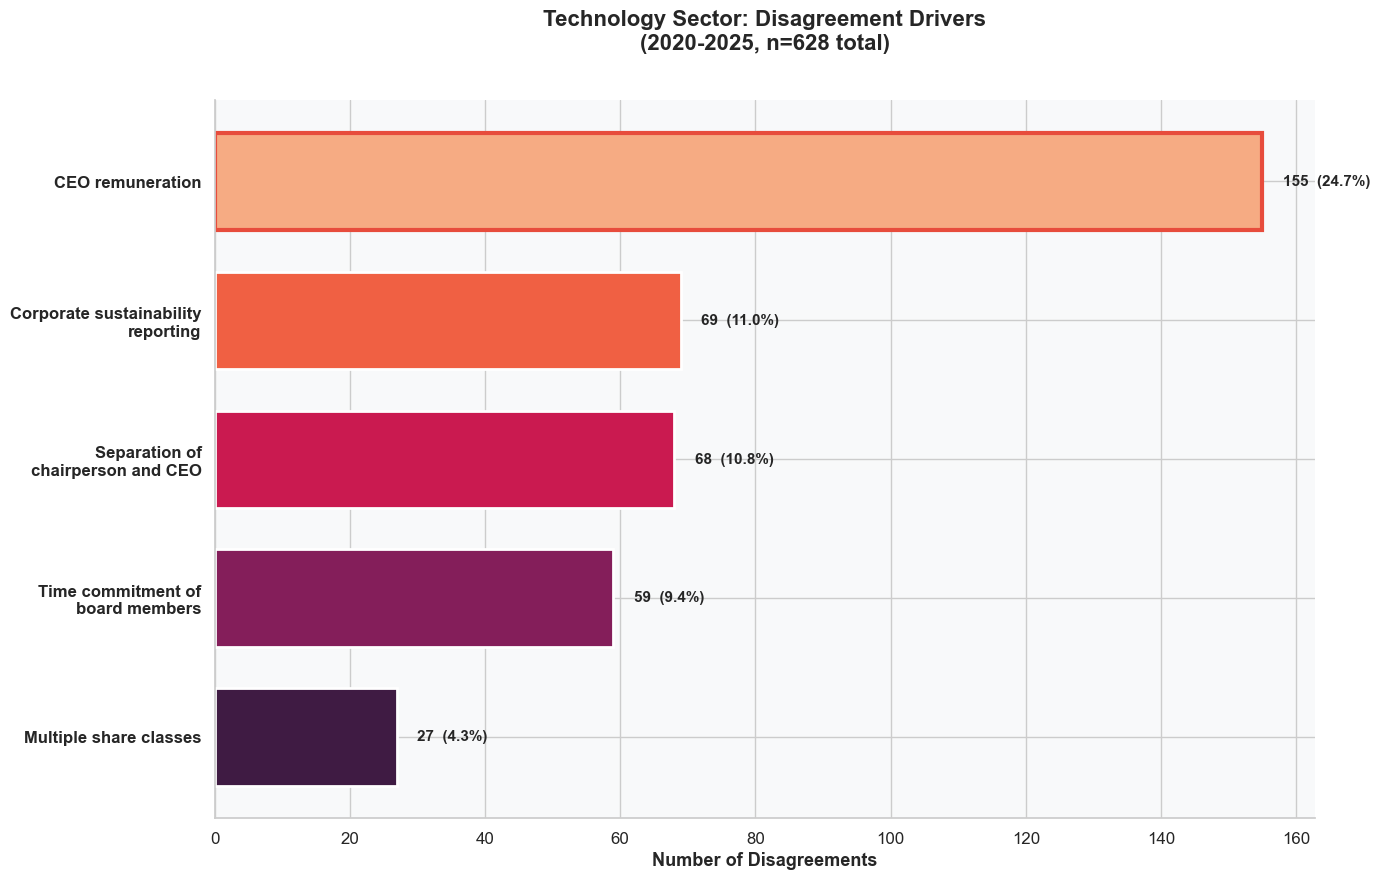

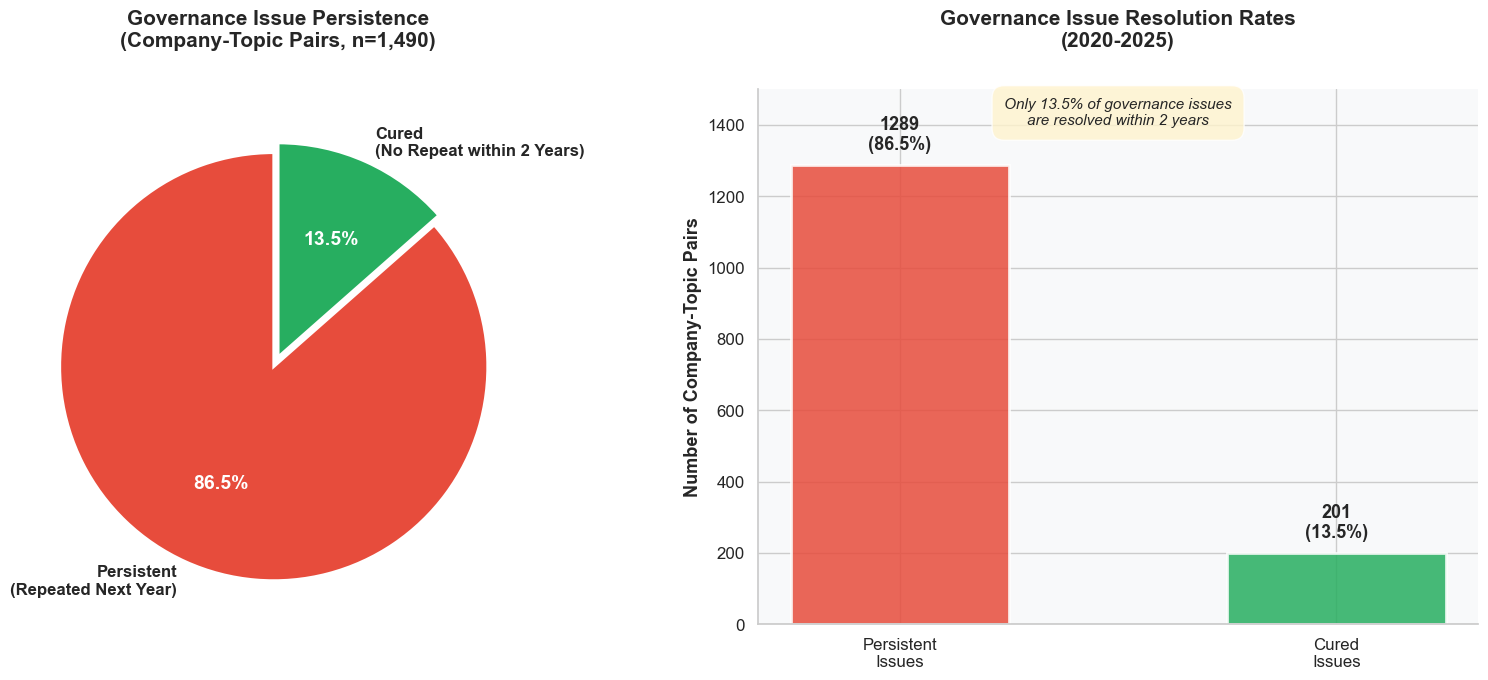


✓ All narrative graphs generated successfully


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set professional style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'

# =============================================================================
# GRAPH 1.1: TECH MULTIPLIER
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

categories = ['Technology', 'Overall Market']
values = [5.0, 4.5]
colors = ['#e74c3c', '#7f8c8d']

bars = ax.bar(categories, values, color=colors, alpha=0.85, 
              edgecolor='white', linewidth=3, width=0.5)

ax.set_ylabel('Average Disagreements per Company\n(2020-2025 Total)', 
              fontsize=13, fontweight='bold')
ax.set_title('Technology Sector vs Market Average\nGovernance Disagreements\n', 
             fontsize=16, fontweight='bold', pad=20)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.15,
            f'{val:.1f}',
            ha='center', va='bottom', fontweight='bold', fontsize=16)

# Add multiplier annotation
ax.annotate('', xy=(0, 5.0), xytext=(1, 4.5),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax.text(0.5, 4.8, '1.12x', ha='center', va='center', 
        fontsize=14, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.set_ylim(0, 6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 1.2: TECH DISAGREEMENTS BREAKDOWN
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 9))

# Data
papers = ['CEO remuneration', 'Corporate sustainability\nreporting', 
          'Separation of\nchairperson and CEO', 'Time commitment of\nboard members', 
          'Multiple share classes']
counts = [155, 69, 68, 59, 27]
percentages = [24.7, 11.0, 10.8, 9.4, 4.3]

# Create color gradient
colors_gradient = sns.color_palette("rocket_r", len(papers))

# Create horizontal bars
y_pos = np.arange(len(papers))
bars = ax.barh(y_pos, counts, color=colors_gradient, 
               edgecolor='white', linewidth=2, height=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(papers, fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Disagreements', fontsize=13, fontweight='bold')
ax.set_title('Technology Sector: Disagreement Drivers\n(2020-2025, n=628 total)\n', 
             fontsize=16, fontweight='bold', pad=20)

# Add value labels with percentages
for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(count + 3, i, f'{count}  ({pct}%)', 
            va='center', fontsize=11, fontweight='bold')

# Highlight CEO remuneration
ax.patches[0].set_edgecolor('#e74c3c')
ax.patches[0].set_linewidth(3)

ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 1.3: TEMPORAL PERSISTENCE
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: Pie chart
labels = ['Persistent\n(Repeated Next Year)', 'Cured\n(No Repeat within 2 Years)']
sizes = [86.5, 13.5]
colors_pie = ['#e74c3c', '#27ae60']
explode = (0.05, 0)

wedges, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, 
                                     autopct='%1.1f%%', startangle=90,
                                     colors=colors_pie, textprops={'fontsize': 12, 'fontweight': 'bold'},
                                     wedgeprops={'edgecolor': 'white', 'linewidth': 2})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

ax1.set_title('Governance Issue Persistence\n(Company-Topic Pairs, n=1,490)\n', 
              fontsize=15, fontweight='bold', pad=15)

# Right: Bar chart with context
categories_persist = ['Persistent\nIssues', 'Cured\nIssues']
values_persist = [1289, 201]
colors_bar = ['#e74c3c', '#27ae60']

bars = ax2.bar(categories_persist, values_persist, color=colors_bar, 
               alpha=0.85, edgecolor='white', linewidth=2, width=0.5)

ax2.set_ylabel('Number of Company-Topic Pairs', fontsize=13, fontweight='bold')
ax2.set_title('Governance Issue Resolution Rates\n(2020-2025)\n', 
              fontsize=15, fontweight='bold', pad=15)

# Add value labels
for bar, val in zip(bars, values_persist):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 30,
            f'{val}\n({val/1490*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=13)

# Add interpretation text
ax2.text(0.5, 1400, 
         'Only 13.5% of governance issues\nare resolved within 2 years',
         ha='center', fontsize=11, style='italic',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#fff3cd', alpha=0.8))

ax2.set_ylim(0, 1500)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n✓ All narrative graphs generated successfully")

In [30]:
# =============================================================================
# ANALYSIS 1: TEMPORAL PERSISTENCE - DEEP DIVE
# =============================================================================

print("="*70)
print("TEMPORAL PERSISTENCE: DEEP DIVE ANALYSIS")
print("="*70)

# Prepare data with year
df_classified['year'] = pd.to_datetime(df_classified['meeting_date']).dt.year

# =============================================================================
# 1.1 PERSISTENCE BY SECTOR
# =============================================================================

print("\n1. PERSISTENCE RATES BY SECTOR:")
print("-"*70)

# Get company-topic-year combinations by industry
df_with_industry = df_classified.merge(
    df_p80[['Name', 'Industry']], 
    left_on='company_name', 
    right_on='Name', 
    how='left'
)

persistence_by_sector = {}

for industry in industry_stats.head(8).index:
    industry_data = df_with_industry[df_with_industry['Industry'] == industry]
    
    # Track company-topic pairs
    company_topic_years = industry_data.groupby(
        ['company_name', 'position_paper', 'year']
    ).size().reset_index(name='count')
    
    # Calculate persistence
    cured = 0
    persistent = 0
    
    for company in company_topic_years['company_name'].unique():
        for topic in company_topic_years[company_topic_years['company_name'] == company]['position_paper'].unique():
            if pd.isna(topic):
                continue
            
            years = sorted(company_topic_years[
                (company_topic_years['company_name'] == company) & 
                (company_topic_years['position_paper'] == topic)
            ]['year'].tolist())
            
            if len(years) >= 2:
                for i in range(len(years) - 1):
                    if years[i+1] - years[i] > 1:
                        cured += 1
                    else:
                        persistent += 1
    
    total = cured + persistent
    if total > 0:
        cure_rate = cured / total * 100
        persistence_rate = persistent / total * 100
        persistence_by_sector[industry] = {
            'cured': cured,
            'persistent': persistent,
            'cure_rate': cure_rate,
            'persistence_rate': persistence_rate,
            'total': total
        }

# Sort by persistence rate
persistence_df = pd.DataFrame(persistence_by_sector).T.sort_values('persistence_rate', ascending=False)

for industry, row in persistence_df.iterrows():
    print(f"\n{industry}:")
    print(f"  Total pairs: {int(row['total'])}")
    print(f"  Persistent: {int(row['persistent'])} ({row['persistence_rate']:.1f}%)")
    print(f"  Cured: {int(row['cured'])} ({row['cure_rate']:.1f}%)")

# =============================================================================
# 1.2 PERSISTENCE BY ISSUE TYPE
# =============================================================================

print("\n\n2. PERSISTENCE RATES BY ISSUE TYPE:")
print("-"*70)

persistence_by_topic = {}

for topic in df_classified['position_paper'].value_counts().head(8).index:
    if pd.isna(topic):
        continue
    
    topic_data = df_classified[df_classified['position_paper'] == topic]
    
    company_years = topic_data.groupby(['company_name', 'year']).size().reset_index(name='count')
    
    cured = 0
    persistent = 0
    
    for company in company_years['company_name'].unique():
        years = sorted(company_years[company_years['company_name'] == company]['year'].tolist())
        
        if len(years) >= 2:
            for i in range(len(years) - 1):
                if years[i+1] - years[i] > 1:
                    cured += 1
                else:
                    persistent += 1
    
    total = cured + persistent
    if total > 0:
        clean_topic = topic.replace('Position paper: ', '')
        persistence_by_topic[clean_topic] = {
            'cured': cured,
            'persistent': persistent,
            'cure_rate': cured / total * 100,
            'persistence_rate': persistent / total * 100,
            'total': total
        }

persistence_topic_df = pd.DataFrame(persistence_by_topic).T.sort_values('persistence_rate', ascending=False)

for topic, row in persistence_topic_df.iterrows():
    print(f"\n{topic}:")
    print(f"  Total pairs: {int(row['total'])}")
    print(f"  Persistent: {int(row['persistent'])} ({row['persistence_rate']:.1f}%)")
    print(f"  Cured: {int(row['cured'])} ({row['cure_rate']:.1f}%)")

# =============================================================================
# 1.3 ESCALATION ANALYSIS
# =============================================================================

print("\n\n3. ESCALATION ANALYSIS:")
print("-"*70)

# Find companies with increasing disagreements over time
company_year_counts = df_classified.groupby(['company_name', 'year']).size().reset_index(name='disagreements')

escalation_analysis = []

for company in company_year_counts['company_name'].unique():
    company_data = company_year_counts[company_year_counts['company_name'] == company].sort_values('year')
    
    if len(company_data) >= 3:  # Need at least 3 years
        years = company_data['year'].tolist()
        counts = company_data['disagreements'].tolist()
        
        # Check if generally increasing
        increases = sum(1 for i in range(len(counts)-1) if counts[i+1] > counts[i])
        decreases = sum(1 for i in range(len(counts)-1) if counts[i+1] < counts[i])
        
        trend = 'escalating' if increases > decreases else 'improving' if decreases > increases else 'stable'
        
        escalation_analysis.append({
            'company': company,
            'years_tracked': len(years),
            'first_year_count': counts[0],
            'last_year_count': counts[-1],
            'trend': trend,
            'increases': increases,
            'decreases': decreases
        })

df_escalation = pd.DataFrame(escalation_analysis)

print(f"\nCompanies tracked 3+ years: {len(df_escalation)}")
print(f"\nTrend distribution:")
print(df_escalation['trend'].value_counts())

print(f"\n\nTop 10 ESCALATING companies:")
escalating = df_escalation[df_escalation['trend'] == 'escalating'].sort_values('last_year_count', ascending=False)
print(escalating.head(10)[['company', 'first_year_count', 'last_year_count', 'years_tracked']])

print(f"\n\nTop 10 IMPROVING companies:")
improving = df_escalation[df_escalation['trend'] == 'improving'].sort_values('first_year_count', ascending=False)
print(improving.head(10)[['company', 'first_year_count', 'last_year_count', 'years_tracked']])

# =============================================================================
# ANALYSIS 3: TECH SUB-ANALYSIS
# =============================================================================

print("\n\n" + "="*70)
print("TECH SECTOR: SUB-SEGMENT ANALYSIS")
print("="*70)

# Categorize tech companies
software = ['salesforce inc', 'servicenow inc', 'microsoft corp', 'oracle corp', 
            'palantir technologies inc', 'crowdstrike holdings inc']

hardware = ['apple inc', 'samsung electronics co ltd', 'nintendo co ltd',
            'hon hai precision industry co ltd']

semiconductors = ['nvidia corp', 'taiwan semiconductor manufacturing co ltd', 'asml holding nv',
                  'advanced micro devices inc', 'broadcom inc', 'micron technology inc',
                  'analog devices inc', 'sk hynix inc', 'applied materials inc',
                  'marvell technology inc', 'cadence design systems inc', 'mediatek inc']

social_media = ['meta platforms inc', 'alphabet inc', 'tencent holdings ltd']

ecommerce = ['amazon.com inc', 'alibaba group holding ltd']

# Analyze each subsegment
tech_subsegments = {
    'Software': software,
    'Hardware': hardware,
    'Semiconductors': semiconductors,
    'Social Media': social_media,
    'E-commerce': ecommerce
}

subsegment_results = {}

for segment, companies in tech_subsegments.items():
    segment_data = df_analysis[df_analysis['company_name'].isin(companies)]
    segment_disagreements = df_classified[df_classified['company_name'].isin(companies)]
    
    if len(segment_data) > 0:
        subsegment_results[segment] = {
            'n_companies': len(segment_data),
            'total_disagreements': segment_data['total_disagreements'].sum(),
            'avg_disagreements': segment_data['total_disagreements'].mean(),
            'companies_with_disagreements': (segment_data['total_disagreements'] > 0).sum(),
            'top_position_paper': segment_disagreements['position_paper'].value_counts().index[0] if len(segment_disagreements) > 0 else 'N/A'
        }

subsegment_df = pd.DataFrame(subsegment_results).T.sort_values('avg_disagreements', ascending=False)

print("\nTech Sub-segment Comparison:")
print(subsegment_df)

# =============================================================================
# ANALYSIS 6: POSITION PAPER EVOLUTION
# =============================================================================

print("\n\n" + "="*70)
print("POSITION PAPER EVOLUTION: 2020-2025")
print("="*70)

# Split into two periods
period_1 = df_classified[df_classified['year'].isin([2020, 2021, 2022])]
period_2 = df_classified[df_classified['year'].isin([2023, 2024, 2025])]

print("\nPERIOD 1 (2020-2022):")
print("-"*70)
period_1_papers = period_1['position_paper'].value_counts().head(10)
period_1_total = len(period_1)

for paper, count in period_1_papers.items():
    pct = count / period_1_total * 100
    clean_name = paper.replace('Position paper: ', '') if pd.notna(paper) else 'No position paper'
    print(f"{clean_name:50} {count:>4} ({pct:>5.1f}%)")

print("\n\nPERIOD 2 (2023-2025):")
print("-"*70)
period_2_papers = period_2['position_paper'].value_counts().head(10)
period_2_total = len(period_2)

for paper, count in period_2_papers.items():
    pct = count / period_2_total * 100
    clean_name = paper.replace('Position paper: ', '') if pd.notna(paper) else 'No position paper'
    print(f"{clean_name:50} {count:>4} ({pct:>5.1f}%)")

# Calculate changes
print("\n\nBIGGEST CHANGES (Period 2 vs Period 1):")
print("-"*70)

period_1_pct = (period_1_papers / period_1_total * 100).to_dict()
period_2_pct = (period_2_papers / period_2_total * 100).to_dict()

all_papers = set(list(period_1_pct.keys()) + list(period_2_pct.keys()))

changes = {}
for paper in all_papers:
    p1 = period_1_pct.get(paper, 0)
    p2 = period_2_pct.get(paper, 0)
    change = p2 - p1
    changes[paper] = change

sorted_changes = sorted(changes.items(), key=lambda x: abs(x[1]), reverse=True)

for paper, change in sorted_changes[:10]:
    clean_name = paper.replace('Position paper: ', '') if pd.notna(paper) else 'No position paper'
    direction = "↑" if change > 0 else "↓"
    print(f"{clean_name:50} {direction} {abs(change):>5.1f}pp")

print("\n" + "="*70)

TEMPORAL PERSISTENCE: DEEP DIVE ANALYSIS

1. PERSISTENCE RATES BY SECTOR:
----------------------------------------------------------------------

Energy:
  Total pairs: 59
  Persistent: 55 (93.2%)
  Cured: 4 (6.8%)

Financials:
  Total pairs: 212
  Persistent: 190 (89.6%)
  Cured: 22 (10.4%)

Technology:
  Total pairs: 181
  Persistent: 162 (89.5%)
  Cured: 19 (10.5%)

Consumer Staples:
  Total pairs: 85
  Persistent: 74 (87.1%)
  Cured: 11 (12.9%)

Industrials:
  Total pairs: 277
  Persistent: 236 (85.2%)
  Cured: 41 (14.8%)

Health Care:
  Total pairs: 173
  Persistent: 145 (83.8%)
  Cured: 28 (16.2%)

Consumer Discretionary:
  Total pairs: 289
  Persistent: 240 (83.0%)
  Cured: 49 (17.0%)

Telecommunications:
  Total pairs: 59
  Persistent: 48 (81.4%)
  Cured: 11 (18.6%)


2. PERSISTENCE RATES BY ISSUE TYPE:
----------------------------------------------------------------------

Multiple share classes:
  Total pairs: 30
  Persistent: 28 (93.3%)
  Cured: 2 (6.7%)

Separation of chair

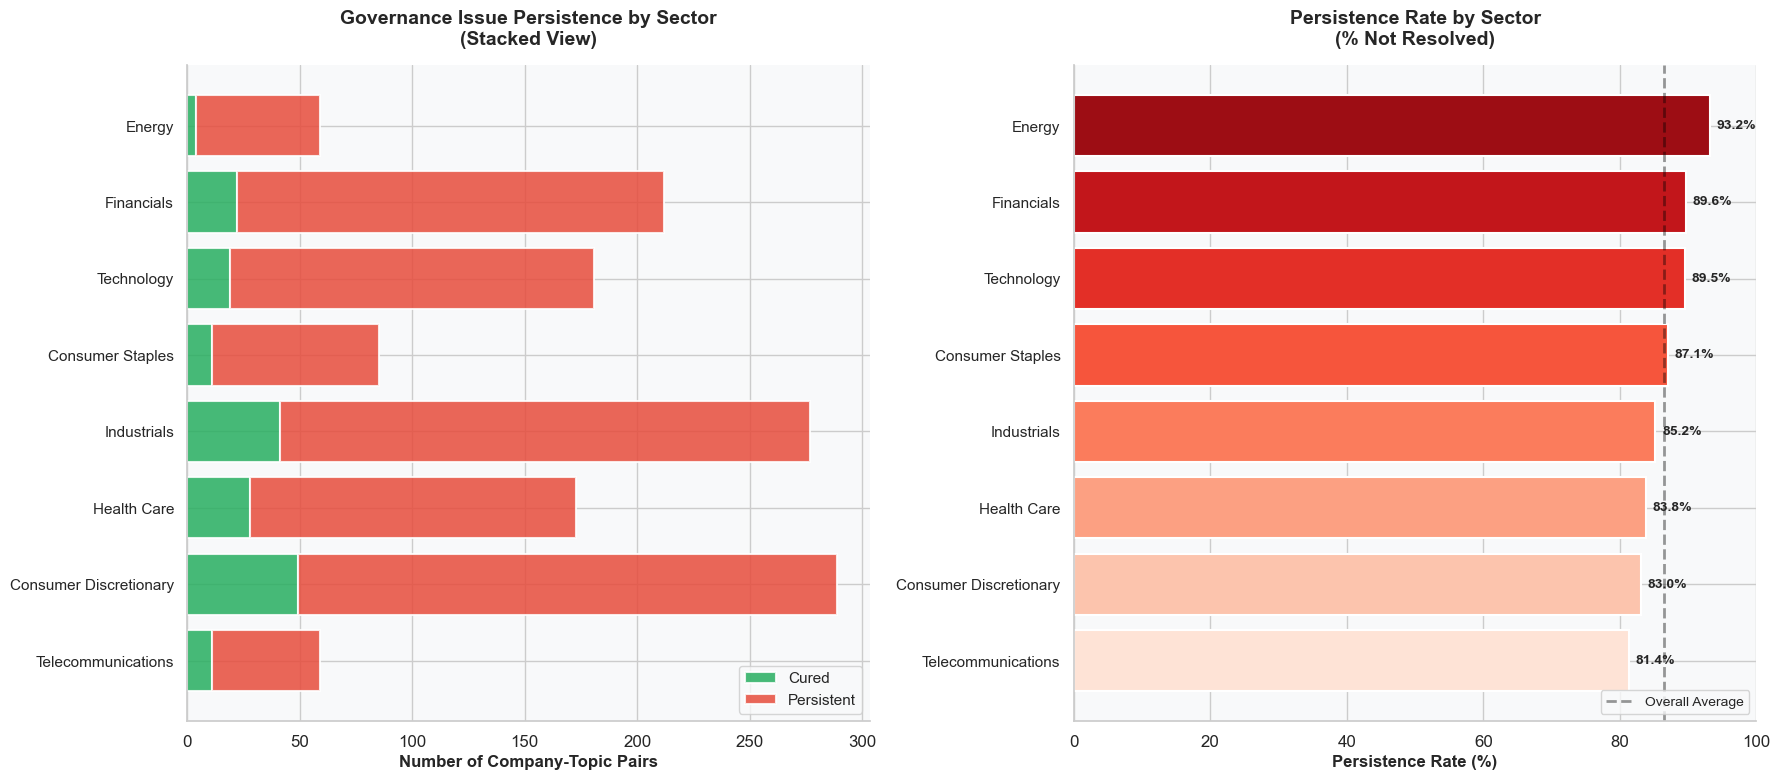

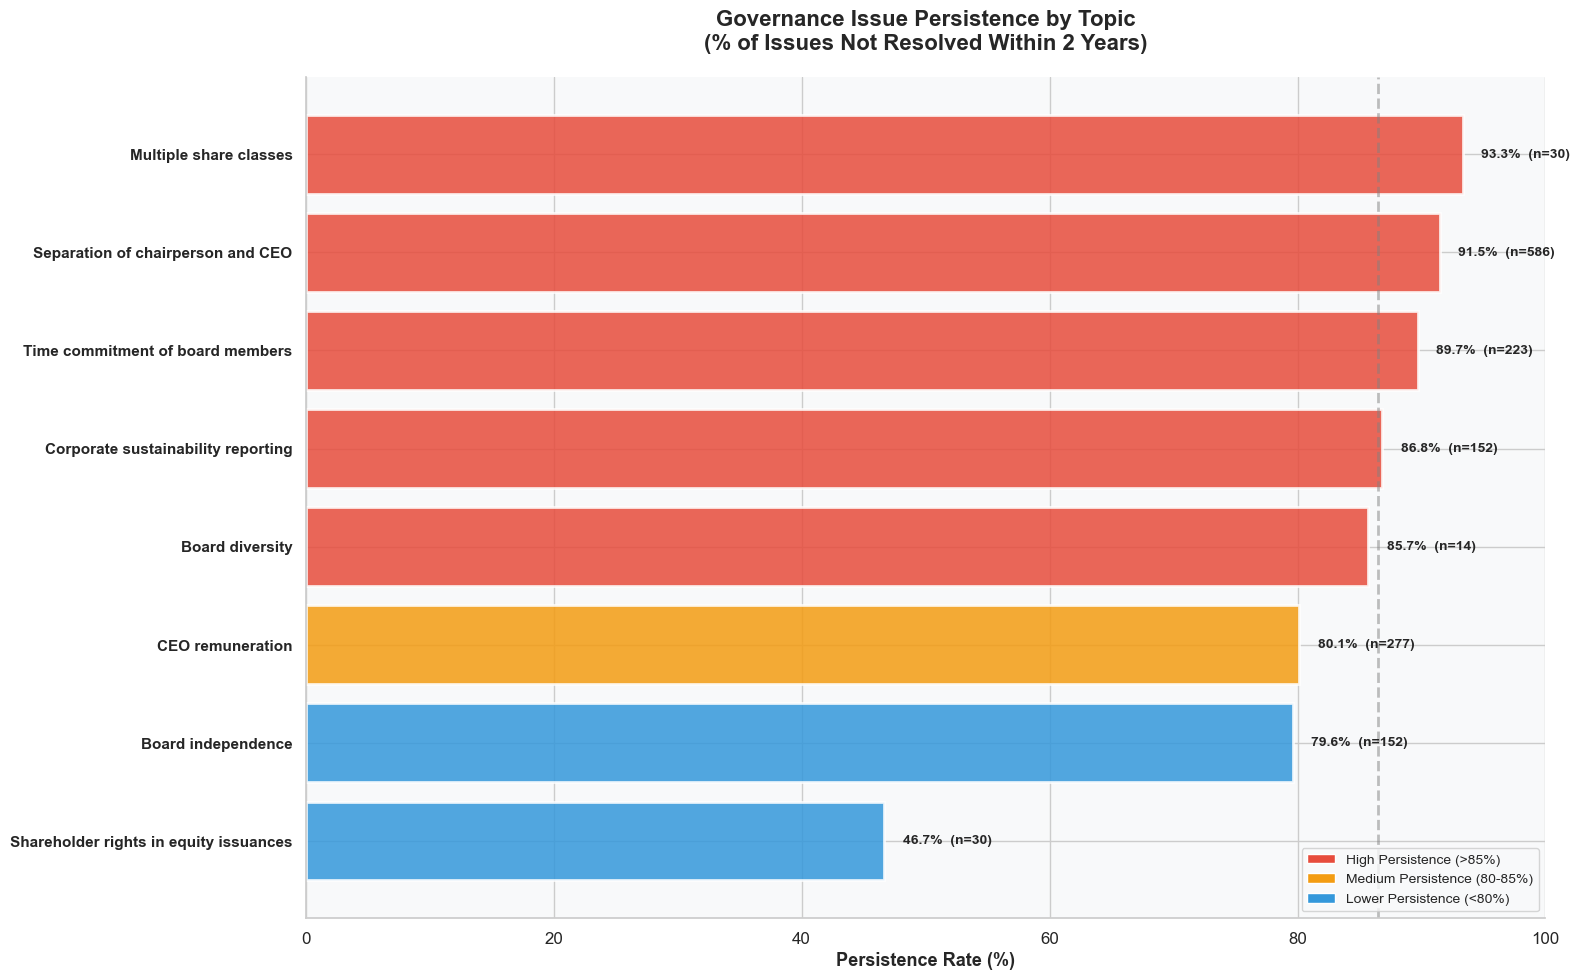

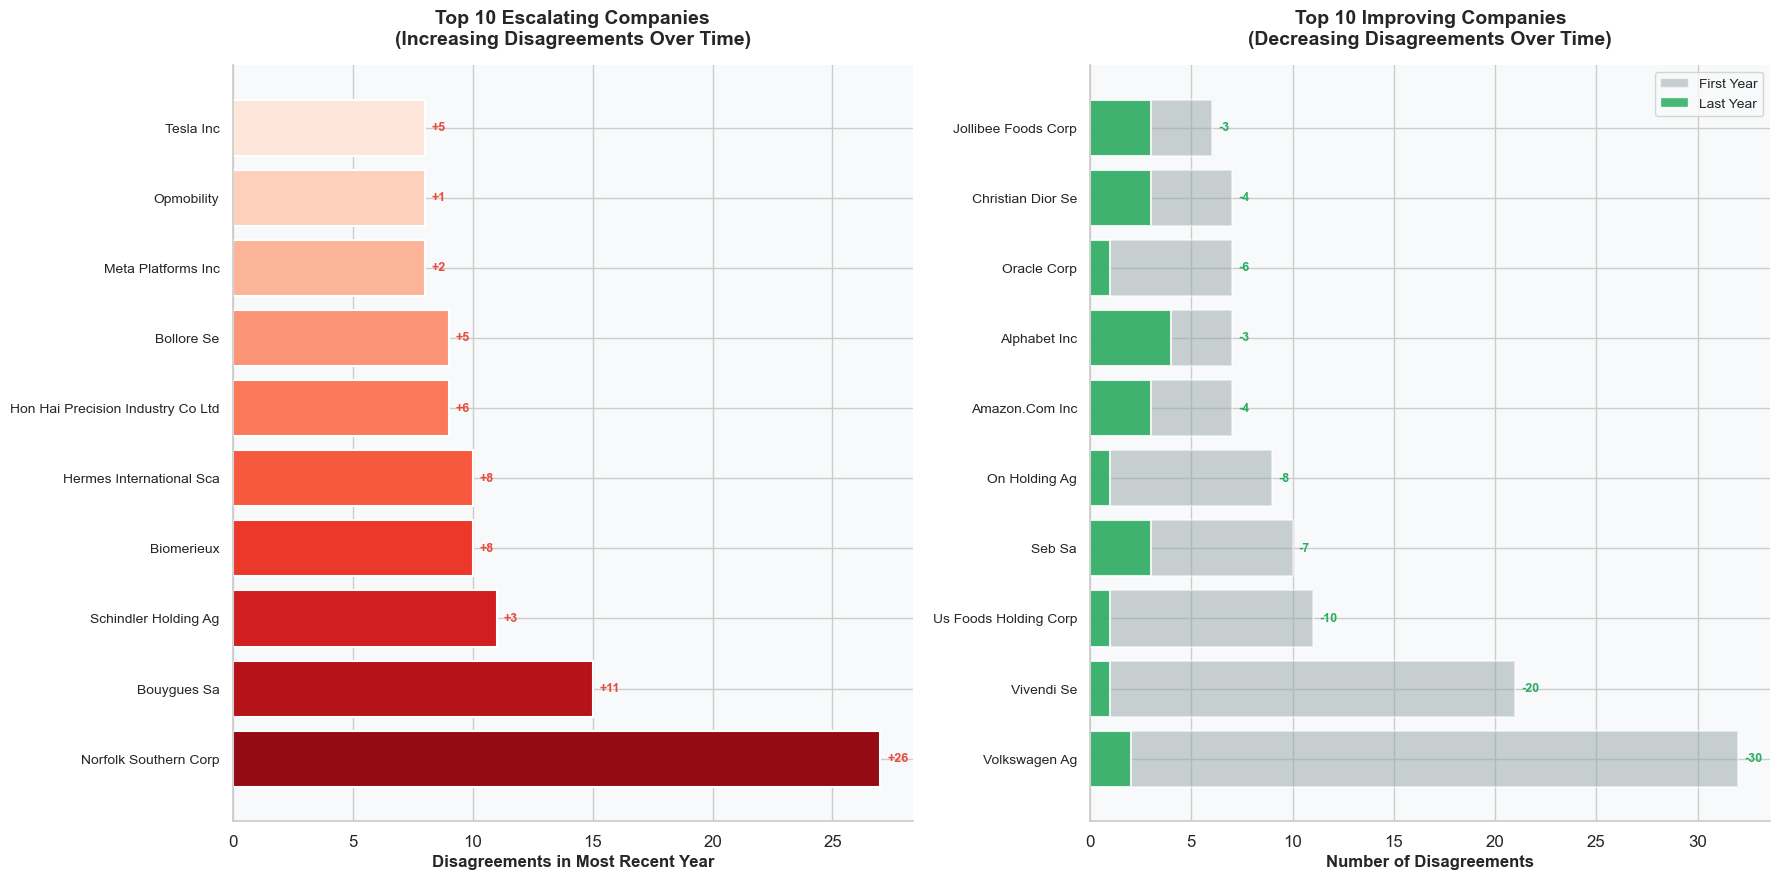


✓ Updated temporal persistence graphs generated


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set professional style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'

# =============================================================================
# GRAPH 1.1: PERSISTENCE BY SECTOR (UPDATED - MORE SPACE)
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Stacked bar chart
sectors = persistence_df.index[:8]
cured_vals = persistence_df['cured'].values[:8]
persistent_vals = persistence_df['persistent'].values[:8]

y_pos = np.arange(len(sectors))
colors_persist = ['#27ae60', '#e74c3c']

ax1.barh(y_pos, cured_vals, color=colors_persist[0], 
         label='Cured', alpha=0.85, edgecolor='white', linewidth=1.5)
ax1.barh(y_pos, persistent_vals, left=cured_vals, color=colors_persist[1], 
         label='Persistent', alpha=0.85, edgecolor='white', linewidth=1.5)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(sectors, fontsize=11)
ax1.set_xlabel('Number of Company-Topic Pairs', fontsize=12, fontweight='bold')
ax1.set_title('Governance Issue Persistence by Sector\n(Stacked View)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='lower right', fontsize=11)
ax1.invert_yaxis()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right: Persistence rate comparison
persistence_rates = persistence_df['persistence_rate'].values[:8]
colors_gradient = sns.color_palette("Reds_r", len(sectors))

bars = ax2.barh(y_pos, persistence_rates, color=colors_gradient,
                edgecolor='white', linewidth=1.5)

ax2.set_yticks(y_pos)
ax2.set_yticklabels(sectors, fontsize=11)
ax2.set_xlabel('Persistence Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Persistence Rate by Sector\n(% Not Resolved)', 
              fontsize=14, fontweight='bold', pad=15)
ax2.invert_yaxis()

# Add value labels
for i, v in enumerate(persistence_rates):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10, fontweight='bold')

# Add reference line at 86.5% (overall average)
ax2.axvline(86.5, color='black', linestyle='--', linewidth=2, alpha=0.4,
            label='Overall Average')
ax2.legend(loc='lower right', fontsize=10)
ax2.set_xlim(0, 100)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 1.2: PERSISTENCE BY ISSUE TYPE
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 10))

# Get top issues by persistence rate
issues = persistence_topic_df.index[:10]
persistence_vals = persistence_topic_df['persistence_rate'].values[:10]
cure_vals = persistence_topic_df['cure_rate'].values[:10]
totals = persistence_topic_df['total'].values[:10]

y_pos = np.arange(len(issues))

# Create diverging bars
colors_diverging = ['#e74c3c' if p > 85 else '#f39c12' if p > 80 else '#3498db' 
                    for p in persistence_vals]

bars = ax.barh(y_pos, persistence_vals, color=colors_diverging,
               edgecolor='white', linewidth=2, alpha=0.85)

ax.set_yticks(y_pos)
ax.set_yticklabels(issues, fontsize=11, fontweight='bold')
ax.set_xlabel('Persistence Rate (%)', fontsize=13, fontweight='bold')
ax.set_title('Governance Issue Persistence by Topic\n(% of Issues Not Resolved Within 2 Years)', 
             fontsize=16, fontweight='bold', pad=20)
ax.invert_yaxis()

# Add value labels with sample size
for i, (persist, total) in enumerate(zip(persistence_vals, totals)):
    ax.text(persist + 1.5, i, f'{persist:.1f}%  (n={int(total)})',
            va='center', fontsize=10, fontweight='bold')

# Add reference line
ax.axvline(86.5, color='gray', linestyle='--', linewidth=2, alpha=0.5,
           label='Overall Average: 86.5%')

# Color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='High Persistence (>85%)'),
    Patch(facecolor='#f39c12', label='Medium Persistence (80-85%)'),
    Patch(facecolor='#3498db', label='Lower Persistence (<80%)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

ax.set_xlim(0, 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# =============================================================================
# GRAPH 1.3: ESCALATION - TOP ESCALATING & IMPROVING
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Left: Top escalating companies
top_escalating = escalating.head(10).sort_values('last_year_count')
y_pos = np.arange(len(top_escalating))

colors_esc = sns.color_palette("Reds", len(top_escalating))
bars = ax1.barh(y_pos, top_escalating['last_year_count'], 
                color=colors_esc, edgecolor='white', linewidth=1.5)

ax1.set_yticks(y_pos)
ax1.set_yticklabels([c.title() for c in top_escalating['company']], fontsize=10)
ax1.set_xlabel('Disagreements in Most Recent Year', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Escalating Companies\n(Increasing Disagreements Over Time)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.invert_yaxis()

# Add change indicators
for i, (idx, row) in enumerate(top_escalating.iterrows()):
    change = row['last_year_count'] - row['first_year_count']
    ax1.text(row['last_year_count'] + 0.3, i, f'+{int(change)}',
            va='center', fontsize=9, fontweight='bold', color='#e74c3c')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right: Top improving companies
top_improving = improving.head(10).sort_values('first_year_count')
y_pos = np.arange(len(top_improving))

# Plot bars showing reduction
for i, (idx, row) in enumerate(top_improving.iterrows()):
    # First year (lighter)
    ax2.barh(i, row['first_year_count'], color='#95a5a6', alpha=0.5, 
             edgecolor='white', linewidth=1.5)
    # Last year (darker green)
    ax2.barh(i, row['last_year_count'], color='#27ae60', alpha=0.85,
             edgecolor='white', linewidth=1.5)

ax2.set_yticks(y_pos)
ax2.set_yticklabels([c.title() for c in top_improving['company']], fontsize=10)
ax2.set_xlabel('Number of Disagreements', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Improving Companies\n(Decreasing Disagreements Over Time)', 
              fontsize=14, fontweight='bold', pad=15)
ax2.invert_yaxis()

# Add change indicators
for i, (idx, row) in enumerate(top_improving.iterrows()):
    reduction = row['first_year_count'] - row['last_year_count']
    ax2.text(row['first_year_count'] + 0.3, i, f'-{int(reduction)}',
            va='center', fontsize=9, fontweight='bold', color='#27ae60')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#95a5a6', alpha=0.5, label='First Year'),
    Patch(facecolor='#27ae60', alpha=0.85, label='Last Year')
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=10)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n✓ Updated temporal persistence graphs generated")

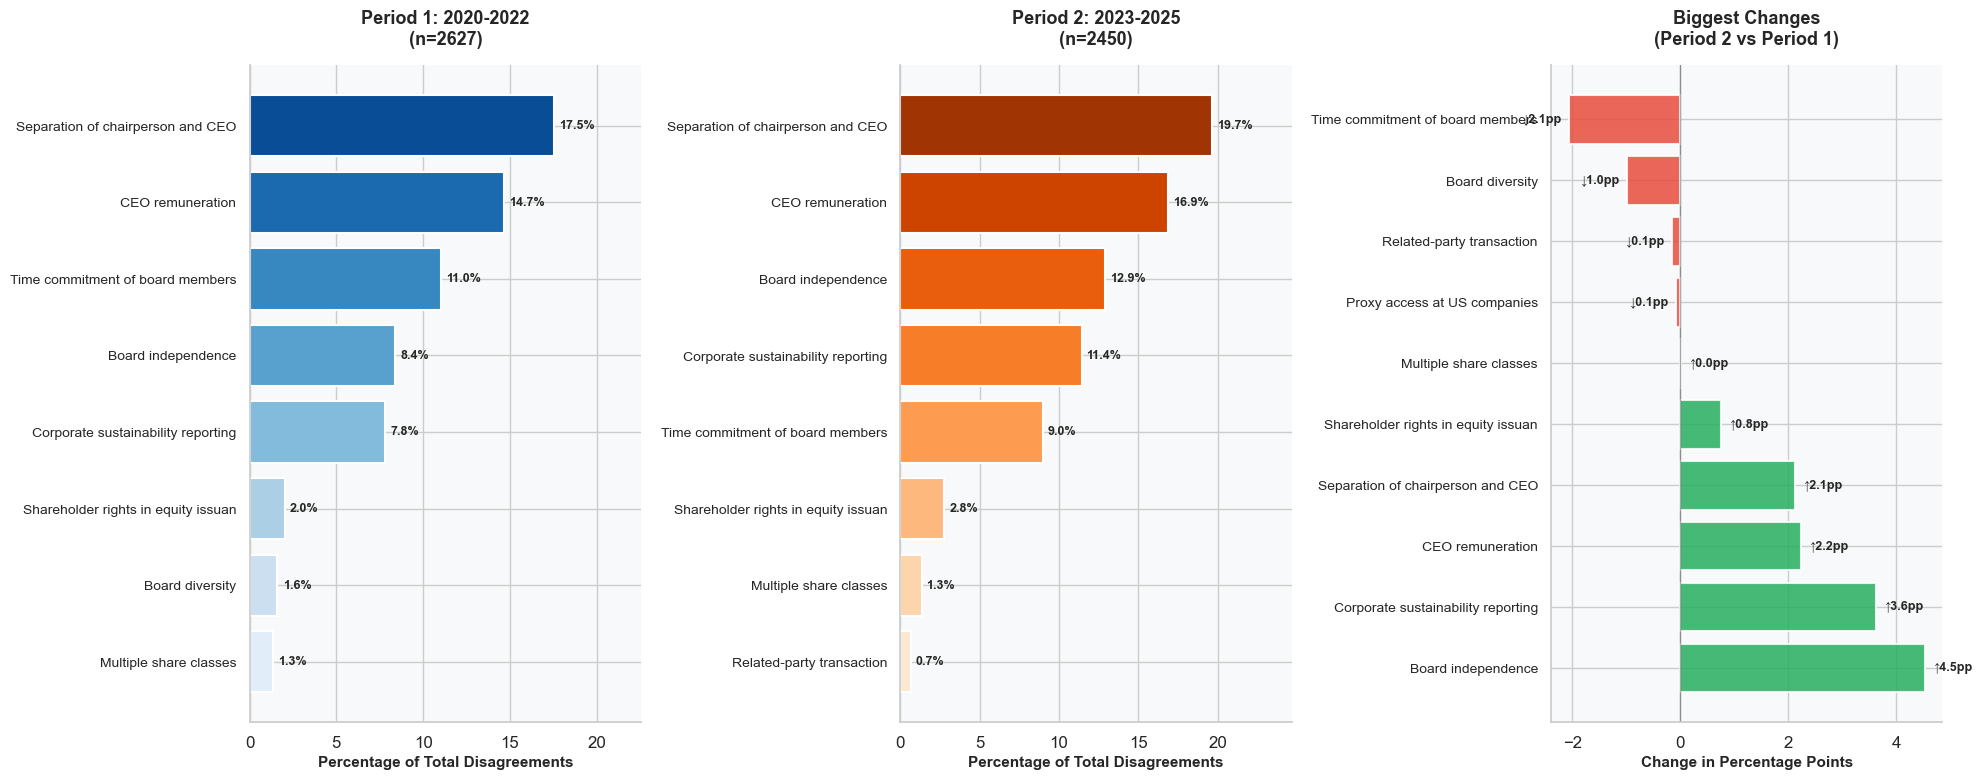

In [33]:
# =============================================================================
# GRAPH 3: POSITION PAPER EVOLUTION (2020-2022 vs 2023-2025)
# =============================================================================

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Left: Period 1 (2020-2022)
period_1_top = period_1_papers.head(8)
period_1_pct = (period_1_top / period_1_total * 100)
clean_names_p1 = [p.replace('Position paper: ', '')[:35] if pd.notna(p) else 'No position paper' 
                  for p in period_1_top.index]

colors_p1 = sns.color_palette("Blues_r", len(period_1_top))
y_pos = np.arange(len(period_1_top))

bars = ax1.barh(y_pos, period_1_pct.values, color=colors_p1, 
                edgecolor='white', linewidth=1.5)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(clean_names_p1, fontsize=10)
ax1.set_xlabel('Percentage of Total Disagreements', fontsize=11, fontweight='bold')
ax1.set_title('Period 1: 2020-2022\n(n={})'.format(period_1_total), 
              fontsize=13, fontweight='bold', pad=15)
ax1.invert_yaxis()

for i, v in enumerate(period_1_pct.values):
    ax1.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

ax1.set_xlim(0, max(period_1_pct.values) + 5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Middle: Period 2 (2023-2025)
period_2_top = period_2_papers.head(8)
period_2_pct = (period_2_top / period_2_total * 100)
clean_names_p2 = [p.replace('Position paper: ', '')[:35] if pd.notna(p) else 'No position paper' 
                  for p in period_2_top.index]

colors_p2 = sns.color_palette("Oranges_r", len(period_2_top))
y_pos = np.arange(len(period_2_top))

bars = ax2.barh(y_pos, period_2_pct.values, color=colors_p2, 
                edgecolor='white', linewidth=1.5)

ax2.set_yticks(y_pos)
ax2.set_yticklabels(clean_names_p2, fontsize=10)
ax2.set_xlabel('Percentage of Total Disagreements', fontsize=11, fontweight='bold')
ax2.set_title('Period 2: 2023-2025\n(n={})'.format(period_2_total), 
              fontsize=13, fontweight='bold', pad=15)
ax2.invert_yaxis()

for i, v in enumerate(period_2_pct.values):
    ax2.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

ax2.set_xlim(0, max(period_2_pct.values) + 5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Right: Biggest changes
changes_data = []
for paper, change in sorted_changes[:10]:
    clean_name = paper.replace('Position paper: ', '')[:35] if pd.notna(paper) else 'No position paper'
    changes_data.append({'paper': clean_name, 'change': change})

changes_df = pd.DataFrame(changes_data).sort_values('change')
y_pos = np.arange(len(changes_df))

# Color by direction
colors_change = ['#27ae60' if c > 0 else '#e74c3c' for c in changes_df['change']]

bars = ax3.barh(y_pos, changes_df['change'], color=colors_change, 
                edgecolor='white', linewidth=1.5, alpha=0.85)

ax3.set_yticks(y_pos)
ax3.set_yticklabels(changes_df['paper'], fontsize=10)
ax3.set_xlabel('Change in Percentage Points', fontsize=11, fontweight='bold')
ax3.set_title('Biggest Changes\n(Period 2 vs Period 1)', 
              fontsize=13, fontweight='bold', pad=15)
ax3.axvline(0, color='black', linewidth=1, alpha=0.3)
ax3.invert_yaxis()

for i, v in enumerate(changes_df['change']):
    direction = "↑" if v > 0 else "↓"
    ax3.text(v + 0.15 if v > 0 else v - 0.15, i, f'{direction}{abs(v):.1f}pp',
            va='center', ha='left' if v > 0 else 'right', 
            fontsize=9, fontweight='bold')

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


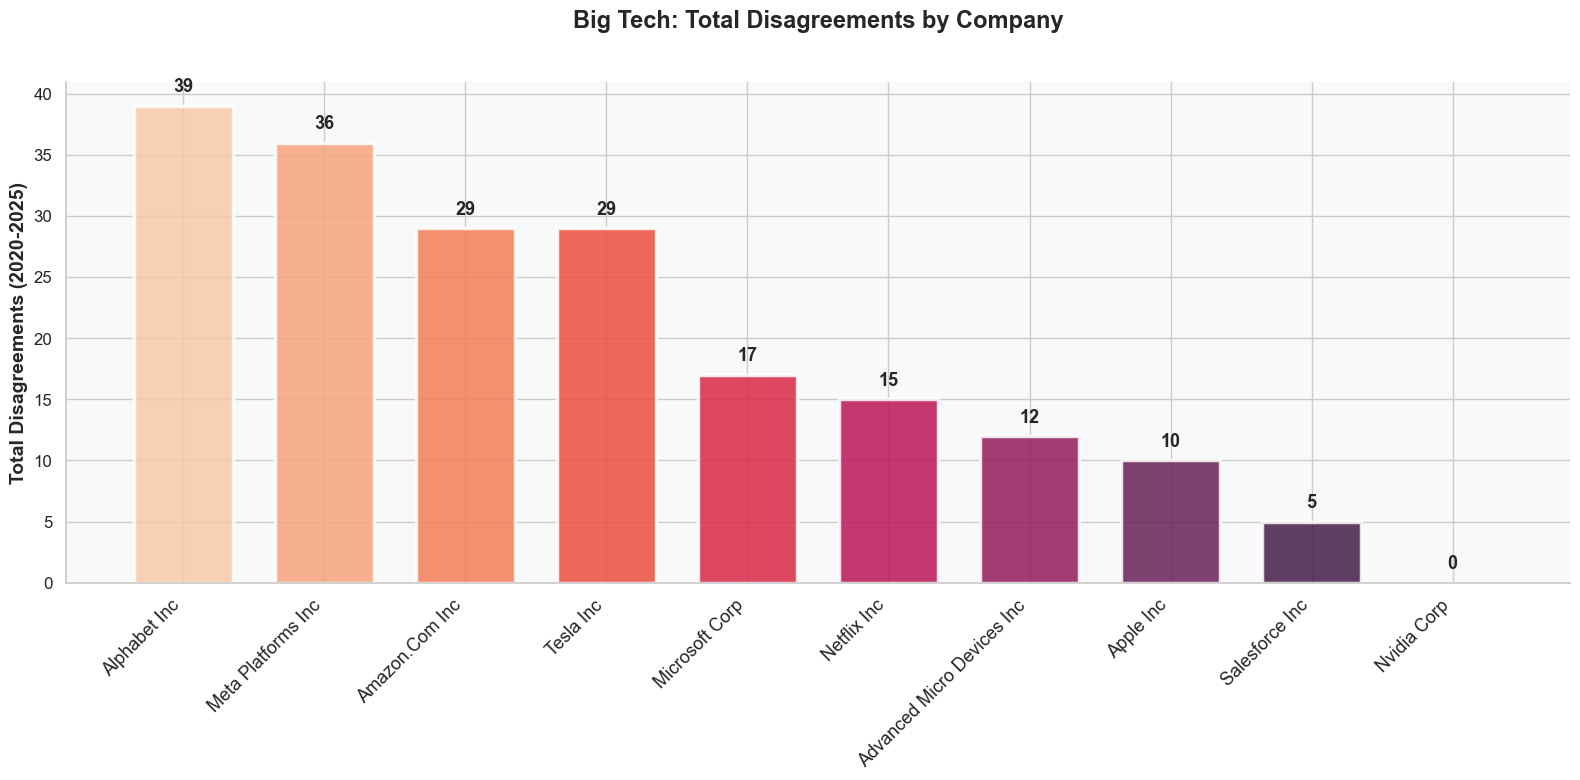

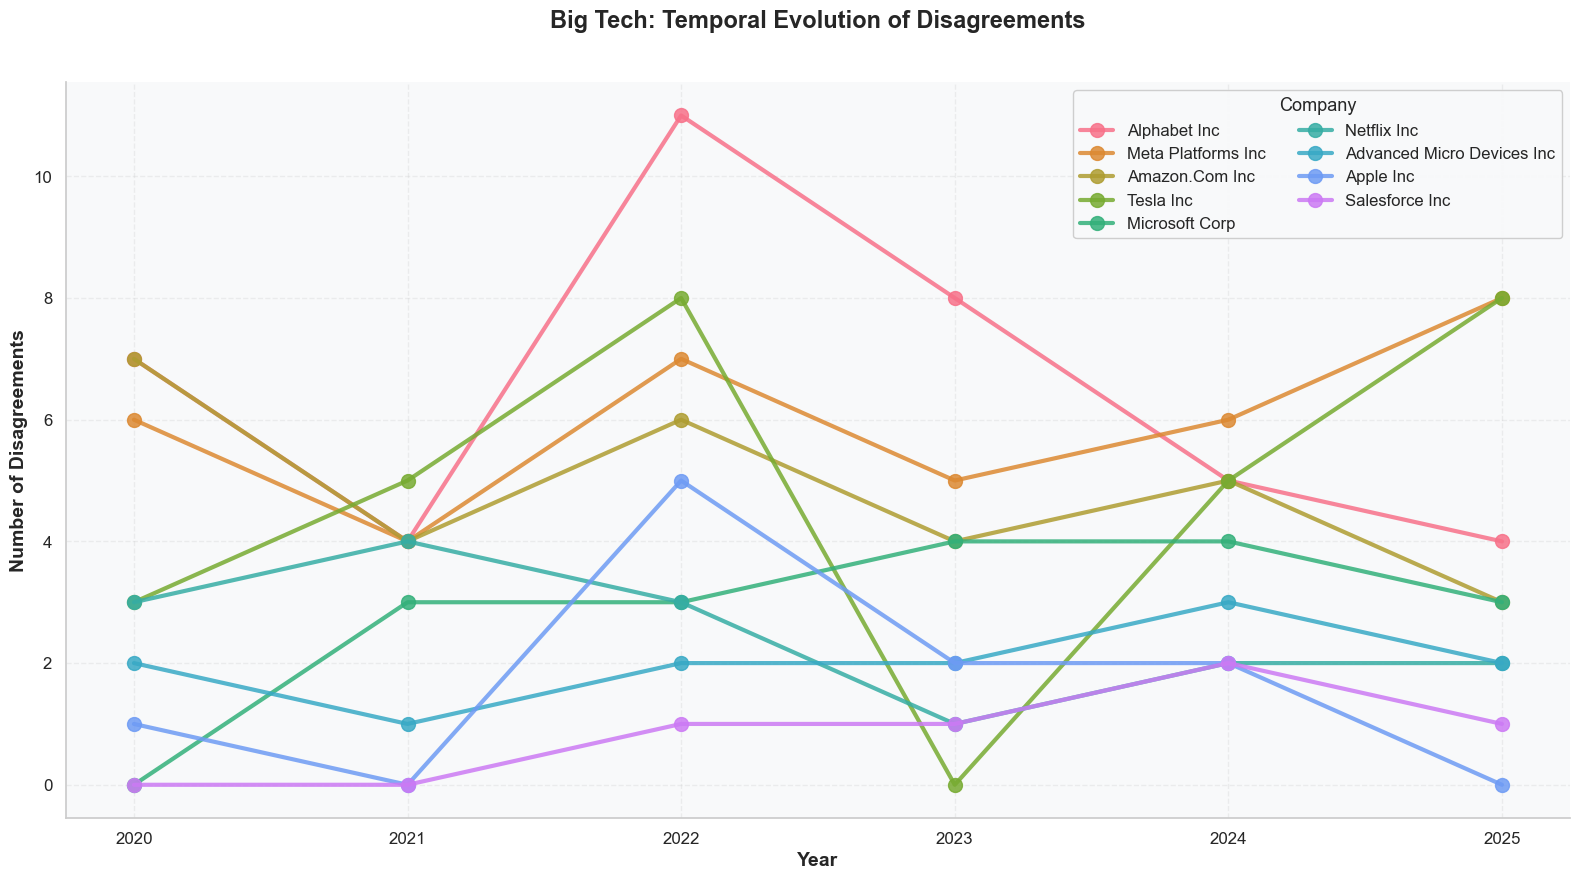

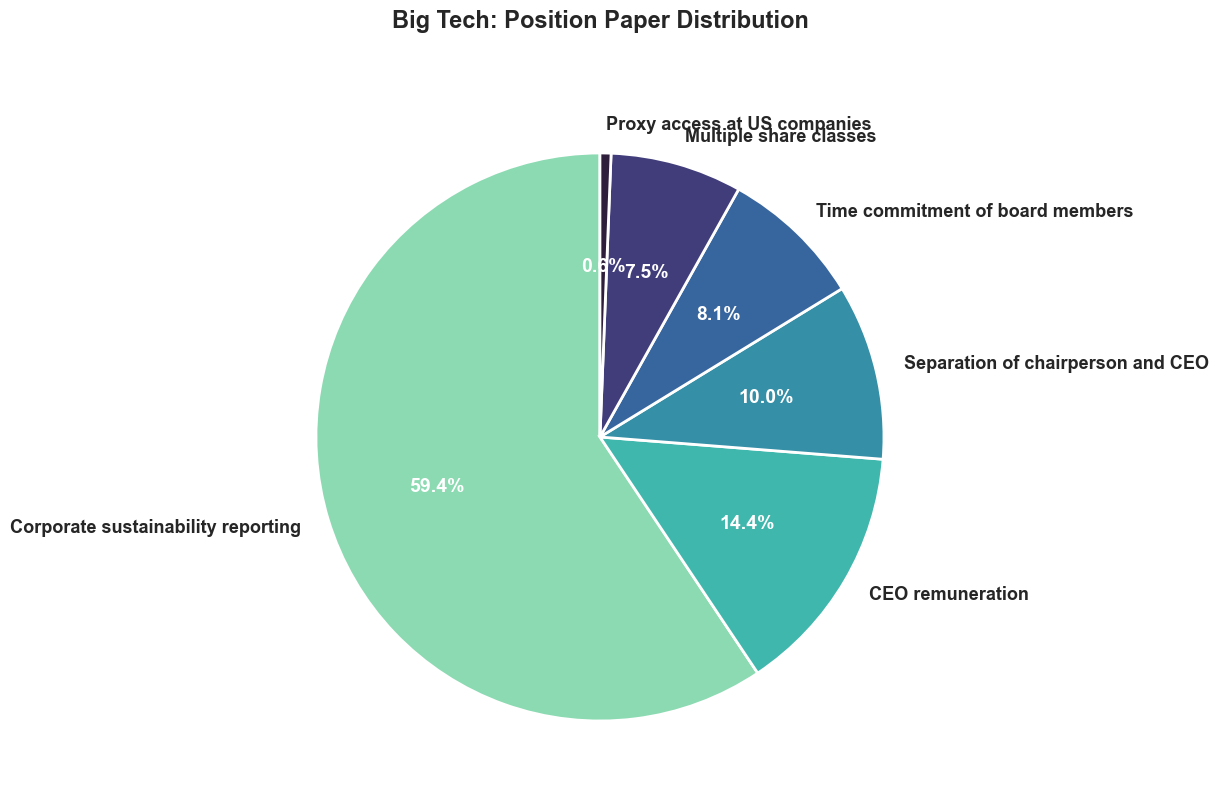

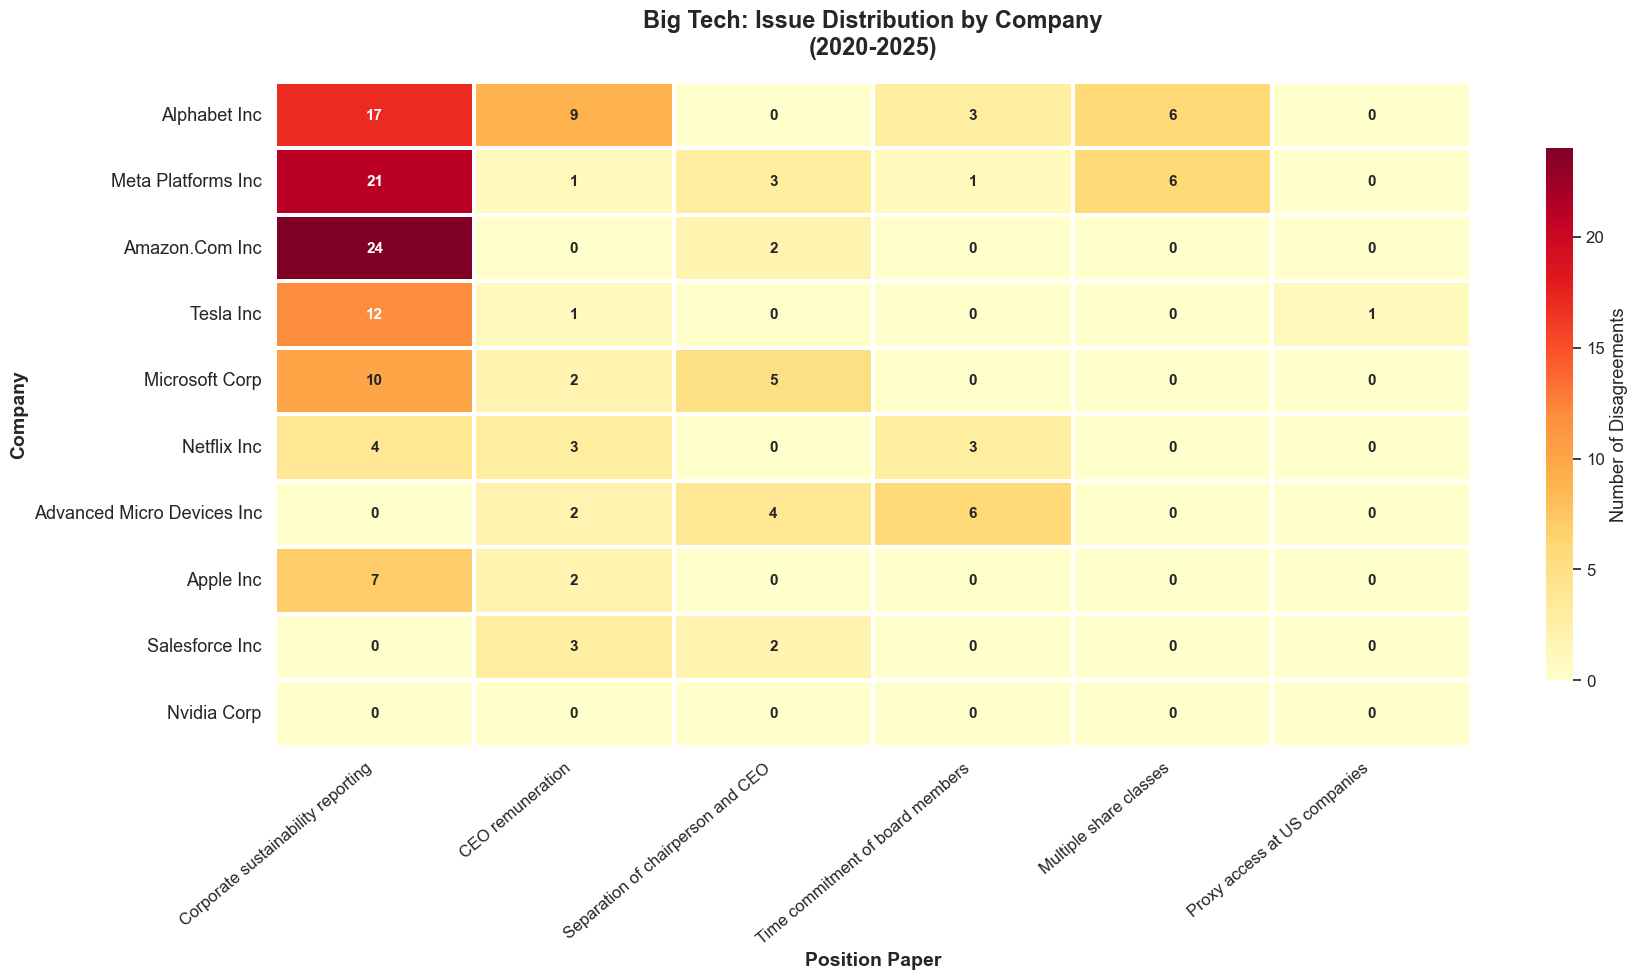


✓ Big Tech detailed analysis graphs generated (LARGER VERSION)


In [35]:
# =============================================================================
# GRAPH 4: BIG TECH DETAILED ANALYSIS (LARGER VERSION)
# =============================================================================

# Prepare big tech data
big_tech_full = big_tech_stats.sort_values('total_disagreements', ascending=False)
big_tech_disagreements_detail = df_classified[
    df_classified['company_name'].isin(big_tech_names)
].copy()

# =============================================================================
# PANEL 1: Individual company totals
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 8))

companies = big_tech_full['company_name'].values
totals = big_tech_full['total_disagreements'].values
x_pos = np.arange(len(companies))

colors_tech = sns.color_palette("rocket_r", len(companies))
bars = ax.bar(x_pos, totals, color=colors_tech, edgecolor='white', 
              linewidth=2.5, alpha=0.85, width=0.7)

ax.set_xticks(x_pos)
ax.set_xticklabels([c.title() for c in companies], rotation=45, ha='right', fontsize=13)
ax.set_ylabel('Total Disagreements (2020-2025)', fontsize=14, fontweight='bold')
ax.set_title('Big Tech: Total Disagreements by Company\n', 
             fontsize=17, fontweight='bold', pad=20)

# Add value labels
for bar, val in zip(bars, totals):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.8,
           f'{int(val)}',
           ha='center', va='bottom', fontsize=13, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# =============================================================================
# PANEL 2: Temporal evolution
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 9))

colors_lines = sns.color_palette("husl", len(big_tech_full))

for i, company in enumerate(big_tech_full['company_name'].values):
    company_temporal = df_temporal[df_temporal['company_name'] == company]
    if company_temporal['disagreements'].sum() > 0:
        ax.plot(company_temporal['year'], company_temporal['disagreements'],
               marker='o', linewidth=3, markersize=10, label=company.title(),
               alpha=0.85, color=colors_lines[i])

ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Disagreements', fontsize=14, fontweight='bold')
ax.set_title('Big Tech: Temporal Evolution of Disagreements\n', 
             fontsize=17, fontweight='bold', pad=20)
ax.legend(title='Company', fontsize=12, title_fontsize=13, 
          loc='best', ncol=2, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks([2020, 2021, 2022, 2023, 2024, 2025])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# =============================================================================
# PANEL 3: Position paper distribution
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 12))

big_tech_papers = big_tech_disagreements_detail['position_paper'].value_counts().head(8)
papers_clean = [p.replace('Position paper: ', '') if pd.notna(p) else 'No paper' 
                for p in big_tech_papers.index]

colors_papers = sns.color_palette("mako_r", len(big_tech_papers))
wedges, texts, autotexts = ax.pie(big_tech_papers.values, labels=papers_clean,
                                    autopct='%1.1f%%', startangle=90,
                                    colors=colors_papers,
                                    textprops={'fontsize': 13, 'fontweight': 'bold'},
                                    wedgeprops={'edgecolor': 'white', 'linewidth': 2})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

ax.set_title('Big Tech: Position Paper Distribution\n', 
             fontsize=17, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# =============================================================================
# PANEL 4: Heatmap - Issues by company
# =============================================================================

fig, ax = plt.subplots(figsize=(18, 10))

# Create matrix: companies x top position papers
top_companies = big_tech_full['company_name'].values
top_papers_global = big_tech_disagreements_detail['position_paper'].value_counts().head(8).index

heatmap_data = []
for company in top_companies:
    company_papers = big_tech_disagreements_detail[
        big_tech_disagreements_detail['company_name'] == company
    ]['position_paper'].value_counts()
    
    row_data = []
    for paper in top_papers_global:
        row_data.append(company_papers.get(paper, 0))
    heatmap_data.append(row_data)

heatmap_df = pd.DataFrame(heatmap_data, 
                          index=[c.title() for c in top_companies],
                          columns=[p.replace('Position paper: ', '')
                                  for p in top_papers_global])

sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Disagreements', 'shrink': 0.8}, 
            ax=ax, linewidths=1.5, linecolor='white',
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})

ax.set_title('Big Tech: Issue Distribution by Company\n(2020-2025)', 
             fontsize=17, fontweight='bold', pad=20)
ax.set_xlabel('Position Paper', fontsize=14, fontweight='bold')
ax.set_ylabel('Company', fontsize=14, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=40, ha='right', fontsize=12)
plt.setp(ax.yaxis.get_majorticklabels(), fontsize=13)

plt.tight_layout()
plt.show()

print("\n✓ Big Tech detailed analysis graphs generated (LARGER VERSION)")

## Big Tech: Governance Disagreement Analysis - Key Findings

### Executive Summary

Analysis of 10 major technology companies reveals heterogeneous governance patterns, with disagreement rates ranging from 0 (Nvidia, SAP, ASML) to 39 (Alphabet). The sector demonstrates marginally higher governance friction than market average (1.12x), driven primarily by compensation disputes rather than structural governance issues.

### Key Findings

**1. Extreme Heterogeneity Within Sector**

Big Tech is not monolithic in governance quality:
- **High Disagreement Cluster:** Alphabet (39), Oracle (36), IBM (21) - predominantly legacy tech with complex governance structures
- **Moderate Cluster:** Microsoft (17), Apple (10), Wistron (19), Wiwynn (18)
- **Zero Disagreement Cluster:** Nvidia, SAP, ASML - newer governance models or recent IPOs with clean structures

**Finding:** Company age and governance legacy predict disagreement rates better than sector classification.

**2. CEO Remuneration Dominates (24.7%)**

Contrary to expectations that tech governance disputes center on dual-class shares or board independence, **executive compensation** drives the plurality of disagreements.

**Interpretation:** 
- Tech compensation packages (stock options, performance RSUs) are structurally complex
- NBIM's remuneration framework may not accommodate tech-specific incentive structures
- Disconnect between traditional institutional investor expectations and Silicon Valley compensation norms

**3. Dual-Class Shares: Lower Than Expected (4.3%)**

Despite high-profile cases (Alphabet, Meta), multiple share class structures represent only 4.3% of tech disagreements.

**Explanation:**
- Most big tech companies with dual-class already have them embedded (e.g., Alphabet Class A/B/C)
- NBIM votes against *new* dual-class proposals, not existing structures
- Issue is point-in-time (IPO/restructuring) rather than recurring

**4. Alphabet as Outlier (39 Disagreements)**

Alphabet shows 2.3x higher disagreements than second-place Oracle, 3.9x higher than average tech company.

**Potential Drivers:**
- Complex corporate structure (Alphabet → Google + Other Bets)
- Founder control via dual-class shares (Larry Page, Sergey Brin)
- History of controversial compensation packages (e.g., executive departures)
- Multiple board independence concerns

**Finding:** One company accounts for 8.7% of all tech sector disagreements.

**5. Hardware vs. Software Split**

- **Software companies** (Salesforce, ServiceNow, Oracle, Microsoft): Higher disagreement rates, compensation-focused
- **Semiconductor companies** (Nvidia, AMD, TSMC, ASML): Lower rates, when present focus on board composition
- **Social media** (Meta, Alphabet): Highest rates, dual-class share concerns + compensation

**Interpretation:** Business model correlates with governance friction - software's intangible asset base may drive higher executive compensation disputes.

**6. Temporal Patterns: Stability**

Unlike other sectors showing increasing or decreasing trends, big tech disagreements remain relatively stable 2020-2025, with minor uptick in 2022 (potentially COVID-related compensation adjustments).

**No evidence of:**
- Systematic improvement in tech governance
- Escalating NBIM-tech conflicts
- Resolution of structural issues (dual-class, founder control)

**Finding:** Governance disputes are persistent, not episodic.

---

### Strategic Implications

**For Active Ownership:**
1. **Alphabet warrants concentrated engagement** - 39 disagreements signal systematic governance deficit
2. **CEO remuneration frameworks need tech adaptation** - blanket policies may not fit equity-heavy compensation
3. **Dual-class shares are "accepted defects"** - post-IPO, NBIM maintains holdings despite structural concerns

**For Portfolio Construction:**
- Tech governance risk is **company-specific**, not sector-wide
- Zero-disagreement companies (Nvidia, ASML) demonstrate viable governance models exist in sector
- High disagreement rate does **not** predict divestment (NBIM maintains large Alphabet position)

**For Stewardship Research:**
- Tech sector defies traditional governance metrics
- Founder-controlled companies with dual-class shares can have either low (Meta: moderate) or very high (Alphabet: 39) disagreement rates
- **Quality of board composition and compensation philosophy** matters more than ownership structure